In [1]:
%config Completer.use_jedi = False # To make auto-complete faster

#Reloads imported files automatically
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../utils/')

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stat
from scipy.spatial import KDTree
import copy
import time
import os

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from matplotlib import colormaps as mplcmaps
import matplotlib.cm as cm

from matplotlib_param_funcs import set_matplotlib_params,reset_rcParams
set_matplotlib_params()

In [4]:
import compute_variables as CV
import miscellaneous_functions as MF
import mixed_plots as MP
import plotting_helpers as PH
import variable_values_and_errors as val_err
import velocity_plot
import load_sim
import load_data
import map_functions as mapf
import coordinates

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [6]:
# degree_symbol = '°'
degree_symbol = '^\circ'

mass_density_label = r"$\Sigma \hspace{0.3} [\rm M_\odot kpc^{-2}]$"

In [7]:
coolwarm = mplcmaps['coolwarm']
red = coolwarm(0.95)
blue = coolwarm(0.05)
green = 'darkgreen'
grey = 'lightgrey'

plt.rcParams['font.size'] = 20

In [8]:
#CHOOSE

x_variable = "l"
y_variable = "b"

vel_x_variable = 'r'
vel_y_variable = 'l'

In [9]:
symbol_dict = mapf.get_kinematic_symbols_dict(x_variable=x_variable,
                                                         y_variable=y_variable,
                                                         vel_x_variable=vel_x_variable,
                                                         vel_y_variable=vel_y_variable)

units_dict = mapf.get_kinematic_units_dict(position_variables=x_variable+y_variable,
                                                     vel_x_variable=vel_x_variable,
                                                     vel_y_variable=vel_y_variable,
                                                     degree_symbol=degree_symbol)

pos_symbols_dict,pos_units_dict = mapf.get_position_symbols_and_units_dict(degree_symbol="°")

In [10]:
symbol_dict["mean_b"] = r"$\langle |b| \rangle$"
units_dict["mean_b"] = r"$[^\circ]$"

In [11]:
full_map_string_list,divergent_map_list = mapf.get_map_string_lists()

all_maps = False
full_map_string_list = [map_string for map_string in full_map_string_list if "spherical" not in map_string]

print(full_map_string_list)

['number', 'mean_vx', 'mean_vy', 'mean_vx_error', 'mean_vy_error', 'std_vx', 'std_vy', 'std_vx_error', 'std_vy_error', 'anisotropy', 'anisotropy_error', 'correlation', 'correlation_error', 'tilt_abs', 'tilt_abs_error']


# Functions

In [12]:
def get_variable_ticks(map_string, map_array):
    if map_string == "vertex_abs":
        max_value = 45
        min_value = -max_value
    elif map_string == "vertex":
        max_value = 90
        min_value = -max_value
    elif map_string == "error":
        min_value = 0
        max_value = np.nanmax(map_array)
    elif map_string == "varr" or map_string == "varl":
        #min_value = 0
        min_value = np.nanmin([all_varr[norm_index], all_varl[norm_index]])
        max_value = np.nanmax([all_varr, all_varl])
    elif map_string == "mean_vr" or map_string == "mean_vl":
        mini = np.nanmin([map_dict["mean_vr"],map_dict["mean_vl"]])
        maxi = np.nanmax([map_dict["mean_vr"],map_dict["mean_vl"]])

        limits = [mini, maxi]

        lims_factor = 1
        min_value = -lims_factor*np.max(np.abs(limits))
        max_value = lims_factor*np.max(np.abs(limits))
    elif map_string in ["covariance","correlation","anisotropy"]:#divergent_map_list:
        mini = np.nanmin(map_array)
        maxi = np.nanmax(map_array)

        limits = [mini, maxi]

        lims_factor = 1
        min_value = -lims_factor*np.max(np.abs(limits))
        max_value = lims_factor*np.max(np.abs(limits))
    else:
        min_value = np.nanmin(map_array)
        max_value = np.nanmax(map_array)

    ticks = np.linspace(min_value,max_value,5)
    return ticks
def create_map_array_dict(full_map_string_list, all_arrays):
    if len(full_map_string_list) != len(all_arrays):
        raise ValueError("len(full_map_string_list) different to len(all_arrays)")
    map_dict = {}
    for index, map_string in enumerate(full_map_string_list):
        map_dict[map_string] = all_arrays[index]
    return map_dict

# Load

In [13]:
dummy_df = pd.DataFrame([[1,2,3],[2,3,1],[6,3,4]], columns=['a','b','c'])

In [14]:
general_path = '/Users/luismi/Desktop/MRes_UCLan/'

In [15]:
zabs = True
# zabs = False

R0 = 8.1

GSR = True
# GSR = False

## Sim

In [16]:
sim_choice = "708main" #stuart

rot_angle = 27
axisymmetric = False
pos_scaling = 1.7

In [90]:
load_chunk = False

if not load_chunk:
    np_path = general_path+f"data/708main_simulation/numpy_arrays/R0_{R0}/"
        
    df0 = load_sim.load_simulation(path=np_path, choice=sim_choice, rot_angle = rot_angle, axisymmetric=axisymmetric, GSR=GSR,zabs=zabs, pos_factor=pos_scaling,R0=R0)
else:
    if sim_choice == "708main" and rot_angle == 27 and not axisymmetric and zabs and sim_scaling == 1.7:
        pickle_name = "df_bulge_zabs.pkl"
        df0 = pd.read_pickle("708main_simulation/"+pickle_name)

708MWout_bar27_scale1.7_8.1R0.npy loaded successfully.


In [ ]:
sim_resampled_bool = False

## Observations

### Gibs 

In [15]:
general_path = "C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/"

In [16]:
data = pd.DataFrame(np.genfromtxt(general_path + "Oscar_data/gibs_vvvPMs.dat", names=True))

In [17]:
data.head()

,l,b,RA,DEC,id,Vgc,eVgc,Jo,Ko,FeH,...,emul,mub,emub,NFRAMES,mul_grs,mub_grs,pmra,epmra,pmdec,epmdec
0,359.639007,-1.418988,267.586083,-29.978417,NaN,-35.49,2.07,13.165,12.714,-0.33,...,0.36,0.257,0.28,88.0,-2.302,0.147,-1.305,0.30,-1.902,0.34
1,359.645108,-1.408500,267.579292,-29.967806,NaN,205.39,2.27,13.403,12.906,-0.65,...,0.45,1.879,0.71,89.0,-5.237,1.769,-4.202,0.65,-3.591,0.53
2,359.670945,-1.395570,267.581750,-29.939000,NaN,260.45,2.38,12.988,12.243,-0.10,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,359.691308,-1.380355,267.578708,-29.913722,NaN,-108.56,1.26,12.902,12.252,-0.56,...,0.37,-3.822,0.29,88.0,-14.138,-3.934,-3.866,0.31,-14.157,0.35
4,359.696121,-1.379041,267.580250,-29.908917,NaN,182.52,1.30,13.428,12.874,-0.31,...,0.32,-0.170,0.33,90.0,-8.317,-0.282,-4.019,0.33,-7.287,0.32


In [18]:
delete_columns = data.columns

In [19]:
columns_to_keep = ['l','b','Vgc','FeH','mul_grs','mub_grs']

In [20]:
delete_columns = delete_columns.drop(columns_to_keep)

In [21]:
data.drop(columns=delete_columns, inplace=True)

In [22]:
data.dropna(how='any',inplace=True)

In [23]:
fixed_distance = 8 #8.2

In [24]:
data['vl']=(fixed_distance*3.086e16)*data.mul_grs.values*((np.pi/(180 * 3600))*10**(-3)/(3.1536e7))
data['vb']=(fixed_distance*3.086e16)*data.mub_grs.values*((np.pi/(180 * 3600))*10**(-3)/(3.1536e7))

In [25]:
data["vr"] = data["Vgc"]
#data["vr"] = np.sqrt(data["Vgc"]**2 - data["vl"]**2)

In [26]:
data.drop(columns = ['Vgc','mul_grs','mub_grs'],inplace=True)

In [27]:
data.loc[data.l > 180, 'l'] -= 360

In [28]:
data.head()

,l,b,FeH,vl,vb,vr
0,-0.360993,-1.418988,-0.33,-87.369427,5.579195,-35.49
1,-0.354892,-1.408500,-0.65,-198.763549,67.140103,205.39
3,-0.308692,-1.380355,-0.56,-536.589470,-149.309872,-108.56
4,-0.303879,-1.379041,-0.31,-315.660958,-10.702945,182.52
5,-0.300955,-1.372881,-0.21,-468.234849,64.559251,79.86


#### Visualise

In [73]:
save_path = general_path+'708main_simulation/graphs/Oscar/GIBS/'
print("Saving in:",save_path)

save_bool = False

Saving in: C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Oscar/GIBS/


C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Oscar/GIBS/velocities_fullrange.png


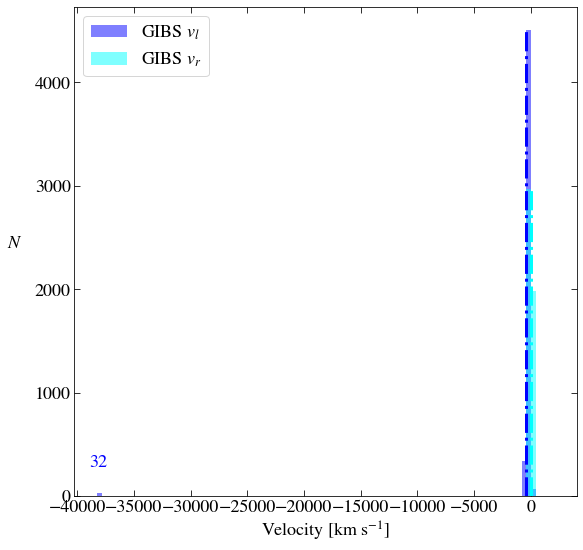

In [105]:
fig, ax = plt.subplots()

fullrange = True

lim = 1000
if not fullrange:
    ax.set_xlim(-lim,lim)
    bins = np.linspace(-lim,lim,100)
else:
    bins = 100
    ax.text(x=0.03,y=0.06,s=str(len(np.where(data['vl'] < -1000)[0])),color='blue',transform=ax.transAxes)
lw = 3
alpha = 0.5
a_n,a_bins,_ = ax.hist(data['vl'],bins=bins,alpha=alpha, color='blue',label=r'GIBS $v_l$')
ax.plot([np.mean(data['vl']),np.mean(data['vl'])],[0,np.max(a_n)],alpha=1,color='blue',lw=lw,linestyle='-.')

b_n,_,_ = ax.hist(data['vr'],bins=bins if not fullrange else a_bins,alpha=alpha, color='cyan',label=r'GIBS $v_r$')
ax.plot([np.mean(data['vr']),np.mean(data['vr'])],[0,np.max(b_n)],alpha=1,color='cyan',lw=lw,linestyle='-.')

ax.set_xlabel(r"Velocity $[\mathrm{km \hspace{0.3} s^{-1}}]$")
ax.set_ylabel(r"$N$", rotation=0,labelpad=20)
plt.legend(loc='best')
if save_bool:
    filename = 'velocities_fullrange' if fullrange else 'velocities'
    plt.savefig(save_path+filename+'.png',bbox_inches='tight',dpi=150)
    print(save_path+filename+'.png')
plt.show()

### Apogee

In [18]:
# obs_errors = True
obs_errors = False

data_zabs = True
# data_zabs = False

In [19]:
data_path = general_path+"data/Observational_data/"

data = load_data.load_and_process_data(data_path=data_path, error_bool=obs_errors, zabs=zabs, R0=R0, GSR=GSR)

Working with zabs == True; GSR == True.
Found 13031 total stars.
Removed 2545 bad indices, leaving 10486 stars.


## Re-sample sim

In [46]:
tree = KDTree(df0[["x","y","z"]].values)

chosen_indices = set()

nearest_simulation_star_indices = []

for obs_star in data[["x","y","z"]].values:
    k = 10
    while True:
        distances, indices = tree.query(obs_star, k=k + len(chosen_indices))
        
        new_indices = [idx for idx in indices if idx not in chosen_indices]
        
        if len(new_indices) >= k:
            chosen = new_indices[:k]
            nearest_simulation_star_indices.append(chosen)
            chosen_indices.update(chosen)
            break
        else:
            k += k
            
nearest_simulation_star_indices = np.array(nearest_simulation_star_indices)

In [97]:
np.array(nearest_simulation_star_indices).shape

(10486, 10)

In [98]:
sim_resampled = df0.iloc[nearest_simulation_star_indices.flatten()]

resampled_sim_k10
Saving in: /Users/luismi/Desktop/MRes_UCLan/graphs/other_plots/


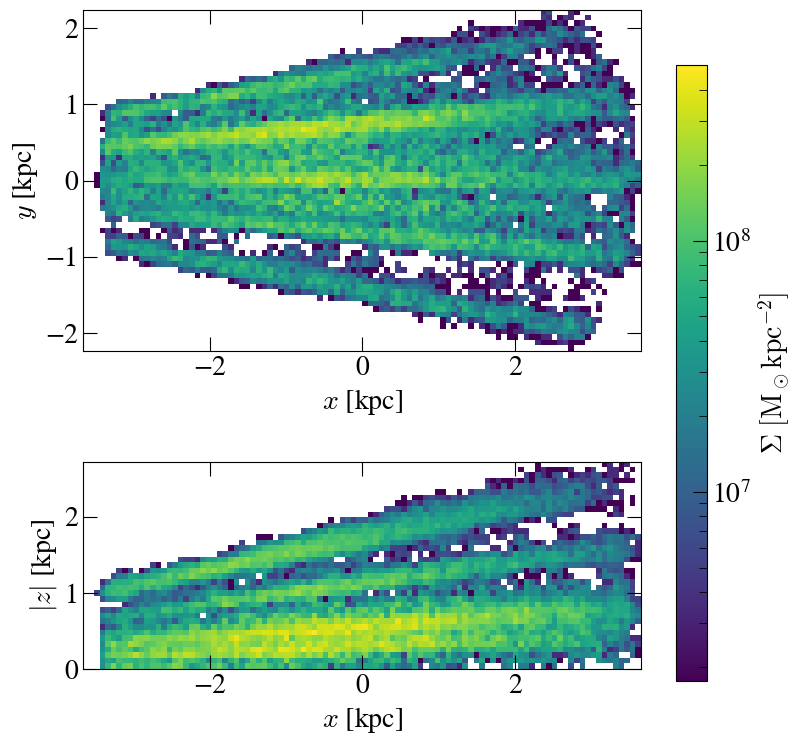

In [100]:
save_bool = True
# save_bool = False

if True: # xy and xz views
    fig,axs=plt.subplots(figsize=(9,10),nrows=2,gridspec_kw={"hspace":0})
    c1 = MP.quick_show_xy(sim_resampled,show=False)
    c2 = MP.quick_show_xz(sim_resampled,show=False,zmin=0)

    norm = PH.get_norm_from_count_list([c1,c2],log=True)

    MP.quick_show_xy(sim_resampled,ax=axs[0],norm=norm)
    MP.quick_show_xz(sim_resampled,ax=axs[1],norm=norm,zmin=0)

    plt.colorbar(cm.ScalarMappable(norm=norm,cmap="viridis"),ax=axs,shrink=0.8,label=mass_density_label)

    for ax in axs:
        ax.set_aspect("equal")

    if True: # filename and saving

        filename = f"resampled_sim_k{k}"

        print(filename)

        if save_bool:
            if os.path.isdir(f"{general_path}graphs/other_plots/"):
                save_path = f"{general_path}graphs/other_plots/"
            else:
                raise ValueError("Save path not specified")

            print("Saving in:",save_path)

            plt.savefig(save_path+filename+".png", dpi=200,bbox_inches="tight")

        plt.show()

In [ ]:
sim_resampled_bool = True

if sim_resampled_bool:
    df0 = sim_resampled

# Latitude

In [488]:
width_var = "l"
# width_var = "x"

x_var = "b"
# x_var = "z"

## Spatial cuts

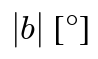

In [489]:
x_label = pos_symbols_dict[x_var] + f" [{pos_units_dict[x_var]}]"

MP.show_text(x_label)

In [544]:
extra_variable_lims = {
    "d": [6.1,10.1],
    "R": [0,3.5]
}

# CHOOSE
# extra_variable = "d"
extra_variable = "R"

lmin = -2
lmax = 2

extra_min,extra_max = extra_variable_lims[extra_variable]

print(lmin,lmax,extra_min,extra_max)

-2 2 0 3.5


latitude windows l|b| space

fig, ax = plt.subplots()

x_val = lmax
x = [-x_val,x_val,x_val,-x_val]
for b in b_range_plot:
    y = [b-b_step/2,b-b_step/2,b+b_step/2,b+b_step/2]
    ax.fill(x,y,color="lightsalmon",edgecolor='orangered',linewidth=3,alpha=0.3)
#ax.set_xlim(-4,4)
h = ax.hist2d(df0['l'],df0['b'],1000,norm=LogNorm())
#fig.colorbar(h[3])
x_lim = 9
ax.set_xlim(x_lim,-x_lim)#df0['l'].max(), df0['l'].min())
ax.set_ylim(0,9)
ax.set_yticks(np.arange(0,10,1))
ax.set_aspect('equal')
ax.set_xlabel(r"$l$ [$^\circ$]")
ax.set_ylabel(r"$|b|$ [$^\circ$]")
filename = f"lb_fields_xval{x_val}_sim_-9l9"
#plt.savefig(general_path+"trying_out_plots/"+filename+'.png',bbox_inches='tight',dpi=150)
plt.show()

In [545]:
bmin = 1.5
bmax = 13

## Sim

In [546]:
sim_bool = True

In [547]:
df_extra = df0[(df0["l"]>=lmin)&(df0["l"]<=lmax)&(df0[extra_variable]>=extra_min)&(df0[extra_variable]<=extra_max)&(df0["b"]>=bmin)&(df0["b"]<=bmax)]

### Age cuts

In [548]:
oscar_cuts = False

In [549]:
if oscar_cuts:
    young_min = 5
    young_max = 9
    old_min = 9.8
    old_max = 10
else:
    young_min = 4
    young_max = 7
    old_min = 9.5
    old_max = 10

age_limits = [[young_min,young_max],[old_min,old_max]]
print(age_limits)

df_ages = [df_extra[(df_extra["age"]>agelim[0])&(df_extra["age"]<agelim[1])] for agelim in age_limits]

[[4, 7], [9.5, 10]]


### Latitude binning

In [550]:
# Sim latitude range

# b_step = 1.5
n_edges = 7 if bmax == 9 else 8
n_points_sim = n_edges - 1

sim_b_edges = np.linspace(bmin,bmax,n_edges)

sim_b_range_min = sim_b_edges[:-1]
sim_b_range_max = sim_b_edges[1:]

sim_b_range_plot = (sim_b_range_max - sim_b_range_min)/2 + sim_b_range_min

print("Plotting at:",sim_b_range_plot)
print("Number of datapoints:",n_points_sim)

Plotting at: [ 2.32142857  3.96428571  5.60714286  7.25        8.89285714 10.53571429
 12.17857143]
Number of datapoints: 7


## Data

n_gaussians = np.arange(1,number_of_gaussians+1)

models = [GaussianMixture(n_gauss).fit(X) for n_gauss in n_gaussians]
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(n_gaussians,AIC,'k')
ax.plot(n_gaussians,BIC,'--k')
plt.show()

In [551]:
data_bool = True

### Trim & spatial cut

In [552]:
# metal_lowcut = -9999
metal_lowcut = -1

data_trim = data[data['FeH']>=metal_lowcut]

print(f"Chose minimum metallicity of {metal_lowcut}" if metal_lowcut != -9999 else "No minimum metallicity")

if metal_lowcut != -9999:
    print(f"Removed {len(data)-len(data_trim)} ({MF.return_int_or_dec((len(data)-len(data_trim))/len(data)*100,2)}%) stars. {len(data_trim)} left")

Chose minimum metallicity of -1
Removed 548 (5.23%) stars. 9938 left


In [553]:
o_df_extra = data_trim[(data_trim["l"]>=lmin)&(data_trim["l"]<=lmax)\
                       &(data_trim["b"]>=bmin)&(data_trim["b"]<=bmax)\
                       &(data_trim[extra_variable]>=extra_min)&(data_trim[extra_variable]<=extra_max)]

print(len(o_df_extra))

2480


### Metallicity cuts

In [554]:
metallicity_median = MF.return_int_or_dec(np.median(data_trim["FeH"]),2)
print(metallicity_median,np.sum(data_trim['FeH']<metallicity_median),np.sum(data_trim['FeH']>metallicity_median))

-0.21 4933 5005


In [555]:
halo_bool = False

metal_poor_lowlim = None
metal_poor_highlim = metallicity_median

metal_rich_lowlim = metallicity_median
metal_rich_highlim = None

In [556]:
if metal_rich_highlim is None:
    rich_condition = o_df_extra["FeH"] > metal_rich_lowlim
    label_rich = fr'[Fe/H]$>{str(metal_rich_lowlim)}$'
else:
    rich_condition = (o_df_extra["FeH"] < metal_rich_highlim)&(o_df_extra["FeH"] > metal_rich_lowlim)
    label_rich = fr'${str(metal_rich_lowlim)}<$[Fe/H]/dex$<{str(metal_rich_highlim)}$'
    
if metal_poor_lowlim is None:
    poor_condition = o_df_extra["FeH"] < metal_poor_highlim
    label_poor = fr'[Fe/H]$<{str(metal_poor_highlim)}$'
else:
    poor_condition = (o_df_extra["FeH"] < metal_poor_highlim)&(o_df_extra["FeH"] > metal_poor_lowlim)
    label_poor = fr'${str(metal_poor_lowlim)}<$[Fe/H]$<{str(metal_poor_highlim)}$'

df_metals = [o_df_extra[rich_condition], o_df_extra[poor_condition]]
label_rich += f" ({len(df_metals[0])})"
label_poor += f" ({len(df_metals[1])})"

print("Poor",label_poor)
print("Rich",label_rich)

if halo_bool:
    df_metals.append(o_df_extra[o_df_extra["FeH"] < metal_poor_lowlim])    
    label_halo = fr'[Fe/H]/dex$<{metal_poor_lowlim}$'
    o_pop_strings.append(f"[FeH]{metal_poor_lowlim}")
    print("Working with the halo population")
    print(label_halo)

Poor [Fe/H]$<-0.21$ (1244)
Rich [Fe/H]$>-0.21$ (1236)


In [557]:
def get_metal_distribution_path():

    metal_distribution_path = general_path + "graphs/Observations/Apogee/"
    MF.create_dir(metal_distribution_path)

    # metal_distribution_path += "scaling_"+str(sim_scaling)+'/'
    # MF.create_dir(metal_distribution_path)

    metal_distribution_path += "individual_variable/"
    MF.create_dir(metal_distribution_path)

    metal_distribution_path += "latitude/"
    MF.create_dir(metal_distribution_path)
    
    metal_distribution_path += "gaiaDR3/"
    MF.create_dir(metal_distribution_path)

    metal_distribution_path += f"{lmin}l{lmax}/"
    MF.create_dir(metal_distribution_path)

    metal_distribution_path += f"{bmin}b{bmax}/"
    MF.create_dir(metal_distribution_path)

    metal_distribution_path += f"extra_{extra_variable}/"
    MF.create_dir(metal_distribution_path)

    metal_distribution_path += f"{extra_min}{extra_variable}{extra_max}/"
    MF.create_dir(metal_distribution_path)

    metal_distribution_path += f"{young_min}-{young_max}_{old_min}-{old_max}/"
    MF.create_dir(metal_distribution_path)

    #metal_distribution_path += 'halo_metal/'
    #create_dir(metal_distribution_path)

    # if not galactocentric:
    #     metal_distribution_path += 'LSR/'
    #     MF.create_dir(metal_distribution_path)

    if metal_lowcut != None:
        metal_distribution_path += f"{metal_lowcut}metal/"
        MF.create_dir(metal_distribution_path)

    metal_distribution_path += f"{str(metal_rich_lowlim)}to{str(metal_rich_highlim)}_{str(metal_poor_lowlim)}to{str(metal_poor_highlim)}/"
    MF.create_dir(metal_distribution_path)

    if halo_bool:
        df_metals.append(o_df_extra[o_df_extra["FeH"] < metal_halo_lim])    
        label_halo = fr'(%i) [Fe/H]$<{metal_halo_lim}$'%len(df_metals[2])
        print("Working with the halo population")
        
    return metal_distribution_path

metal_distribution_path = get_metal_distribution_path()
print(metal_distribution_path)

/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/


/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/metallicity_distribution_-0.21toNone_Noneto-0.21.png


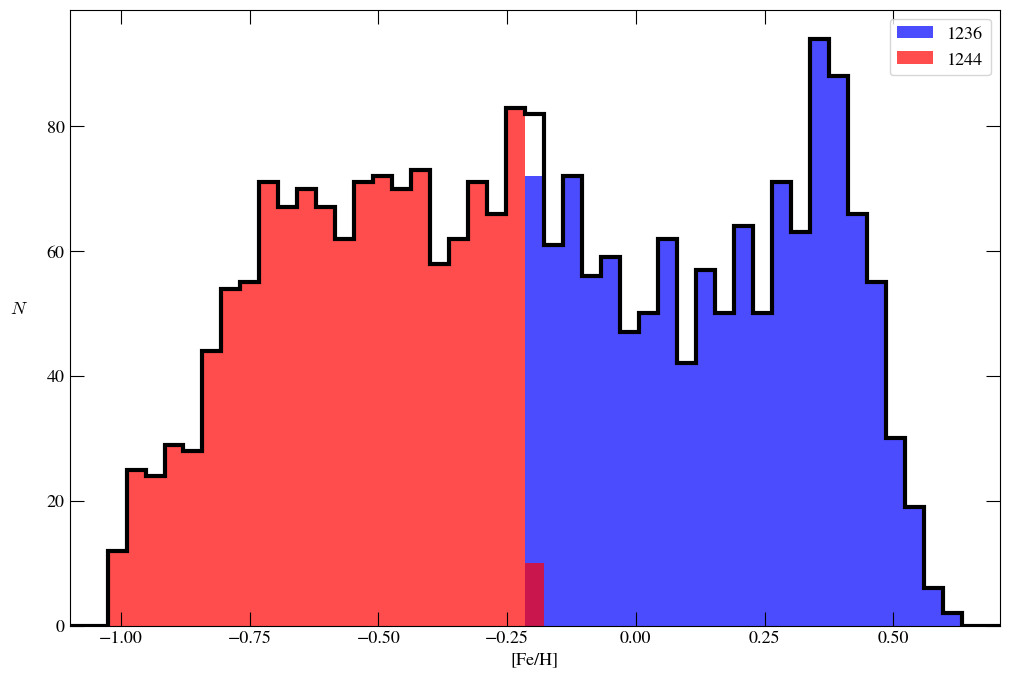

In [558]:
# plot

fig, ax = plt.subplots()
xmin=o_df_extra['FeH'].min() - 0.1
xmax=o_df_extra['FeH'].max() + 0.1
bins = np.linspace(xmin,xmax,50)
alpha=0.7
ax.hist(o_df_extra['FeH'],bins=bins,histtype='step',linewidth=3,color='black')
ax.hist(df_metals[0]['FeH'],bins=bins,color='blue',alpha=alpha,label=len(df_metals[0]))
ax.hist(df_metals[1]['FeH'],bins=bins,color='red',alpha=alpha,label=len(df_metals[1]))

#x_gauss = np.linspace(xmin,xmax,300)
#mean_c,std_c = -0.6, 0.25
#mean_b,std_b = -0.22, 0.13
#mean_a,std_a = 0.4, 0.13
#ax.plot(x_gauss,45*np.exp(-(x_gauss-mean_c)**2/std_c**2),linewidth=4,color='red',label='C')
#ax.plot(x_gauss,45*np.exp(-(x_gauss-mean_b)**2/std_b**2),linewidth=4,color='purple',label='B')
#ax.plot(x_gauss,50*np.exp(-(x_gauss-mean_a)**2/std_a**2),linewidth=4,color='blue',label='A')

ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'$N$',rotation=0,labelpad=20)
ax.set_xlim(xmin,xmax)
# ax.text(0.05,0.7,r"$%s <l \hspace{0.2}[^\circ]< %s$"%(str(MF.check_int(lmin)),str(MF.check_int(lmax))),transform=ax.transAxes)
# ax.text(0.07,0.65,r"$%s < d \hspace{0.2}[\mathrm{kpc}]< %s$"%(str(MF.check_int(dmin)),str(MF.check_int(dmax))),transform=ax.transAxes)
plt.legend()
filename = f"metallicity_distribution_{str(metal_rich_lowlim)}to{str(metal_rich_highlim)}_{str(metal_poor_lowlim)}to{str(metal_poor_highlim)}"
plt.savefig(metal_distribution_path+filename+".png",dpi=150)
print(metal_distribution_path+filename+".png")
plt.show()

### Latitude binning

/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/number_observations_-2l2_0R3.5.png


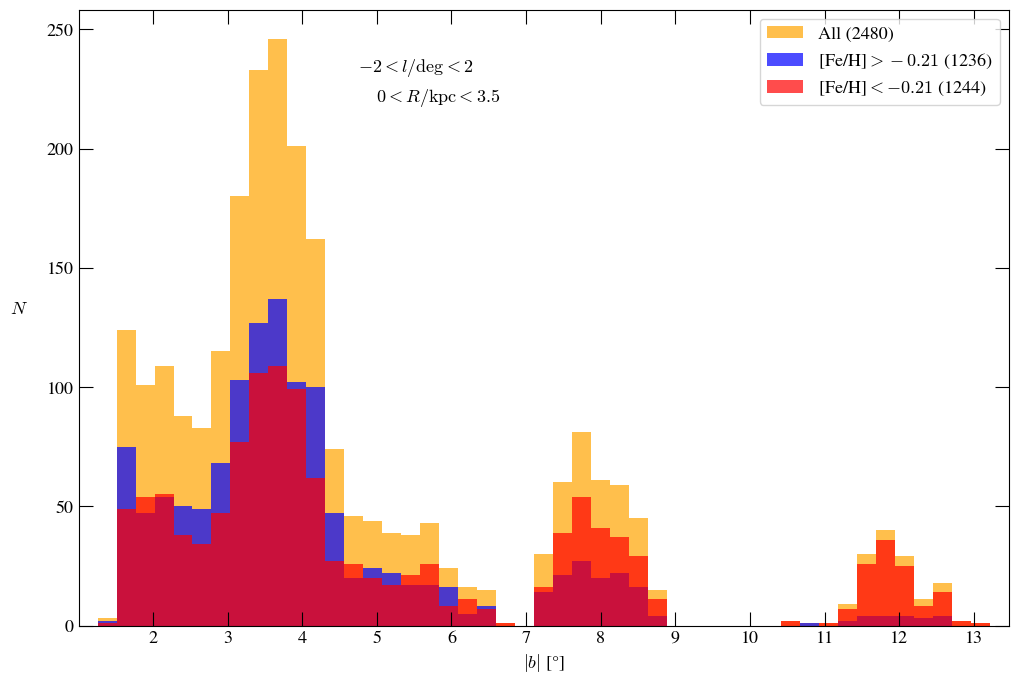

In [559]:
# plot

fig, ax = plt.subplots()

alpha=0.7
xmin = o_df_extra['b'].min() - 0.5
xmax = o_df_extra['b'].max() + 0.5
bins = np.linspace(xmin,xmax,50)
if not halo_bool:
    ax.hist(o_df_extra['b'],bins=bins,label='All (%i)'%len(o_df_extra['b']),alpha=alpha,color='orange')
ax.hist(df_metals[0]['b'],bins=bins,label=label_rich,alpha=alpha,color='blue')
ax.hist(df_metals[1]['b'],bins=bins,label=label_poor,alpha=alpha,color='red')

if halo_bool:
    ax.hist(df_metals[2]['b'],bins=bins,label=label_halo,alpha=alpha*0.75,color='cyan')
ax.set_xlim(xmin,xmax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel(x_label)
ax.set_ylabel(r"$N$",rotation=0,labelpad=20)
ax.legend()
x_text = 0.05 if bmax == 9 else 0.3
ax.text(x_text,0.9,r"$%s <l/\mathrm{deg}< %s$"%(str(MF.check_int(lmin)),str(MF.check_int(lmax))),transform=ax.transAxes)
ax.text(x_text+0.02,0.85,r"$%s < R/\mathrm{kpc}< %s$"%(str(MF.check_int(extra_min)),str(MF.check_int(extra_max))),transform=ax.transAxes)
filename = f"number_observations_{lmin}l{lmax}_{extra_min}{extra_variable}{extra_max}"
plt.savefig(metal_distribution_path+filename+".png",bbox_inches='tight',dpi=150)
print(metal_distribution_path+filename+".png")
plt.show()

In [560]:
equal_number = False # divide in equal-number bins across all b
equal_number_low = True # divide in equal-number bins below |b|<6.61˚
custom_range = False
equal_steps = False # divide in constant latitude steps

plot_median_bool = True
# plot_median_bool = False # mid-point of bin

n_points_data = 3
n_points_data += 1 if bmax == 13 else 0

print(f"{n_points_data} total points")

4 total points


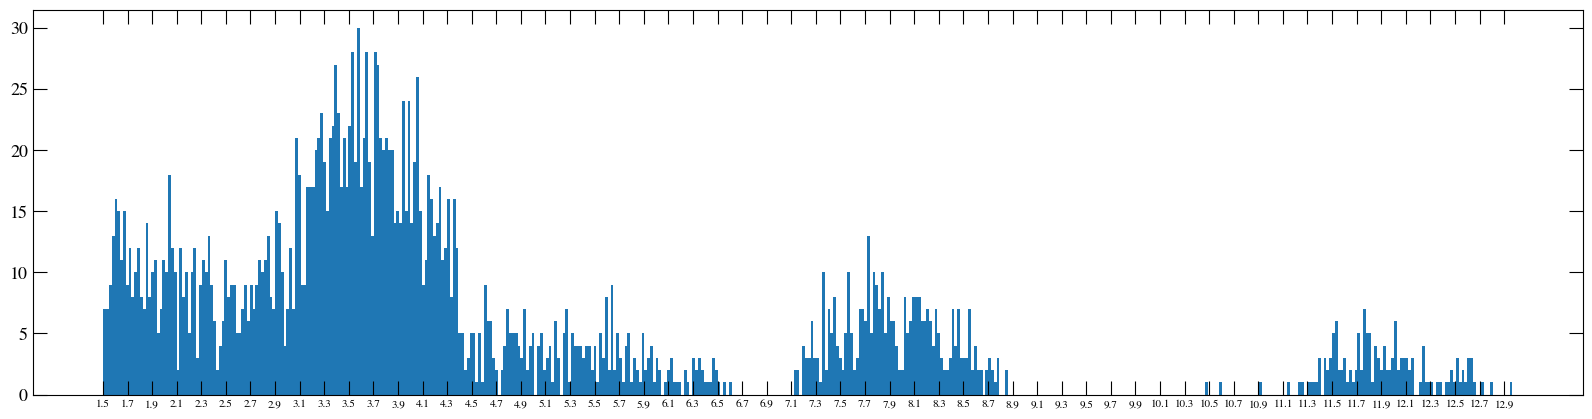

In [561]:
fig,ax=plt.subplots(figsize=(20,5))
ax.hist(o_df_extra["b"],bins=500)
ticksss = np.arange(bmin,bmax,0.2)
ax.set_xticks(ticksss)
ax.set_xticklabels(labels=[str(np.float32(t)) for t in ticksss],size=8)
plt.show()

In [562]:
assert equal_number+equal_number_low+custom_range+equal_steps == 1, "Choose a single range selection"

if equal_number:
    o_b_range_min = PH.get_equal_n_bin_edges(o_df_extra.b.values, n_points_data)
    o_b_range_max = o_b_range_min[1:]
    o_b_range_min = o_b_range_min[:-1]
    
    range_path = ""
    
if equal_number_low:
    low_max = np.max(o_df_extra[o_df_extra["b"]<6.8]["b"])
    n_points_low = n_points_data-2 if bmax == 13 else n_points_data-1
    edges_low = PH.get_equal_n_bin_edges(o_df_extra[o_df_extra["b"]<=low_max].b.values, n_points_low)
    
#     print(edges_low)
    
    high_min = np.min(o_df_extra[o_df_extra["b"]>6.8]["b"])
    high_max = np.max(o_df_extra[o_df_extra["b"]<9]["b"])
    
    o_b_range_min = list(edges_low[:-1]) + [high_min]
    o_b_range_max = list(edges_low[1:]) + [high_max]
    
#     print(o_b_range_min,o_b_range_max)
    
    if bmax == 13:
        higher_min = np.min(o_df_extra[o_df_extra["b"]>9]["b"])
        higher_max = np.max(o_df_extra["b"])
        
        o_b_range_min += [higher_min]
        o_b_range_max += [higher_max]
        
    o_b_range_min = np.array(o_b_range_min)
    o_b_range_max = np.array(o_b_range_max)
    
elif custom_range:
    range_dict = {
        '1min': [0.5,  2.5,  4,    7],
        '1max': [2.5,  4,    6.1,  9],

        '1.5min': [0.5,2.5,4,7],
        '1.5max': [2.5,4,6.2,9],

        '2min': [1,2.5,4,7.1],
        '2max': [2.5,4,6.61,9]
    }
    
    if bmax==13:
        range_dict["2min"] += [10.4]
        range_dict["2max"] += [13]
    
    o_b_range_min = range_dict[str(lmax)+'min']
    o_b_range_max = range_dict[str(lmax)+'max']
    
    n_points_data = len(o_b_range_plot)
    
elif equal_steps:
    o_b_edges = np.linspace(bmin,bmax,n_points_data)
    o_b_range_min = o_b_edges[:-1]
    o_b_range_max = o_b_edges[1:]

if plot_median_bool:
    o_b_range_plot = PH.get_range_medians(o_df_extra.b.values, o_b_range_min, o_b_range_max)
else:
    o_b_range_plot = np.array([np.mean([m,M]) for m,M in zip(o_b_range_min,o_b_range_max)])
    
print("Plotting at:",o_b_range_plot,"\n")

def get_save_path_bins():
    range_str = np.array(["equal_number","equal_number_low","custom_range","steps"])[np.array([equal_number,equal_number_low,custom_range,equal_steps])][0]
    save_path_bins = metal_distribution_path + f"{range_str}/"
    MF.create_dir(save_path_bins)

    save_path_bins += f"{n_points_data}_points_data/"
    MF.create_dir(save_path_bins)
            
    return save_path_bins

save_path_bins = get_save_path_bins()
print(save_path_bins)

with open(save_path_bins+'o_latitude_cuts.txt','w') as f:
    f.write("min-max->plot\n")
    for mini,maxi,plot in zip(o_b_range_min,o_b_range_max,o_b_range_plot):
        f.write(f"{mini}-{maxi}->{plot}\n")

Plotting at: [ 2.75060766  4.05957166  7.89000127 11.85697824] 

Created successfully
Created successfully
/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/


Saved /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/data_chosenRanges.png


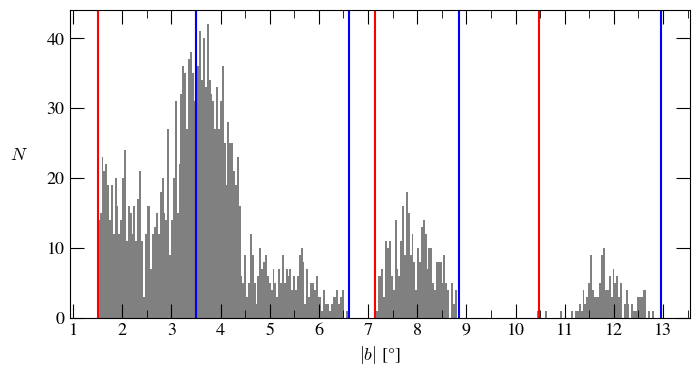

In [563]:
MP.visualise_1D_binning(o_df_extra["b"], o_b_range_min, o_b_range_max, hist_bins=300, save_bool=True,save_path=save_path_bins,\
                        filename_prefix="data",xlabel=x_label)

## Get arrays

In [564]:
bootstrap_repeat = 500

In [565]:
def get_save_path():
    save_path = save_path_bins + f"{n_points_sim}_points_sim/"
    MF.create_dir(save_path)
    
    if bootstrap_repeat != 500:
        save_path += f"boot{bootstrap_repeat}/"
        MF.create_dir(save_path)
    
    if not plot_median_bool:
        save_path += "obs_midpoint/"
        MF.create_dir(save_path)
        
    return save_path
    
save_path = get_save_path()
print(save_path)

Created successfully
/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/


In [566]:
all_maps = False

full_map_string_list = [map_string for map_string in full_map_string_list if "spherical" not in map_string]

### sim

Saved /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/sim_chosenRanges.png


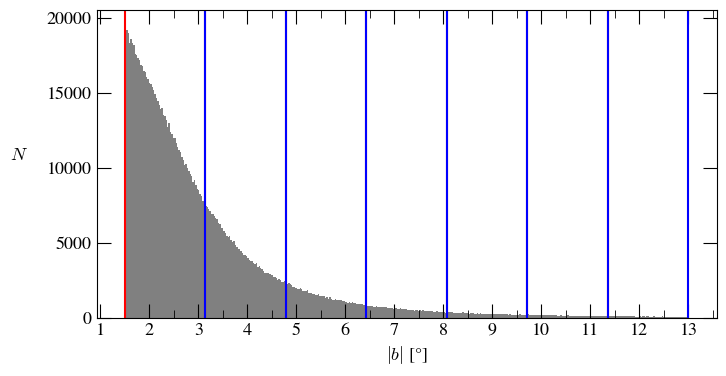

Saved /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/sim_chosenRanges_log.png


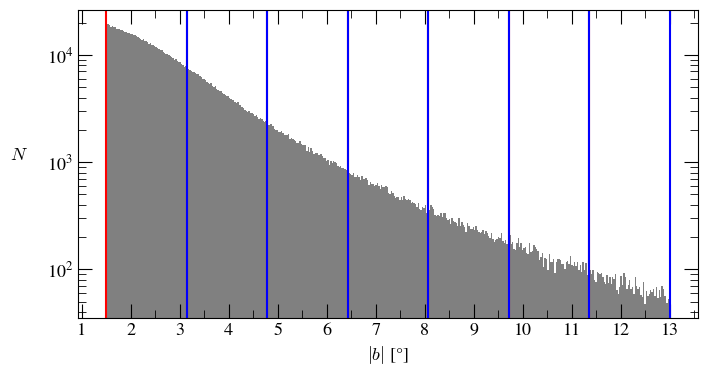

In [567]:
# Save simulation latitude cuts plot

save_path_sim_lat_plot = save_path.split("points_sim")[0] + "points_sim/"

MP.visualise_1D_binning(df_extra["b"], sim_b_range_min,bin_edges_max=sim_b_range_max,save_bool=True,save_path=save_path_sim_lat_plot,\
                     hist_bins=400,filename_prefix="sim",xlabel=x_label,log=False)

MP.visualise_1D_binning(df_extra["b"], sim_b_range_min,bin_edges_max=sim_b_range_max,save_bool=True,save_path=save_path_sim_lat_plot,\
                     hist_bins=400,filename_prefix="sim",xlabel=x_label,log=True)

In [568]:
min_number_sim = 100

plotting_velocity_graphs = False
#########latitude_velocity_plot = [-1] #slice(0,len(n_points_sim))
#########save_path_vel = save_path + 'velocities/'
#########create_dir(save_path_vel)

Created successfully
Saving velocity histograms on
 /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/vel_histograms/sim/100bins/
velhists_meanstdx_example


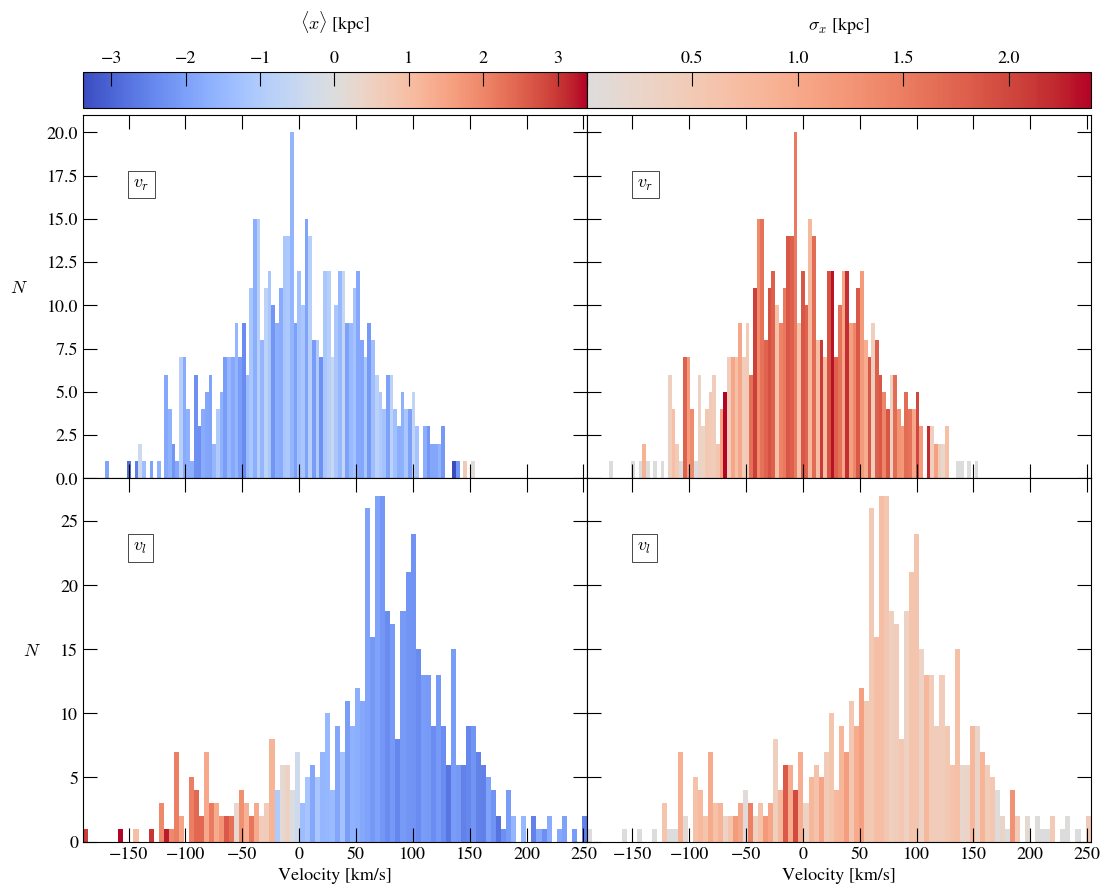

In [571]:
vel_hist_bool = True
# vel_hist_bool = False

velhist_bins_s = 100

if vel_hist_bool:
    save_path_hist = save_path + "vel_histograms/"
    MF.create_dir(save_path_hist)
    
    save_path_hist += "sim/"
    MF.create_dir(save_path_hist)
    
    save_path_hist += f"{velhist_bins_s}bins/"
    MF.create_dir(save_path_hist)
    
    print("Saving velocity histograms on\n",save_path_hist)

MP.plot_velocity_histograms_both_stats(df_ages[0][(df_ages[0][x_var]>max(sim_b_range_min))&(df_ages[0][x_var]<max(sim_b_range_max))],\
                                       vel_x_variable,vel_y_variable,bins=velhist_bins_s,suffix="example",verbose=True,show=True)

In [572]:
map_dict = {}
for map_string in full_map_string_list:
    map_dict[map_string] = np.zeros(shape=(n_points_sim,len(df_ages)))

if plotting_velocity_graphs:
    velocity_limits = [np.nanmin([df0.vr.values, df0.vl.values]), np.nanmax([df0.vr.values, df0.vl.values])]
    vel_min = -1.1*np.max(np.abs(velocity_limits))
    vel_max = 1.1*np.max(np.abs(velocity_limits))
    vel_index=0
    
for b_index,(lat_min,lat_max) in enumerate(zip(sim_b_range_min,sim_b_range_max)):
    print(lat_min,lat_max)
    
    for age_index,df in enumerate(df_ages):
        
        if b_index == len(sim_b_range_min) - 1:
            df_b = df[(df['b']>=lat_min)&(df['b']<=lat_max)]
        else:
            df_b = df[(df['b']>=lat_min)&(df['b']<lat_max)]
        
        if vel_hist_bool:
            name_suffix = ["young","old"][age_index]
            name_suffix += f"_{str(MF.return_int_or_dec(lat_min,dec=2))}{x_var}{str(MF.return_int_or_dec(lat_max,dec=2))}"
            MP.plot_velocity_histograms_both_stats(df_b,vel_x_variable,vel_y_variable,save_bool=True,save_path=save_path_hist,suffix=name_suffix,verbose=b_index+age_index==0,bins=velhist_bins_s)
        
        values_x = val_err.get_all_variable_values_and_errors(df_b[f"v{vel_x_variable}"].values,df_b[f"v{vel_y_variable}"].values, full_map_string_list, all_maps=False,\
                                                              repeat=bootstrap_repeat, min_number = min_number_sim)
            
        if len(values_x) != len(full_map_string_list):
            raise ValueError("The length of the values_x list does not match the string list!")
        
        if plotting_velocity_graphs and latitude in latitude_velocity_plot:
            age_string = 'young' if age_index == 0 else 'old'
            save_contour_velocity_plot(save_path_vel, vr, vl, \
                                       vel_limits = [vel_min,vel_max], \
                                       limits = [np.min([latitude,latitude+b_step]),np.max([latitude,latitude+b_step])], \
                                       index=vel_index, vertex=vertex, error=vertex_error, \
                                       star_number=number, age_string=age_string)
            vel_index += 1
        
        for map_string in full_map_string_list:
            map_dict[map_string][b_index,age_index] = values_x[map_string]
    
del df_b
print("Done")

1.5 3.142857142857143
velhists_meanstdx_young_1.5b3.14
Saved in /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/vel_histograms/sim/100bins/
3.142857142857143 4.785714285714286
4.785714285714286 6.428571428571429
6.428571428571429 8.071428571428571
8.071428571428571 9.714285714285714
9.714285714285714 11.357142857142858
11.357142857142858 13.0
Done


In [573]:
map_dict["number"]

array([[140031., 252493.],
       [ 23531., 100949.],
       [  6735.,  31472.],
       [  3294.,  10547.],
       [  1755.,   4353.],
       [   938.,   2012.],
       [   572.,   1027.]])

#### With distance division

In [144]:
d_range = np.linspace(dmin,dmax,5)[:-1]
d_step = np.diff(d_range)[0]

# d_range = [6]
# d_step = 4

print(d_range,d_step)

[7.  7.5 8.  8.5] 0.5


In [145]:
all_arrays = np.zeros(shape=(7,len(b_range),len(df_ages)))
variables = ["vertex_abs", "anisotropy", "correlation"]
 
for b_index,latitude in enumerate(b_range):
    for age_index,df in enumerate(df_ages):
        df_b = df[(df['b']>latitude)&(df['b']<latitude+b_step)]
        df_b = df[(df['b']>latitude)&(df['b']<latitude+b_step)]
        
        values_d = []
        for d_index, distance in enumerate(d_range):
            vr = df_b[(df_b['d']>distance)&(df_b['d']<distance+d_step)].vr.values
            vl = df_b[(df_b['d']>distance)&(df_b['d']<distance+d_step)].vl.values

            values_d.append(get_all_variable_values_and_errors(vr,vl,bootstrap_repeat=100,min_number=min_number_sim))
        
        values_d = np.array(values_d)
        values = []
        
        for var in variables:
            val_index = np.where(full_map_string_list == var)[0][0]
            err_index = np.where(full_map_string_list == (var+"_error"))[0][0]
            
            mean_variance = 1/np.sum(1/values_d[:,err_index]**2)
            mean = mean_variance*np.sum(values_d[:,val_index]/values_d[:,err_index]**2)
            values.append(mean)
            values.append(np.sqrt(mean_variance))
                
        for index, val in enumerate(values):
            all_arrays[index, b_index, age_index] = val
    
print("Done")

Done


In [148]:
full_d_variables = []
for i in variables:
    full_d_variables.append(i)
    full_d_variables.append(i+'_error')

d_map_dict = {}
for variable, array in zip(full_d_variables,all_arrays):
    d_map_dict[variable] = array

In [149]:
var = 'vertex_abs'

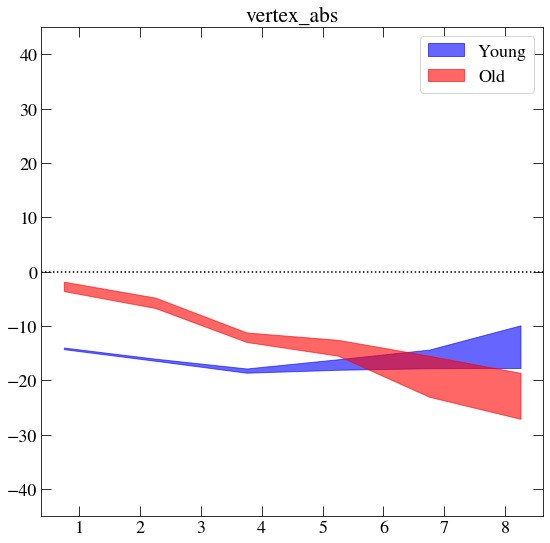

In [152]:
fig, ax = plt.subplots()

if var == 'vertex_abs':
    ax.set_ylim(-45,45)
else:
    max_val = np.max(np.abs(map_dict[var])) + 0.05
#     ax.set_ylim(-max_val,max_val)
    ax.set_ylim(-0.7,0.5)
ax.fill_between(x=b_range_plot,y1=map_dict[var][:,0]-map_dict[var+'_error'][:,0],y2=map_dict[var][:,0]+map_dict[var+'_error'][:,0],color='blue',alpha=0.6,label='Young')
ax.fill_between(x=b_range_plot,y1=map_dict[var][:,1]-map_dict[var+'_error'][:,1],y2=map_dict[var][:,1]+map_dict[var+'_error'][:,1],color='red',alpha=0.6,label='Old')
ax.axhline(y=0,color='black',linestyle='dotted')
ax.set_title(var)
plt.legend(loc='best')
plt.show()

save_path_arrays = save_path + "arrays/"
if not os.path.isdir(save_path_arrays):
    os.mkdir(save_path_arrays)
    
    for map_string in full_map_string_list:
        np.save(save_path_arrays+"708main_"+map_string, map_dict[map_string])
    print("Arrays saved in",save_path_arrays)

### Data

In [574]:
min_star_number_o = 50

#Decide whether to plot velocity graphs
o_plotting_velocity_graphs = False
#o_latitude_velocity_plot = o_b_range[:-1] #[-1] #slice(0,len(b_range))

Created successfully
Created successfully
Saving velocity histograms to
 /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/vel_histograms/data/50bins/
velhists_meanstdx_example


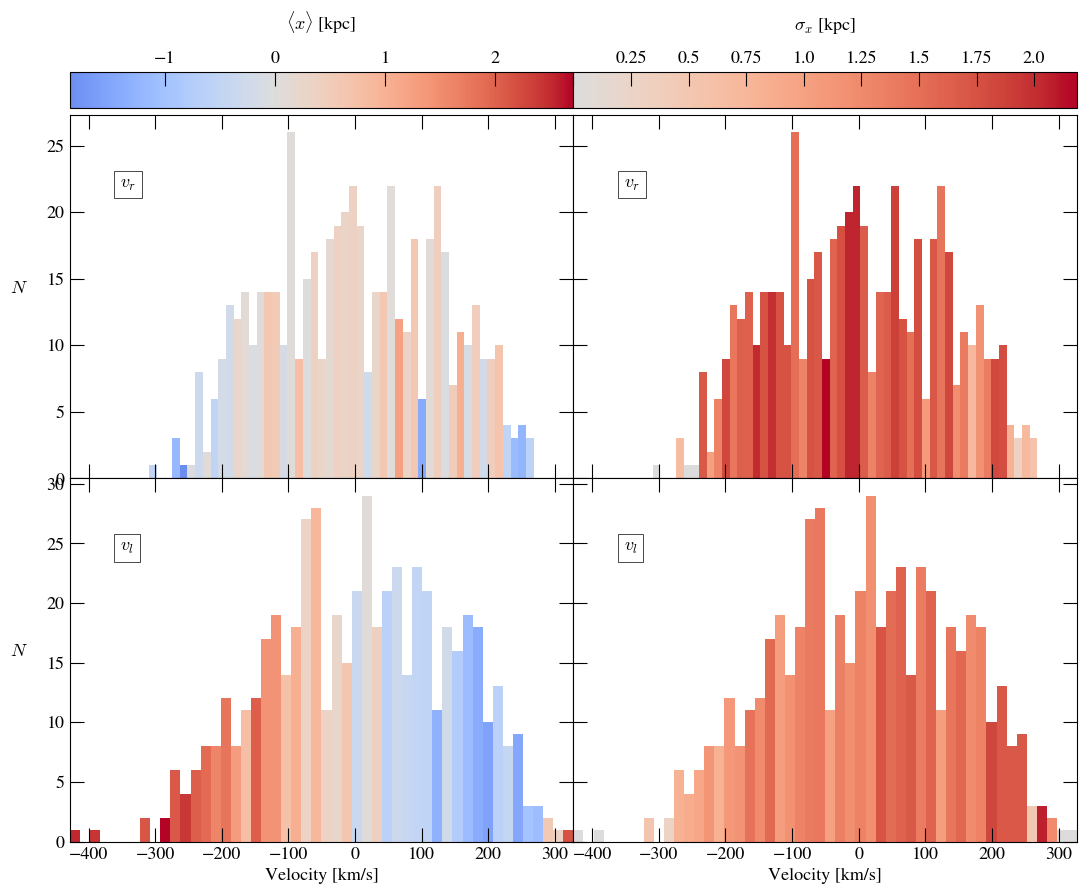

In [575]:
vel_hist_bool = True
# vel_hist_bool = False

velhist_bins_o = 50

if vel_hist_bool:
    o_save_path_hist = save_path + "vel_histograms/"
    MF.create_dir(o_save_path_hist)
    
    o_save_path_hist += "data/"
    MF.create_dir(o_save_path_hist)
    
    o_save_path_hist += f"{velhist_bins_o}bins/"
    MF.create_dir(o_save_path_hist)
    
    print("Saving velocity histograms to\n",o_save_path_hist)

MP.plot_velocity_histograms_both_stats(df_metals[0][(df_metals[0][x_var]>min(o_b_range_min))&(df_metals[0][x_var]<min(o_b_range_max))],\
                                       vel_x_variable,vel_y_variable,bins=velhist_bins_o,suffix="example",verbose=True,show=True)

In [576]:
o_map_dict = {}
for map_string in full_map_string_list:
    o_map_dict[map_string] = np.zeros(shape=(len(o_b_range_plot),len(df_metals)))

for b_index, (lat_min,lat_max) in enumerate(zip(o_b_range_min,o_b_range_max)):
    print(lat_min,lat_max)
    
    for metal_index,df in enumerate(df_metals):

        if lat_max == low_max:
            o_df_b = df[(df['b']>=lat_min)&(df['b']<=lat_max)]
        else:
            o_df_b = df[(df['b']>=lat_min)&(df['b']<lat_max)]
        
        if vel_hist_bool:
            name_suffix = ["rich","poor"][metal_index]
            name_suffix += f"_{str(MF.return_int_or_dec(lat_min,dec=2))}{x_var}{str(MF.return_int_or_dec(lat_max,dec=2))}"
            MP.plot_velocity_histograms_both_stats(o_df_b,vel_x_variable,vel_y_variable,save_bool=True,save_path=o_save_path_hist,suffix=name_suffix,verbose=b_index+metal_index==0,bins=velhist_bins_o)
        
        o_values_x = val_err.get_all_variable_values_and_errors(o_df_b[f"v{vel_x_variable}"].values,o_df_b[f"v{vel_y_variable}"].values, full_map_string_list,\
                                                                repeat=bootstrap_repeat, min_number = min_star_number_o)                
            
        if len(o_values_x) != len(full_map_string_list):
            raise ValueError("The length of the values_x list does not match the string list!")

        for map_string in full_map_string_list:
            o_map_dict[map_string][b_index, metal_index] = o_values_x[map_string]
    
del o_df_b,df
print("Done")

1.50302473865 3.5088246784
velhists_meanstdx_rich_1.5b3.51
Saved in /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/vel_histograms/data/50bins/
3.5088246784 6.60454476177
7.13475639098 8.85301437083
10.4707230211 12.9671218433
Found `22` stars, less than the min of `50`
Done


In [577]:
print(o_map_dict['number'],np.sum(o_map_dict["number"],axis=1))

[[551. 441.]
 [539. 454.]
 [124. 226.]
 [ 22. 121.]] [992. 993. 350. 143.]


## Save arrays

In [578]:
# save arrays

array_path = save_path + "arrays/"
MF.create_dir(array_path)

if True: # values as .txt
    
    with open(array_path+'o_values.txt','w') as f:
        for key in o_map_dict:
            f.write(key+'\n')
            np.savetxt(f,o_map_dict[key],fmt='%.5f')
            f.write('\n')
            
    with open(array_path+'sim_values.txt','w') as f:
        for key in map_dict:
            f.write(key+'\n')
            np.savetxt(f,map_dict[key],fmt='%.5f')
            f.write('\n')
        
if True: # values as .npy
    for map_string in full_map_string_list:
        np.save(array_path+"sim_"+map_string, map_dict[map_string])
        np.save(array_path+"o_"+map_string, o_map_dict[map_string])
        
if True: # latitude plot limits as .npy
    np.save(array_path+"sim_b_range_min", sim_b_range_min)
    np.save(array_path+"sim_b_range_max", sim_b_range_max)
    np.save(array_path+"sim_b_range_plot", sim_b_range_plot)
    
    np.save(array_path+"o_b_range_min", o_b_range_min)
    np.save(array_path+"o_b_range_max", o_b_range_max)
    np.save(array_path+"o_b_range_plot", o_b_range_plot)
    
print("Saved .txt and .npy in",array_path)

Created successfully
Saved .txt and .npy in /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/arrays/


## BT repeat
The standard deviation is the deviation from the mean. We are not calculating the vertex deviation's standard deviation from the mean bootstrap vertex, but from the true vertex instead.
Therefore, let's analyse how much these two values, $l_\mathrm{v}$ and $\langle l_{\mathrm{v}}^\mathrm{bootstrap}\rangle$, differ for different choices of bootstrap repetitions.

To run the code below, you first have to change the definition of get_std_bootstrap() and get_vertex_std_bootstrap() so that they return the list of bootstrap values

In [121]:
min_number = 100

In [127]:
bootstrap_repeats = np.array([100,500,1000,5000,10000,50000])
ani_diff,corr_diff,vertex_diff = [[] for repeat in bootstrap_repeats],[[] for repeat in bootstrap_repeats],[[] for repeat in bootstrap_repeats]

df = df_ages[1] ###
for b_index,latitude in enumerate(b_range):
    start = time.time()
    #for age_index,df in enumerate(df_ages):
    
    vr = df[(df['b']>latitude)&(df['b']<latitude+b_step)].vr.values
    vl = df[(df['b']>latitude)&(df['b']<latitude+b_step)].vl.values

    number = len(vr)

    if number > min_number:

        cov = np.cov(vr,vl)

        true_anisotropy = 1-cov[1,1]/cov[0,0]
        true_correlation = cov[0,1]/np.sqrt(cov[0,0]*cov[1,1])
        true_vertex = np.degrees(np.arctan2(2.*cov[0,1], cov[0,0]-cov[1,1])/2.)

        for repeat_index, bootstrap_repeat in enumerate(bootstrap_repeats):

            anisotropy_boot_values,_ = get_std_bootstrap(vr,vl,calculate_anisotropy,repeat=bootstrap_repeat)
            correlation_boot_values,_ = get_std_bootstrap(vr,vl,calculate_correlation,repeat=bootstrap_repeat)
            vertex_boot_values,_ = get_vertex_std_bootstrap(vr, vl, repeat=bootstrap_repeat)

            ani_diff[repeat_index].append(np.abs(true_anisotropy-np.mean(anisotropy_boot_values)))
            corr_diff[repeat_index].append(np.abs(true_correlation-np.mean(correlation_boot_values)))
            vertex_diff[repeat_index].append(np.abs(true_vertex-np.mean(vertex_boot_values)))

            print("Done with repeat",bootstrap_repeat)
                
    print("Done with latitude index",b_index)
    end = time.time()
    print("Took",(end-start)/60,"minutes")

Done with repeat 100
Done with repeat 500
Done with repeat 1000
Done with repeat 5000
Done with repeat 10000
Done with repeat 50000
Done with latitude index 0
Took 37.872472846508025 minutes
Done with repeat 100
Done with repeat 500
Done with repeat 1000
Done with repeat 5000
Done with repeat 10000
Done with repeat 50000
Done with latitude index 1
Took 34.081631882985434 minutes
Done with repeat 100
Done with repeat 500
Done with repeat 1000
Done with repeat 5000
Done with repeat 10000
Done with repeat 50000
Done with latitude index 2
Took 12.545932479699452 minutes
Done with repeat 100
Done with repeat 500
Done with repeat 1000
Done with repeat 5000
Done with repeat 10000
Done with repeat 50000
Done with latitude index 3
Took 3.866548144817352 minutes
Done with repeat 100
Done with repeat 500
Done with repeat 1000
Done with repeat 5000
Done with repeat 10000
Done with repeat 50000
Done with latitude index 4
Took 2.1666344165802003 minutes
Done with repeat 100
Done with repeat 500
Done

### Plot

In [113]:
diff_variable = "vertex"

In [128]:
diffs_dict = {
    "anisotropy": ani_diff,
    "correlation": corr_diff,
    "vertex": vertex_diff
}

ylabel_dict = {
    "anisotropy": r"abs($a_{rl} - \langle a_{rl}^{\mathrm{bootstrap}} \rangle$)",
    "correlation": r"abs($\rho_{rl}-\langle \rho_{rl}^{\mathrm{bootstrap}} \rangle$)",
    "vertex": r"abs($l_\mathrm{v}-\langle l_{\mathrm{v}}^{\mathrm{bootstrap}} \rangle$) [°]"
}

diffs = diffs_dict[diff_variable]
ylabel = ylabel_dict[diff_variable]

In [130]:
for diff_variable in ["anisotropy","correlation","vertex"]:
    
    diffs = diffs_dict[diff_variable]
    ylabel = ylabel_dict[diff_variable]
    
    diffs_mean = [np.mean(np.abs(array)) for array in diffs]
    diffs_95_percentile = [np.percentile(np.abs(array),95) for array in diffs]
    diffs_max = [np.max(np.abs(array)) for array in diffs]

    fig, ax = plt.subplots()

    bar_width = 0.1
    transparency = 0.6

    x_ticks = np.arange(len(bootstrap_repeats))+1
    x_ticklabels = [str(repeat) for repeat in bootstrap_repeats]

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticklabels)

    ax.bar(x_ticks-bar_width,diffs_mean, width=bar_width, label="Mean",alpha=transparency,color='blue')
    ax.bar(x_ticks,diffs_95_percentile, width=bar_width, label="95 percentile",alpha=transparency,color='red')
    ax.bar(x_ticks+bar_width,diffs_max, width=bar_width, label="Maximum",alpha=transparency,color='green')

    linewidth = 0.5
    for index in range(len(bootstrap_repeats)):
        ax.hlines(diffs_mean[index], xmin=0, xmax=x_ticks[index]-bar_width, color='blue',linestyle='-',lw=linewidth)
        ax.hlines(diffs_95_percentile[index], xmin=0, xmax=x_ticks[index], color='red',linestyle='-',lw=linewidth)
        ax.hlines(diffs_max[index], xmin=0, xmax=x_ticks[index]+bar_width, color='green',linestyle='-',lw=linewidth)

    #ax.legend(bbox_to_anchor=[0.535,0.8])
    ax.set_xlabel("Bootstrap repeats")
    ax.set_ylabel(ylabel)
    #ax.set_yticks(np.arange(0,15))
    #ax.set_xticks([100,500,1000])
    ax.set_xlim(0.75,x_ticks[-1]+0.25)
    #ax.set_ylim(0,13)

    #ax.set_aspect(50)
    filename = f"old_{bootstrap_repeats[-1]}_{diff_variable}"
    plt.savefig(general_path+"bootstrap_repeats/"+filename+".png",bbox_inches='tight',dpi=150)
    print("Saved:",filename)
    plt.close()

Saved: old_50000_anisotropy
Saved: old_50000_correlation
Saved: old_50000_vertex


## Plot

In [579]:
PH.add_zero_array_key(map_dict)
PH.add_zero_array_key(o_map_dict)

In [580]:
print(full_map_string_list)

['number', 'mean_vx', 'mean_vy', 'std_vx', 'std_vy', 'anisotropy', 'anisotropy_error', 'correlation', 'correlation_error', 'tilt_abs', 'tilt_abs_error']


In [581]:
def LATPLOT_number_bars_sim(sim_number_array, sim_b_range_plot,alpha=1,cmap_y_idx=0, zorder=0, linewidth=1.5,show_hist=False):
    if show_hist:
        ax_histx.hist(df_extra["b"].values,bins=100,color="k",histtype="step")
    
    ax_histx.bar(sim_b_range_plot-bar_width/2, sim_number_array[:,0], width=bar_width,alpha=alpha,log=True,color=color_y,zorder=zorder)#,hatch=".")
    ax_histx.bar(sim_b_range_plot+bar_width/2, sim_number_array[:,1], width=bar_width,alpha=alpha,log=True,color=color_o,zorder=zorder)#,hatch=".")
    
def LATPLOT_number_bars_data(data_number_array, o_b_range_plot, alpha=1, zorder=0, linewidth=2,show_hist=False):
    if show_hist:
        ax_histx.hist(o_df_extra["b"].values,bins=50,color="grey",histtype="step")
    
    ax_histx.bar(o_b_range_plot-bar_width/2, data_number_array[:,0], width=bar_width,fill=False,log=True,zorder=zorder,linewidth=linewidth,edgecolor=color_y)#,color="k")
    ax_histx.bar(o_b_range_plot+bar_width/2, data_number_array[:,1], width=bar_width,fill=False,log=True,zorder=zorder,linewidth=linewidth,edgecolor=color_o)#,color="k")

def LATPLOT_values_sim(map_array, error_array, sim_b_range_plot, alpha=1, zorder=0, legend=False):
    
    if np.all(error_array == 0):
        linestyle = None
        line_labels = [label_y, label_o] if legend else [None,None]
        area_labels = [None,None]
    else:
        linestyle = "--"
        line_labels = [None,None]
        area_labels = [label_y, label_o] if legend else [None,None]
    
    ax.plot(sim_b_range_plot, map_array[:,0], color=color_y, linestyle=linestyle, lw=1,zorder=zorder,label=line_labels[0])
    ax.plot(sim_b_range_plot, map_array[:,1] , color=color_o, linestyle=linestyle, lw=1,zorder=zorder,label=line_labels[1])

    ax.fill_between(sim_b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha, facecolor=color_y, zorder=zorder,label=area_labels[0])
    ax.fill_between(sim_b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha, facecolor=color_o, zorder=zorder,label=area_labels[1])

    if map_string =='vertex':
        # to make it cyclic, mirror what goes below the plot to above
        displacement = max(yticks) - min(yticks)
        ax.fill_between(sim_b_range_plot, map_array[:,1]-error_array[:,1]+displacement, map_array[:,1]+error_array[:,1]+displacement,alpha=alpha, facecolor=color_o,zorder=zorder)
        ax.fill_between(sim_b_range_plot, map_array[:,1]-error_array[:,1]-displacement, map_array[:,1]+error_array[:,1]-displacement,alpha=alpha, facecolor=color_o,zorder=zorder)
        ax.fill_between(sim_b_range_plot, map_array[:,0]-error_array[:,0]+displacement, map_array[:,0]+error_array[:,0]+displacement,alpha=alpha, facecolor=color_y,zorder=zorder)
        ax.fill_between(sim_b_range_plot, map_array[:,0]-error_array[:,0]-displacement, map_array[:,0]+error_array[:,0]-displacement,alpha=alpha, facecolor=color_y,zorder=zorder)
        
def LATPLOT_values_data(map_array, error_array, o_b_range_min, o_b_range_max, o_b_range_plot, alpha=1, zorder=1, legend=False):
    if False:#map_string == "anisotropy" and not outlier_bool:
        map_array = copy.copy(map_array)
        error_array = copy.copy(error_array)
        map_array[-1,0] = np.nan # COMMENT THIS OUT TO CHECK THE LAST DATAPOINT IS INDEED OFF
        #error_array[np.where(np.abs(error_array)>2)] = 1        
        
    marker_size = 7.5
    
    xerr = PH.get_xerr(o_b_range_min, o_b_range_max, o_b_range_plot, frac=xerr_frac) if x_error_data_bool else None
    
    ax.errorbar(o_b_range_plot, map_array[:,1] , yerr= error_array[:,1], xerr=xerr, color=color_o, alpha=alpha,capsize=capsize_lat,markersize=marker_size,ls="none",marker="$\u25A1$",zorder=zorder,label=label_poor if legend else None)
    ax.errorbar(o_b_range_plot, map_array[:,0], yerr= error_array[:,0], xerr=xerr, color=color_y, alpha=0.9 if alpha==1 else alpha,capsize=capsize_lat,markersize=marker_size,ls="none",marker="$\u25EF$",zorder=zorder,label=label_rich if legend else None)
    if halo_bool:
        ax.errorbar(o_b_range_plot, map_array[:,2] , yerr=error_array[:,2], color='cyan', alpha=0.9 if alpha==1 else alpha,capsize=capsize_lat,markersize=marker_size,ls="none",marker="$\u25B3$",zorder=zorder,label=label_halo if legend else None)
        
def LATPLOT_number_bars_axis_settings():
    ax_histx.tick_params(axis='x',bottom=False,top=False,labelbottom=False)
    ax_histx.tick_params(axis='y',labelleft=False,labelright=True, labelsize=number_bar_labelsize)

    histx_ticks = [10**i for i in range(1,6)]
    ax_histx.set_yticks(histx_ticks)
#     ax_histx.set_yticklabels(['']+[r"$10^%i$"%np.log10(i) for i in histx_ticks[1:]])
    ax_histx.set_ylabel(r"$N$",labelpad=20,rotation=0,size=axis_labelsize)
    ax_histx.yaxis.set_label_position("right")
        
def LATPLOT_xaxis_settings():
    xmax = np.max(np.concatenate([sim_b_range_max, o_b_range_max]))
    ax.set_xlim(bmin,xmax)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    
#     ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    ax.set_xlabel(r"$|b|$ $[^\circ]$", size=axis_labelsize)
        
def LATPLOT_yaxis_settings(map_string, hardcode=True):
    if hardcode and map_string in ylim_dict:
        ax.set_ylim(ylim_dict[map_string])
        
    if map_string in ['tilt_abs','vertex_abs']:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
        
#     yticks = get_variable_ticks(map_string, sim_map_array)
#     if 'vertex' in map_string:
#         ax.set_yticks(yticks)
#         ax.set_ylim(min(yticks),max(yticks))
#     else:
#         ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
#         ax.tick_params(which='minor',direction='in',color='black',length=4)
    
#     ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    ax.set_ylabel(map_symbol+units_dict[map_string], size=axis_labelsize)
        
def LATPLOT_legend_and_text(legend_bool, extra_string_bool):

    if legend_bool:
        if map_string in legend_loc_dict:
            leg_location = legend_loc_dict[map_string]
            ax.legend(fontsize=legend_fontsize,loc=leg_location)
        else:
            ax.legend(fontsize=legend_fontsize)
    if extra_string_bool:
        l_string = fr"$|l|<{lmax}^\circ$,"
        extra_string = r"${%i}<d /\mathrm{%s}<{%i}$"%(dmin,'kpc',dmax)
        ax.text(x=0.8,y=-0.1,s=l_string+'  '+d_string,size=extra_variables_size,transform=ax.transAxes)

color_dict = {
    "vertex_abs" : ["blue", "red"],
    "vertex" : ["orangered", "deepskyblue"]
}

In [582]:
label_y = f"Young"# ({young_min}-{young_max} Gyr)"
label_o = f"Old"# ({old_min}-{old_max} Gyr)"

color_y, color_o = 'blue','red'

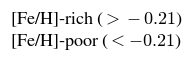

In [583]:
#metallicity labels
if metal_rich_highlim is None:
    label_rich = fr'[Fe/H]-rich ($>{str(metal_rich_lowlim)}$)'
else:
    label_rich = fr'[Fe/H]-rich (${str(metal_rich_lowlim)}$-${str(metal_rich_highlim)}$)'
    
if metal_poor_lowlim is None:
    label_poor = fr'[Fe/H]-poor ($<{str(metal_rich_lowlim)}$)'
else:
    label_poor = fr'[Fe/H]-poor (${str(metal_poor_lowlim)}$-$<{str(metal_poor_highlim)}$)'
    
MP.show_text(label_rich+"\n"+label_poor)

In [584]:
# fontsizes and legend loc
plt.rcParams.update({'font.size' : 25})
axis_labelsize = "large"
legend_fontsize = "21.5"
number_bar_labelsize = "medium"
extra_variables_size = "x-small"
capsize_lat = 5

legend_loc_dict = {
    'anisotropy':'lower left',
    'correlation':(0.4,0.71),
    'tilt_abs':(0.4,0.71)
}

ylim_dict = {
    "tilt_abs": [-45,3],
    "vertex_abs": [-45,3],
}

bar_width=0.2 if bmax == 9 else 0.3

In [585]:
# extra_string_bool = True
extra_string_bool = False

number_bool = True
# number_bool = False

x_error_data_bool = True; xerr_frac = 2
# x_error_data_bool = False

### Single

In [594]:
map_string = "tilt_abs"
# map_string = "correlation"
# map_string = "anisotropy"
# map_string = 'mean_vx'

error_string = map_string+"_error"

In [595]:
# legend_bool = True
legend_bool = True if map_string == "anisotropy" else False
# legend_bool = False

In [596]:
save_bool = True
# save_bool = False

/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/tilt_abs_noLeg
Saved .png
Saved .pdf


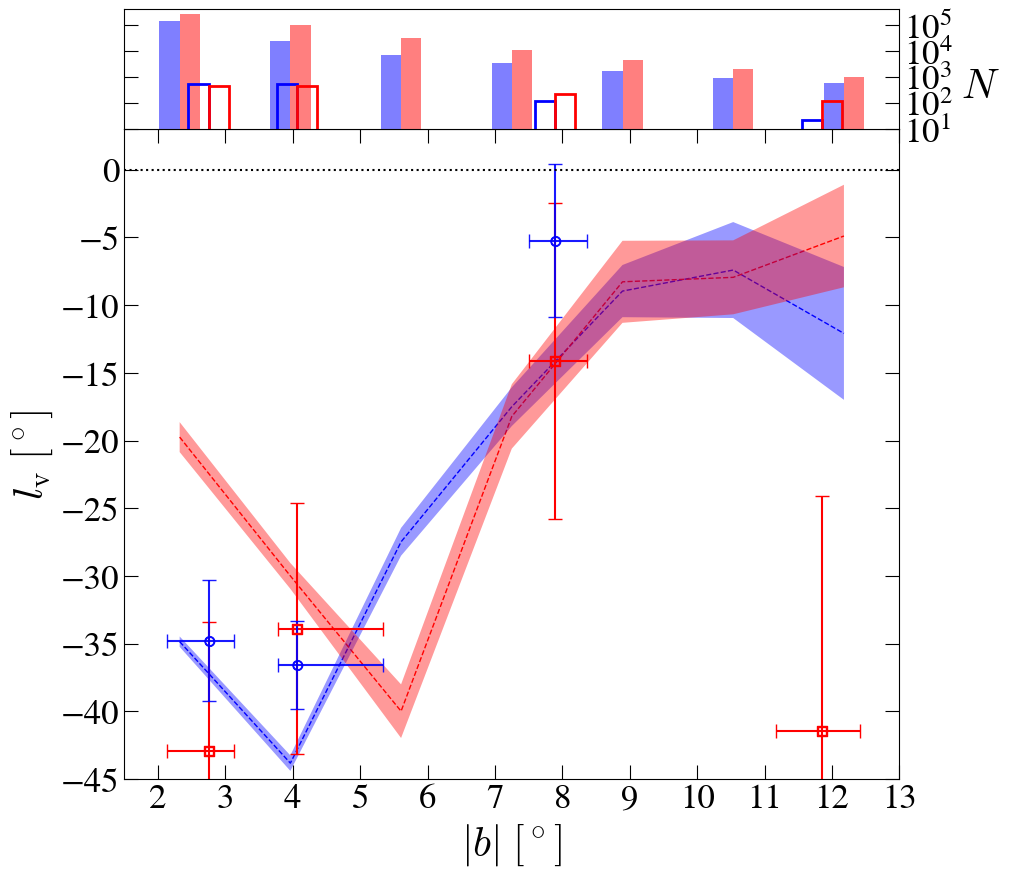

In [597]:
# plot
map_symbol = symbol_dict[map_string]
# map_title = title_dict[map_string]

fig, ax = plt.subplots(figsize=(10,10))

divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", size=1.2, pad=0, sharex=ax)

if sim_bool:
    sim_map_array = map_dict[map_string]
    sim_error_array = map_dict[map_string+"_error"]
    
    if number_bool:
        LATPLOT_number_bars_sim(map_dict["number"], sim_b_range_plot,alpha=0.5)
    
    LATPLOT_values_sim(sim_map_array, sim_error_array, sim_b_range_plot,alpha=0.4,legend=True)

if data_bool:
    o_map_array = o_map_dict[map_string]
    o_error_array = o_map_dict[error_string]
        
    if number_bool:
        LATPLOT_number_bars_data(o_map_dict["number"], o_b_range_plot)
    
    LATPLOT_values_data(o_map_array, o_error_array, o_b_range_min, o_b_range_max, o_b_range_plot,legend=True)

ax.plot([bmin,bmax],[0,0],color='black',linestyle='dotted')

LATPLOT_number_bars_axis_settings()
LATPLOT_xaxis_settings()
LATPLOT_yaxis_settings(map_string)

if True: # save
    
    legend_string = '' if legend_bool else '_noLeg'
    
    filename = map_string + legend_string
    print(save_path+filename)
    
    if save_bool:
        for formatting in ['.png','.pdf']:
            plt.savefig(save_path+filename+formatting, bbox_inches='tight', dpi=300)
            print("Saved",formatting)
    plt.show()

### Grouped

In [610]:
# map_list = ["anisotropy","correlation","tilt_abs"]; map_list_string = "anicorrtilt"
# error_list = [m+"_error" for m in map_list]

# map_list = ["mean_vx","mean_vy","std_vx","std_vy"]; map_list_string = "velmeanstd"
# error_list = ["std_vx","std_vy","zero","zero"]; map_list_string += "err"
# error_list = ["zero","zero","zero","zero"]

# map_list = ["mean_vx","mean_vy","std_vx","std_vy","anisotropy"]; map_list_string = "velmeanstdani"
# error_list = ["zero","zero","zero","zero","anisotropy_error"]

map_list = ["std_vx","std_vy","anisotropy"]; map_list_string = "stdani"
error_list = ["zero","zero","anisotropy_error"]

# map_list = ["mean_vx","mean_vy"]; map_list_string = "meanvel"
# error_list = ["std_vx","std_vy"]; map_list_string += "err"
# error_list = ["zero","zero"]

# map_list = ["mean_vx","mean_vy","anisotropy"]; map_list_string = "meanvelerrani"
# error_list = ["std_vx","std_vy","anisotropy_error"]

In [611]:
# legend_row = 0
legend_row = len(map_list)-1
# legend_row = 999

In [612]:
save_bool = True
# save_bool = False

/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/anicorrtilt_xerr2
Saved .png
Saved .pdf


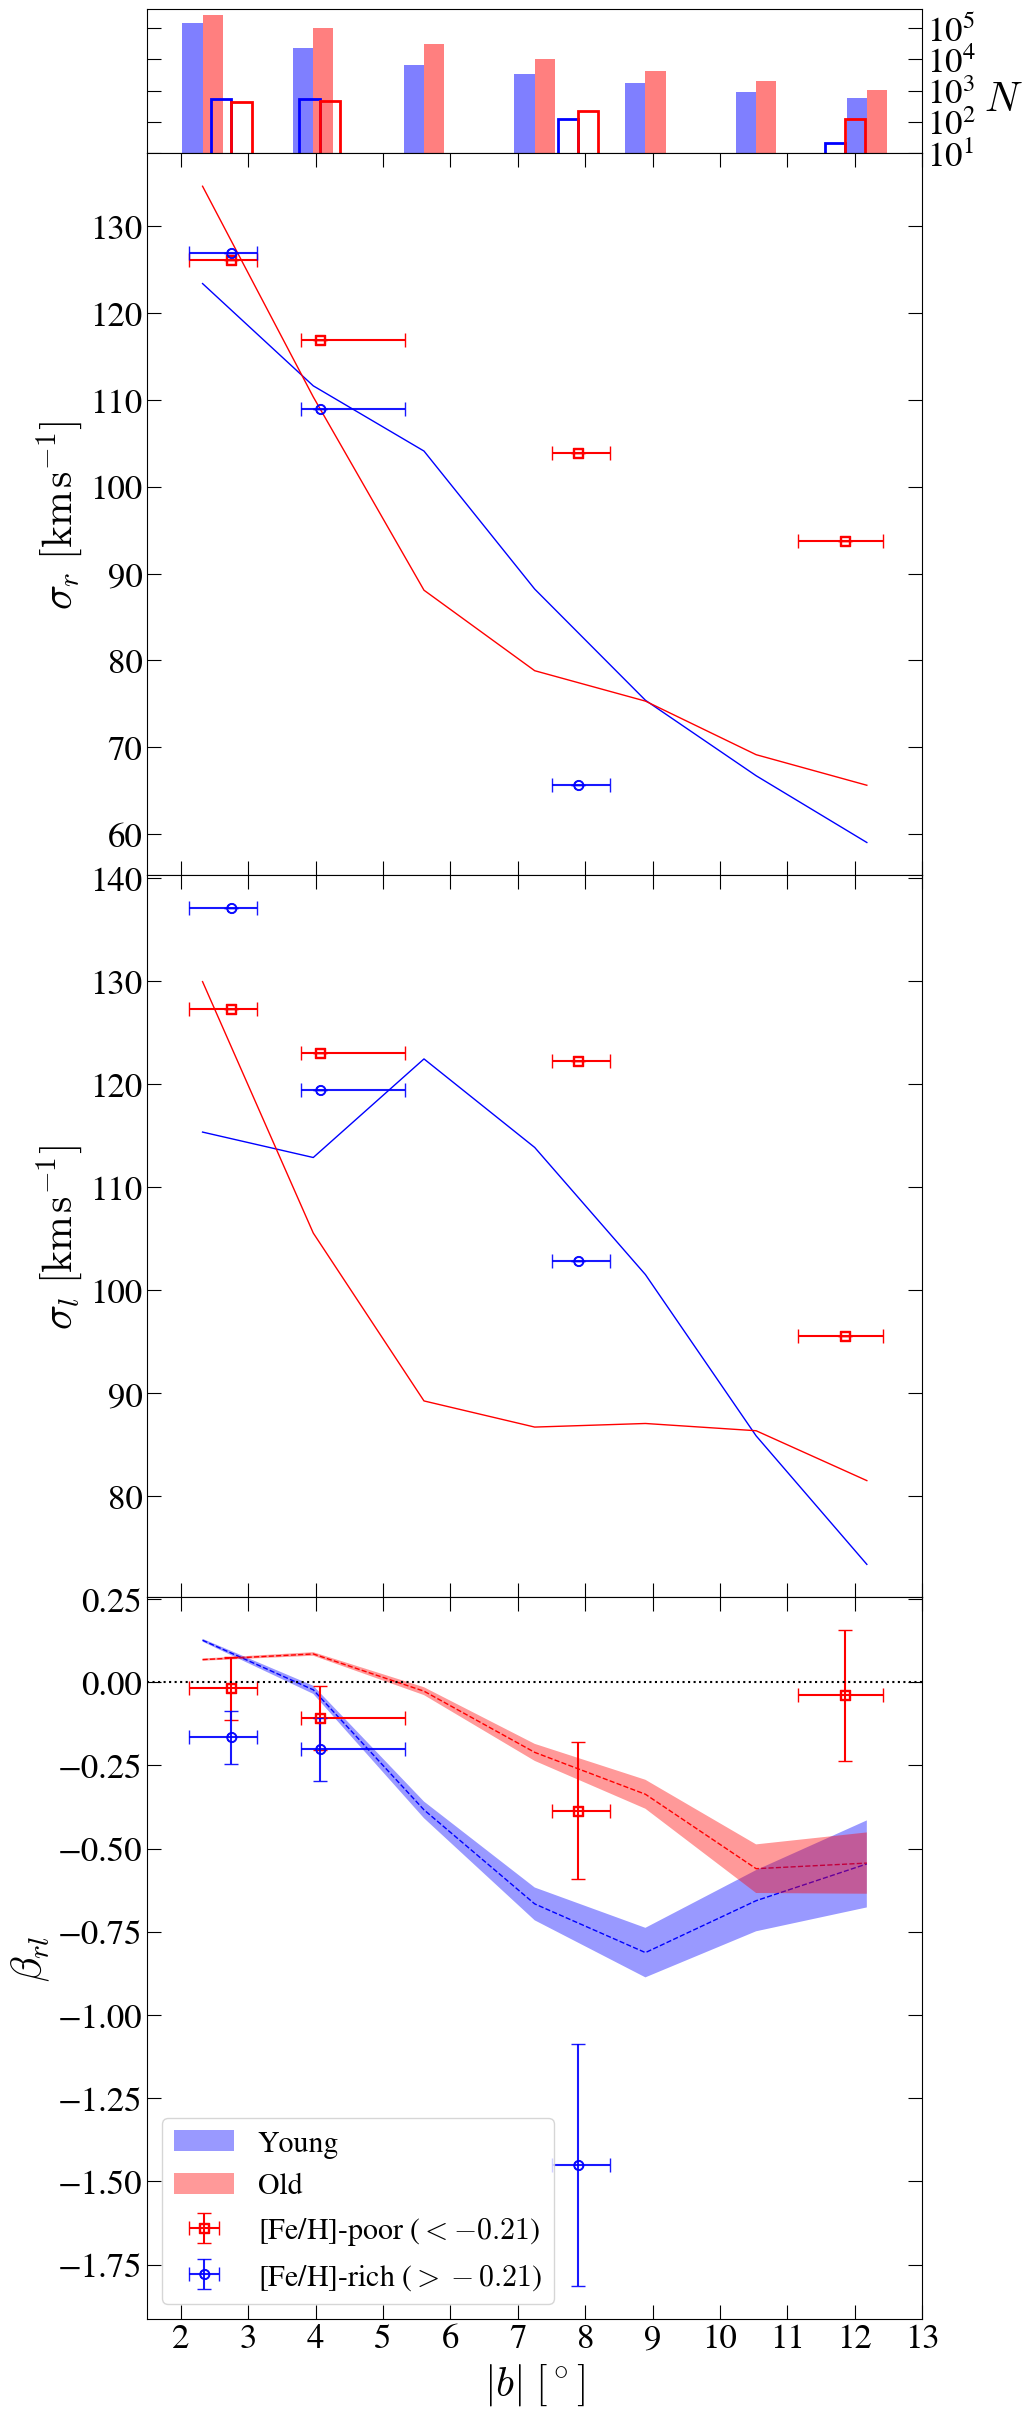

In [613]:
# plot

nrows = len(map_list)+1

x_figsize = 10

fig, axs = plt.subplots(figsize=(x_figsize,len(map_list)*x_figsize),ncols=1,nrows=nrows,sharex=True,gridspec_kw={"height_ratios":[0.2]+[1]*(nrows-1),"hspace":0})

ax_histx = axs[0]

if number_bool:
    if sim_bool:
        LATPLOT_number_bars_sim(map_dict["number"], sim_b_range_plot,alpha=0.5)
    if data_bool:
        LATPLOT_number_bars_data(o_map_dict["number"], o_b_range_plot)
        
    LATPLOT_number_bars_axis_settings()

for row in range(nrows - 1):
    ax = axs[row+1]
    map_string = map_list[row]
    error_string = error_list[row]
    
    legend_bool = row == legend_row
    
    map_symbol = symbol_dict[map_string]
    # map_title = title_dict[map_string]

    if sim_bool:
        sim_map_array = map_dict[map_string]
        sim_error_array = map_dict[error_string]

        LATPLOT_values_sim(sim_map_array, sim_error_array, sim_b_range_plot,alpha=0.4,legend=True)

    if data_bool:
        o_map_array = o_map_dict[map_string]
        o_error_array = o_map_dict[error_string]

        LATPLOT_values_data(o_map_array, o_error_array, o_b_range_min, o_b_range_max, o_b_range_plot,legend=True)
    
    if True: # zero line
        minima = [np.nanmin(sim_map_array-sim_error_array),np.nanmin(o_map_array-o_error_array)]
        maxima = [np.nanmax(sim_map_array+sim_error_array),np.nanmax(o_map_array+o_error_array)]
        if PH.shall_plot_zero_line(minima,maxima):
            ax.plot([bmin,bmax],[0,0],color='black',linestyle='dotted')
    
    LATPLOT_yaxis_settings(map_string)
    LATPLOT_legend_and_text(legend_bool, extra_string_bool)

LATPLOT_xaxis_settings()

if True: # save
    
    xerr_string = f"_xerr{xerr_frac}" if x_error_data_bool else ""
    
    filename = filename_prefix + xerr_string
    print(save_path+filename)
    
    if save_bool:
        for formatting in ['.png','.pdf']:
            plt.savefig(save_path+filename+formatting, bbox_inches='tight', dpi=300)
            print("Saved",formatting)
    plt.show()

### Shadowed

The way to use this is:
* Run all the code above for the variations you want, in order to save the arrays
* Before producing the plot with shadows, run all the code above for the variation you'd like to show as main plot (i.e. the brightest ones)
* The code below will load the shadows and create the plot

#### Load

In [660]:
# Load

current_var = "R"
variation_var = "R"

variations_dict = {
    "Nbins": [[4,6],[5,7]], # [:,0] and [:,1] correspond to data and sim respectively
    "l": [[-2,2],[-1.5,1.5],[-2.5,2.5]],
    "R": [[0,3.5],[0,2]],
    "d": [[6.1,10.1]]
}

def get_variable_path_str(variable,var_tuple):
    if variable == "Nbins":
        return f"{var_tuple[0]}_points_data/{var_tuple[1]}_points_sim/"
    elif variable == "R" or variable == "d":
        return f"extra_{variable}/{var_tuple[0]}{variable}{var_tuple[1]}/"

def get_variation_results(variable, var_tuple, path, array_prefix="",range_prefix="pop_", deconstructed=True, verbose=False):
    """
    Parameters
    ----------
    variable: string
        variable to use
    var_tuple: tuple 
        values of variation
    path: string
    deconstructed: boolean
        if True, `path` is a tuple with the deconstructed save path portions to be completed with the variation values
        if False, `path` is the complete save path with the variation values already added in
        
    Returns
    -------
    map_dict: dict 
        Contains a 1D array entry per kinematic variable in `full_map_string_list`
    range_min: 1D array
    range_max: 1D array
    range_plot: 1D array
    """
    
    if deconstructed:
        var_string = get_variable_path_str(variable,var_tuple)

        variation_path = path[0] + var_string + path[1]
    else:
        variation_path = path
    
    variation_arrays_path = variation_path + "arrays/"
    
    if verbose:
        print("Loading from\n",variation_arrays_path)
    
    map_dict = {}
    
    for m in full_map_string_list:
        map_dict[m] = np.load(f"{variation_arrays_path}{array_prefix}{m}.npy")
    
    min_range = np.load(variation_arrays_path + f"{range_prefix}range_min.npy")
    max_range = np.load(variation_arrays_path + f"{range_prefix}range_max.npy")
    plot_range = np.load(variation_arrays_path + f"{range_prefix}range_plot.npy")
    
    return map_dict, min_range, max_range, plot_range

current_string_tuples_dict = {
    "Npoints": [n_points_data,n_points_sim],
    "l": [lmin,lmax],
    extra_variable: [extra_min,extra_max]
}

current_tuple = current_string_tuples_dict[current_var]

current_string = get_variable_path_str(current_var,current_tuple)

def get_save_path_variation():
    
    variation_string_dict = {
        "Npoints": "Nbins_variation",
        "l": "l_variation",
        "R": "R_variation",
        "d": "d_variation"
    }
    
    save_path_variation = get_save_path() + variation_string_dict[variation_var] + "/"
    MF.create_dir(save_path_variation)
    
    return save_path_variation

save_path_variation = get_save_path_variation()
print("Saving in:",save_path_variation)

Saving in: /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/R_variation/


In [661]:
current_save_path = get_save_path()
deconstructed_path = current_save_path.split(current_string)

variations_list = variations_dict[variation_var]

if current_var == variation_var and current_tuple in variations_list:
    variations_list.remove(current_tuple)

In [662]:
# variations

variations_list = variations_dict[variation_var]

sim_dict_of_map_dicts,sim_b_range_min_dict,sim_b_range_max_dict,sim_b_range_plot_dict = {},{},{},{}
o_dict_of_map_dicts,o_b_range_min_dict,o_b_range_max_dict,o_b_range_plot_dict = {},{},{},{}

for var_tuple in variations_list:
    
    var_key = f"{var_tuple[0]},{var_tuple[1]}"
    print(var_key)
    
    map_sim,min_sim,max_sim,plot_sim = get_variation_results(variation_var,var_tuple,deconstructed_path,array_prefix="sim_",range_prefix="sim_b_",verbose=True)
    map_data,min_data,max_data,plot_data = get_variation_results(variation_var,var_tuple,deconstructed_path,array_prefix="o_",range_prefix="o_b_",verbose=False)
    
    sim_dict_of_map_dicts[var_key] = map_sim
    o_dict_of_map_dicts[var_key] = map_data
    
    for d,v in zip([sim_b_range_min_dict,sim_b_range_max_dict,sim_b_range_plot_dict],[min_sim,max_sim,plot_sim]):
        d[var_key] = v
    
    for d,v in zip([o_b_range_min_dict,o_b_range_max_dict,o_b_range_plot_dict],[min_data,max_data,plot_data]):
        d[var_key] = v

0,2
Loading from
 /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R2/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/arrays/


In [663]:
for variation in variations_list:
    variation_key = f"{variation[0]},{variation[1]}"
        
    PH.add_zero_array_key(sim_dict_of_map_dicts[variation_key])
    PH.add_zero_array_key(o_dict_of_map_dicts[variation_key])

#### Plot

In [664]:
def set_new_colors(plot_idx=0, totalN = 256):
    mid_idx = totalN//2
    
    frac = (1/3)**(plot_idx)
    
    young_idx = int(mid_idx * (1-frac))
    old_idx = totalN - young_idx
    
    global color_y, color_o
    color_y,color_o = coolwarm(young_idx),coolwarm(old_idx)

In [665]:
number_variations_bool = True
# number_variations_bool = False

current_first = True
# current_first = False

In [666]:
main_alpha = 0.75
alpha_reduction_factor = 1

# variation_legend_bool = True # not currently implemented
variation_legend_bool = False

##### Group

In [667]:
map_list = ["anisotropy","correlation","tilt_abs"]; map_list_string = "anicorrtilt"
error_list = [m+"_error" for m in map_list]

# map_list = ["mean_vx","mean_vy","std_vx","std_vy"]; map_list_string = "velmeanstd"
# error_list = ["zero","zero","zero","zero"]
# error_list = ["std_vx","std_vy","zero","zero"]; map_list_string += "err"

# map_list = ["mean_vx","mean_vy","std_vx","std_vy","anisotropy"]; map_list_string = "velmeanstdani"
# error_list = ["zero","zero","zero","zero","anisotropy_error"]

# map_list = ["std_vx","std_vy","anisotropy"]; map_list_string = "stdani"
# error_list = ["zero","zero","anisotropy_error"]

# map_list = ["mean_vx","mean_vy"]; map_list_string = "meanvel"
# error_list = ["std_vx","std_vy"]; map_list_string += "err"
# error_list = ["zero","zero"]

# map_list = ["mean_vx","mean_vy","anisotropy"]; map_list_string = "meanvelerrani"
# error_list = ["std_vx","std_vy","anisotropy_error"]

In [668]:
legend_row = 0
# legend_row = len(map_list)-1
# legend_row = 999

In [669]:
save_bool = True
# save_bool = False

/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1.5b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/R_variation/lat_anicorrtilt_RVar_0-2
Saved .png
Saved .pdf


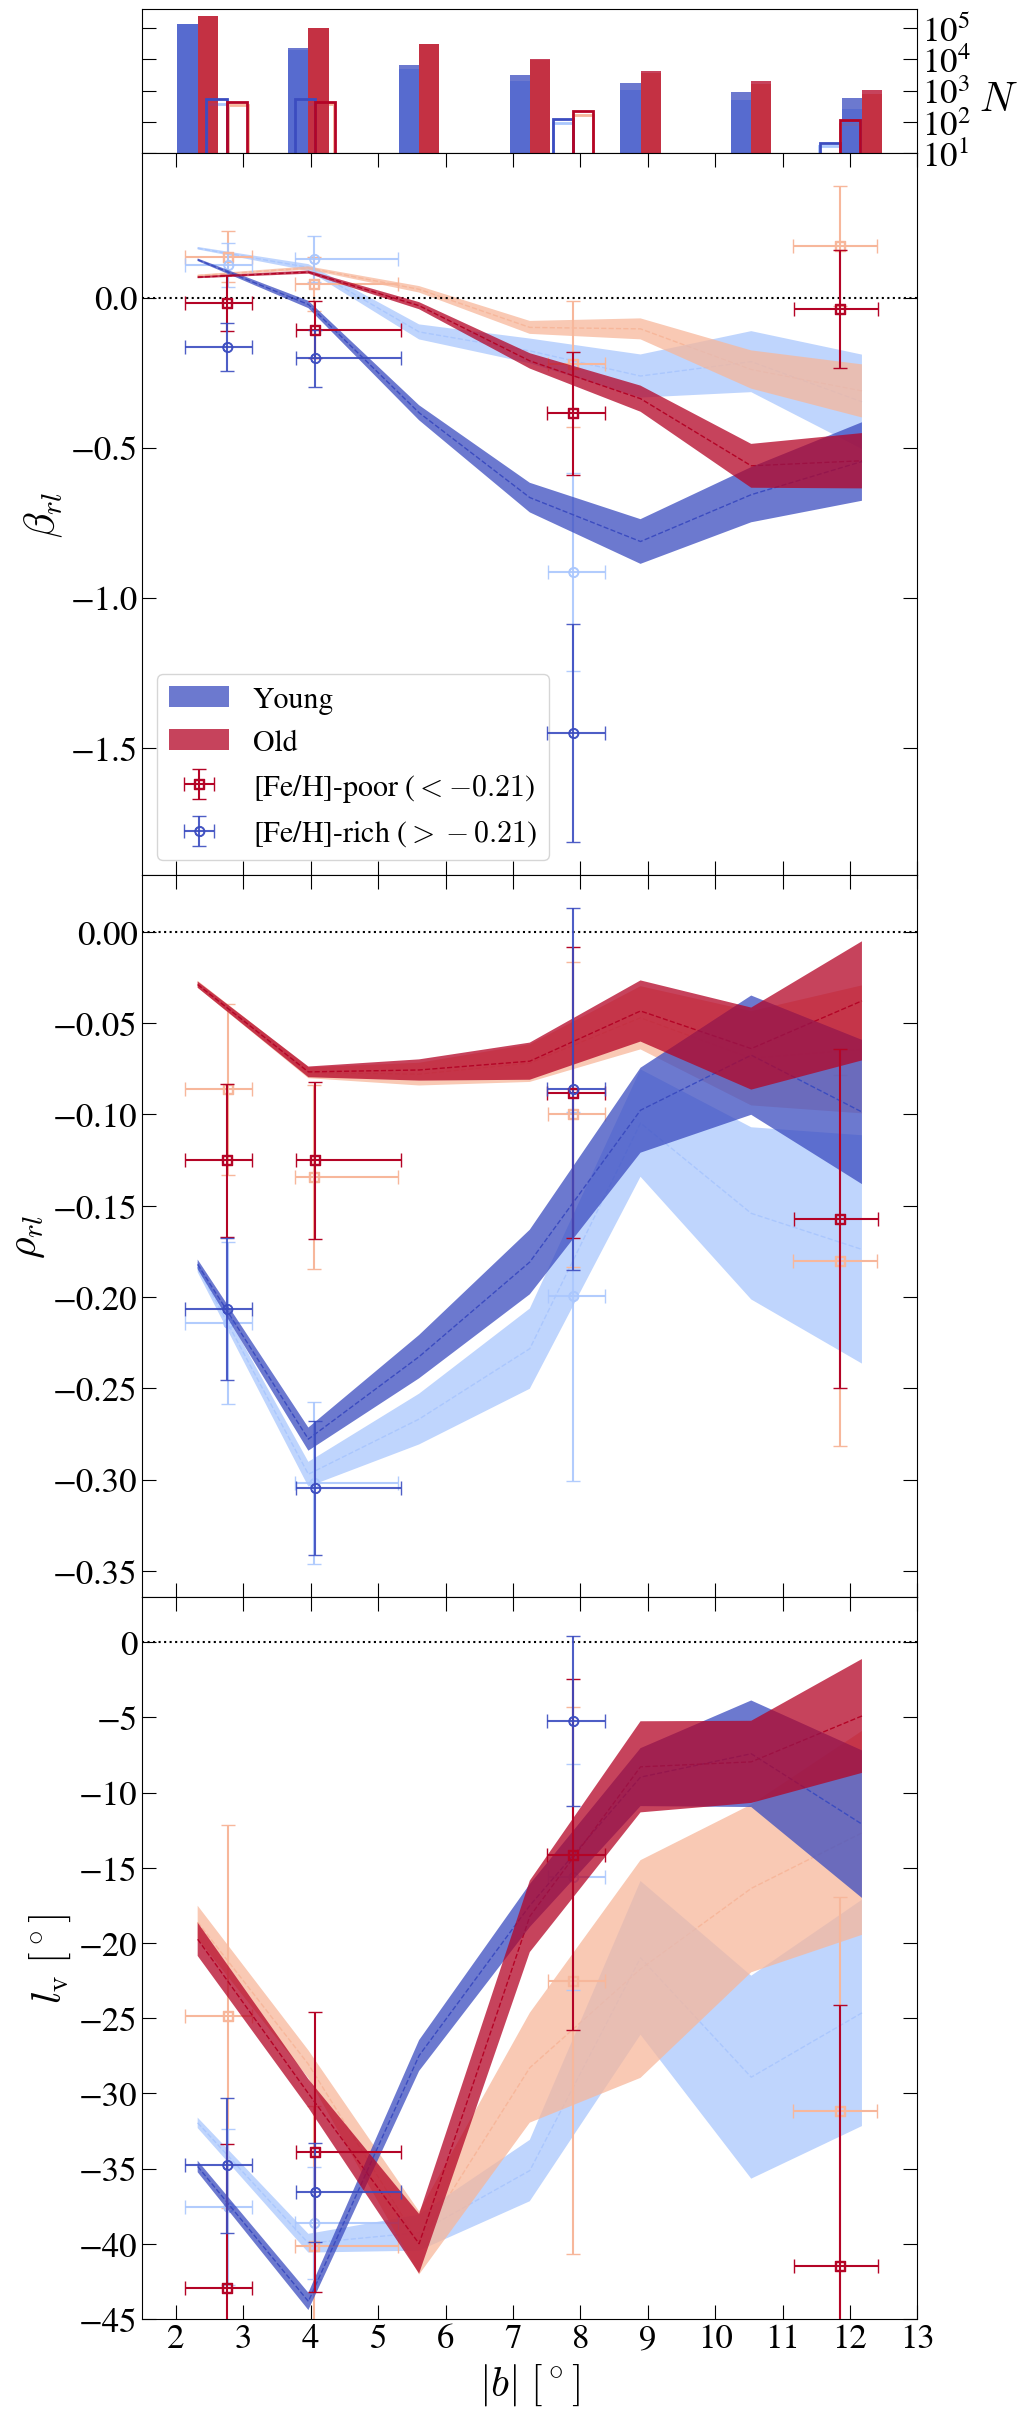

In [670]:
# plot

x_figsize = 10

fig, axs = plt.subplots(figsize=(x_figsize,len(map_list)*x_figsize),ncols=1,nrows=len(map_list)+1,sharex=True,gridspec_kw={"height_ratios":[0.2]+[1]*len(map_list),"hspace":0})

ax_histx = axs[0]

if number_bool:
    alpha = main_alpha
    plot_idx = 0
    set_new_colors(plot_idx)
    
    if sim_bool:
        LATPLOT_number_bars_sim(map_dict["number"], sim_b_range_plot,alpha=alpha,zorder=10 if current_first else None)
    if data_bool:
        LATPLOT_number_bars_data(o_map_dict["number"], o_b_range_plot,alpha=alpha,zorder=10 if current_first else None)
        
    if number_variations_bool:
        
        for k in sim_dict_of_map_dicts: # assumes the same variation are applied to model and data
            alpha *= alpha_reduction_factor
            plot_idx += 1
            set_new_colors(plot_idx)

            if sim_bool:
                variation_sim_map_dict = sim_dict_of_map_dicts[k]
                variation_sim_b_range_plot = sim_b_range_plot_dict[k]
                
                LATPLOT_number_bars_sim(variation_sim_map_dict["number"],variation_sim_b_range_plot)#,alpha=alpha)
                
            if data_bool:
                variation_o_map_dict = o_dict_of_map_dicts[k]
                variation_o_b_range_plot = o_b_range_plot_dict[k]
                
                LATPLOT_number_bars_data(variation_o_map_dict["number"],variation_o_b_range_plot)#,alpha=alpha)
        
    LATPLOT_number_bars_axis_settings()

for row in range(len(map_list)):
    ax = axs[row+1]
    map_string = map_list[row]
    error_string = error_list[row]
    
    alpha = main_alpha
    plot_idx = 0
    set_new_colors(plot_idx)
    
    legend_bool = row == legend_row
    
    map_symbol = symbol_dict[map_string]
    # map_title = title_dict[map_string]

    if sim_bool:
        LATPLOT_values_sim(map_dict[map_string], map_dict[error_string], sim_b_range_plot,alpha=alpha,zorder=10 if current_first else None,legend=True)
    if data_bool:
        LATPLOT_values_data(o_map_dict[map_string], o_map_dict[error_string], o_b_range_min, o_b_range_max, o_b_range_plot,\
                            zorder=10 if current_first else None,legend=True)
        
    for k in sim_dict_of_map_dicts: # assumes the same variations are applied to model and data
        alpha *= alpha_reduction_factor
        plot_idx += 1
        set_new_colors(plot_idx)

        if sim_bool:
            variation_sim_map_dict = sim_dict_of_map_dicts[k]

            LATPLOT_values_sim(variation_sim_map_dict[map_string],variation_sim_map_dict[error_string],sim_b_range_plot_dict[k],alpha=alpha)

        if data_bool:
            variation_o_map_dict = o_dict_of_map_dicts[k]

            LATPLOT_values_data(variation_o_map_dict[map_string],variation_o_map_dict[error_string],\
                                o_b_range_min_dict[k],o_b_range_max_dict[k],o_b_range_plot_dict[k])

    if True: # zero line
        minima = [np.nanmin(d[map_string]-d[error_string]) for d in [map_dict,o_map_dict,variation_sim_map_dict,variation_o_map_dict]]
        maxima = [np.nanmax(d[map_string]+d[error_string]) for d in [map_dict,o_map_dict,variation_sim_map_dict,variation_o_map_dict]]
        
        if PH.shall_plot_zero_line(minima,maxima):
            ax.plot([bmin,bmax],[0,0],color='black',linestyle='dotted')
    
    LATPLOT_yaxis_settings(map_string)
    LATPLOT_legend_and_text(legend_bool = row == legend_row, extra_string_bool=extra_string_bool)

LATPLOT_xaxis_settings()

if True: # save
    
    variation_string = f"_{variation_var}Var"
    for var_list in variations_list:
        variation_string += f"_{var_list[0]}-{var_list[1]}"
        
    number_variation_string = "_noNvar" if not number_variations_bool else ""
    legend_string = "_noLeg" if legend_row >= len(map_string) else ""
    variation_legend_string = "_varLegend" if variation_legend_bool else ""
    
    filename = "lat_" + map_list_string + variation_string + number_variation_string + legend_string + variation_legend_string
    print(save_path_variation+filename)
    
    if save_bool:
        for formatting in ['.png','.pdf']:
            plt.savefig(save_path_variation+filename+formatting, bbox_inches='tight', dpi=300)
            print("Saved",formatting)
    plt.show()

##### Single

In [179]:
# save_bool = True
save_bool = False

/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/boot500/d_variation/tilt_abs_dVar_6-10_nBarPlotVar_noLeg


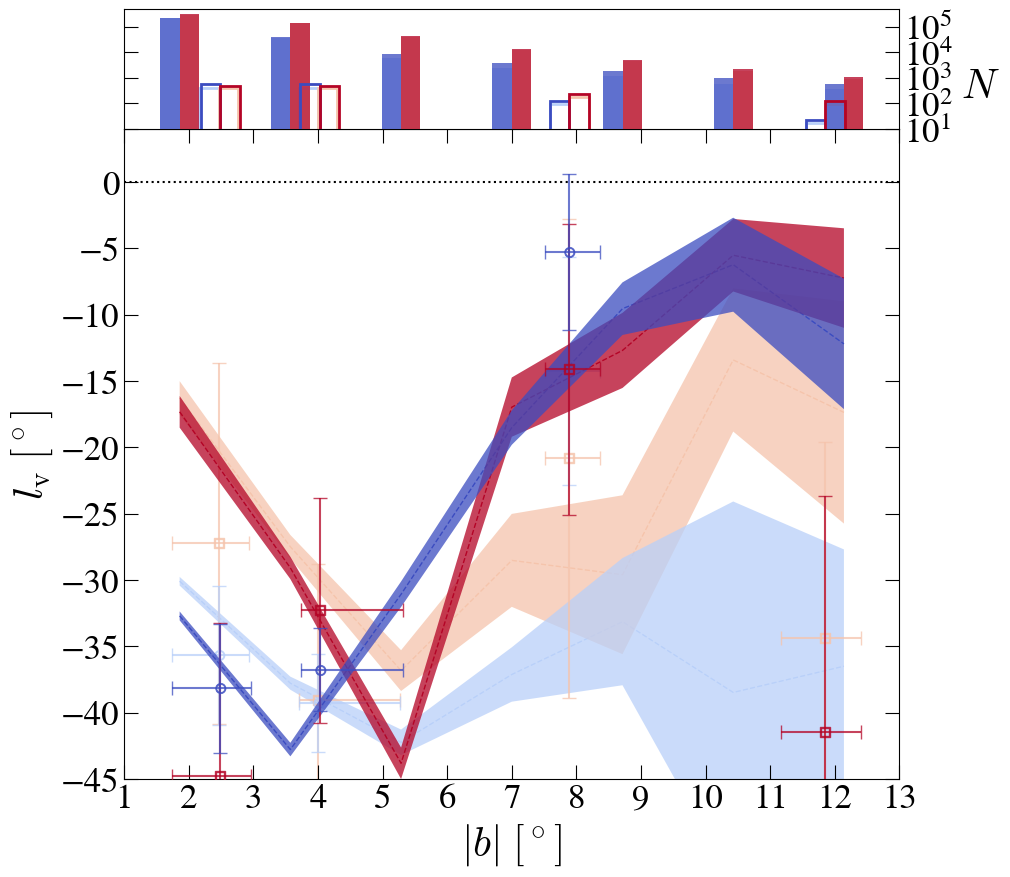

In [180]:
# plot
map_symbol = symbol_dict[map_string]
# map_title = title_dict[map_string]

fig, ax = plt.subplots(figsize=(10,10))

divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", size=1.2, pad=0, sharex=ax)

if sim_bool:
    sim_map_array = map_dict[map_string]
    sim_error_array = map_dict[map_string+"_error"]
    
    alpha = 0.75
    plot_idx = 0
    set_new_colors(plot_idx)
    
    if number_bool:
        LATPLOT_number_bars_sim(map_dict["number"], sim_b_range_plot, alpha=alpha, zorder=10 if current_first else None)
    LATPLOT_values_sim(sim_map_array, sim_error_array, sim_b_range_plot, alpha=alpha, legend=True, zorder=10 if current_first else None)
    
    for k in sim_dict_of_map_dicts:
        alpha *= alpha_reduction_factor
        plot_idx += 1
        set_new_colors(plot_idx)
        
        variation_sim_map_dict = sim_dict_of_map_dicts[k]
        variation_sim_b_range_plot = sim_b_range_plot_dict[k]
        
        if number_variations_bool:
            LATPLOT_number_bars_sim(variation_sim_map_dict["number"],variation_sim_b_range_plot,alpha)
        LATPLOT_values_sim(variation_sim_map_dict[map_string],variation_sim_map_dict[error_string],variation_sim_b_range_plot,alpha)

if data_bool:
    o_map_array = o_map_dict[map_string]
    o_error_array = o_map_dict[error_string]
    
    alpha = 0.75
    plot_idx = 0
    set_new_colors(plot_idx)
    
    if number_bool:        
        LATPLOT_number_bars_data(o_map_dict["number"], o_b_range_plot,alpha=alpha,zorder=11 if current_first else None)
    LATPLOT_values_data(o_map_array, o_error_array, o_b_range_min, o_b_range_max, o_b_range_plot,alpha=alpha,legend=True,zorder=11 if current_first else None)
    
    for k in o_dict_of_map_dicts:
        alpha *= alpha_reduction_factor
        plot_idx += 1
        set_new_colors(plot_idx)
        
        variation_o_map_dict = o_dict_of_map_dicts[k]
        variation_o_b_range_plot = o_b_range_plot_dict[k]
        variation_o_b_range_min = o_b_range_min_dict[k]
        variation_o_b_range_max = o_b_range_max_dict[k]
                
        if number_variations_bool:
            LATPLOT_number_bars_data(variation_o_map_dict["number"],variation_o_b_range_plot,alpha=alpha)
        LATPLOT_values_data(variation_o_map_dict[map_string],variation_o_map_dict[error_string],variation_o_b_range_min,variation_o_b_range_max,variation_o_b_range_plot,alpha=alpha)

ax.plot([bmin,bmax],[0,0],color='black',linestyle='dotted')

LATPLOT_number_bars_axis_settings()
LATPLOT_xaxis_settings()
LATPLOT_yaxis_settings()

if True: # save
    
    xerr_string = f"_xerr{xerr_frac}" if x_error_data_bool and xerr_frac!=2 else ""
    
    variation_string = f"_{variation_var}Var"
    for var_list in variations_list:
        variation_string += f"_{var_list[0]}-{var_list[1]}"
        
    number_variation_string = "_nBarPlotVar" if number_variations_bool else ""
    
    outlier_string = '_NoOutlier' if map_string == "anisotropy" and not outlier_bool else ''
    legend_string = '' if legend_bool else '_noLeg'
    
    filename = map_string + variation_string + number_variation_string + xerr_string + outlier_string + legend_string
    print(save_path_variation+filename)
    
    if save_bool:
        for formatting in ['.png','.pdf']:
            plt.savefig(save_path_variation+filename+formatting, bbox_inches='tight', dpi=300)
            print("Saved",formatting)
    plt.show()

#### Illustrate bulge cuts variation

Currently only implemented for radius variation (and hard-coded)

illustrate_cuts_data
Saving in: /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/boot500/


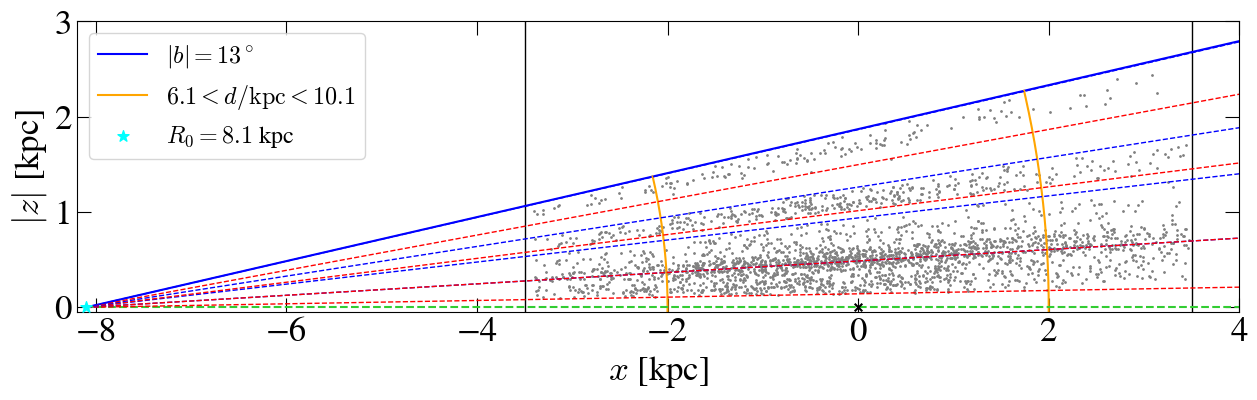

In [361]:
save_bool = True
# save_bool = False

if True: # illustrate bulge cut variation
    
    fig,axs=plt.subplots(figsize=(15,10),nrows=2,sharex=True,gridspec_kw={"hspace":-0.43})
    
    MP.visualise_bulge_selection(given_axs=axs,cuts={"lmax":lmax,"bmax":bmax,"dmax":10.1,"R0":R0},y_max_plot=3)

#     MP.plot_circle(radius=2.5,ax=axs[0],linestyle="--",label=r"$R_\mathrm{GC}\leq2.5$ kpc")
#     axs[1].axvline(-2.5,color="k",linestyle="--")
#     axs[1].axvline(2.5,color="k",linestyle="--")

    axs[0].scatter(pd.concat(df_metals)["x"],pd.concat(df_metals)["y"],color="grey",s=1)
    axs[1].scatter(pd.concat(df_metals)["x"],pd.concat(df_metals)["z"],color="grey",s=1)
    
    for m,M in zip(o_b_range_min,o_b_range_max):
        MP.plot_angled_line(axs[1],xmin=-R0,ymin=0,xmax=4,angle=m,color="red",linestyle="--")
        MP.plot_angled_line(axs[1],xmin=-R0,ymin=0,xmax=4,angle=M,color="blue",linestyle="--")

    _ = [ax.legend(fontsize="x-small") for ax in axs]
    
    fig.delaxes(axs[0])
    
    axs[1].set_xlim(-R0-0.1)

    filename = "illustrate_cuts_data"
    print(filename)
    if save_bool:
        print("Saving in:",save_path)
        plt.savefig(save_path+filename+".png",dpi=200,bbox_inches="tight")

illustrate_cut_simOld
Saving in: /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/latitude/gaiaDR3/-2l2/1b13/extra_R/0R3.5/4-7_9.5-10/-1metal/-0.21toNone_Noneto-0.21/equal_number_low/4_points_data/7_points_sim/boot500/


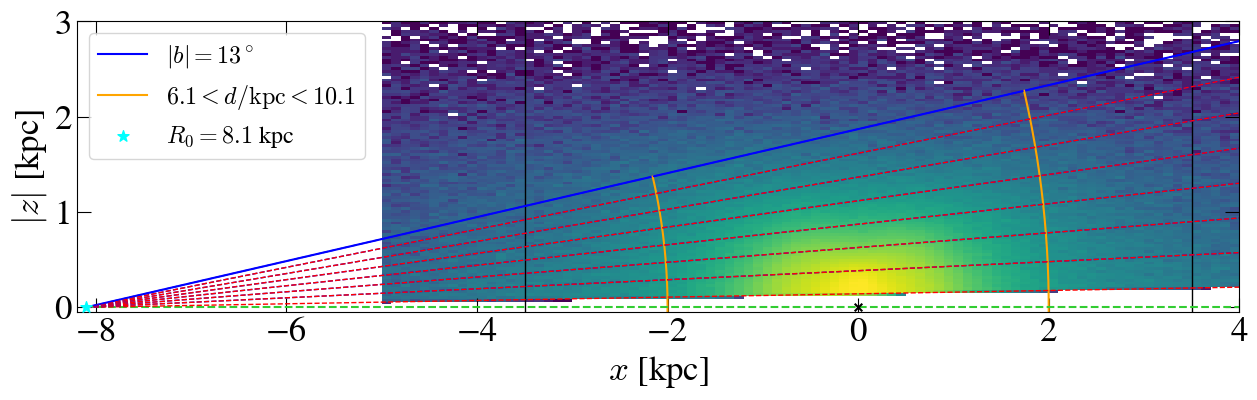

In [363]:
# young_bool = True
young_bool = False

save_bool = True
# save_bool = False

if True: # illustrate bulge cut variation for the simulation
    
    fig,axs=plt.subplots(figsize=(15,10),nrows=2,sharex=True,gridspec_kw={"hspace":-0.43})
    
    if young_bool:
        df = df0[(df0["age"]>=young_min)&(df0["age"]<=young_max)]
    else:
        df = df0[(df0["age"]>=old_min)&(df0["age"]<=old_max)]
        
    MP.quick_show_xy_xz(df=df,bmin=bmin,axs=axs)
    
    MP.visualise_bulge_selection(given_axs=axs,cuts={"lmax":lmax,"bmax":bmax,"dmax":10.1,"R0":R0},y_max_plot=3)

#     MP.plot_circle(radius=2.5,ax=axs[0],linestyle="--",label=r"$R_\mathrm{GC}\leq2.5$ kpc")
#     axs[1].axvline(-2.5,color="k",linestyle="--")
#     axs[1].axvline(2.5,color="k",linestyle="--")
    
    for m,M in zip(sim_b_range_min,sim_b_range_max):
        MP.plot_angled_line(axs[1],xmin=-R0,ymin=0,xmax=4,angle=m,color="red",linestyle="--")
        MP.plot_angled_line(axs[1],xmin=-R0,ymin=0,xmax=4,angle=M,color="blue",linestyle="--")

    _ = [ax.legend(fontsize="x-small") for ax in axs]
    
    fig.delaxes(axs[0])
    
    axs[1].set_xlim(-R0-0.1)
    
    filename = "illustrate_cut_sim%s"%("Young" if young_bool else "Old")

    print(filename)
    if save_bool:
        print("Saving in:",save_path)
        plt.savefig(save_path+filename+".png",dpi=200,bbox_inches="tight")
        
    del df

## Older plots

### Plot pairs

#### Standard & abs

In [62]:
color_dict_comp = {
    0 : ["blue", "red"],
    1 : ["deepskyblue", "gold"]
}

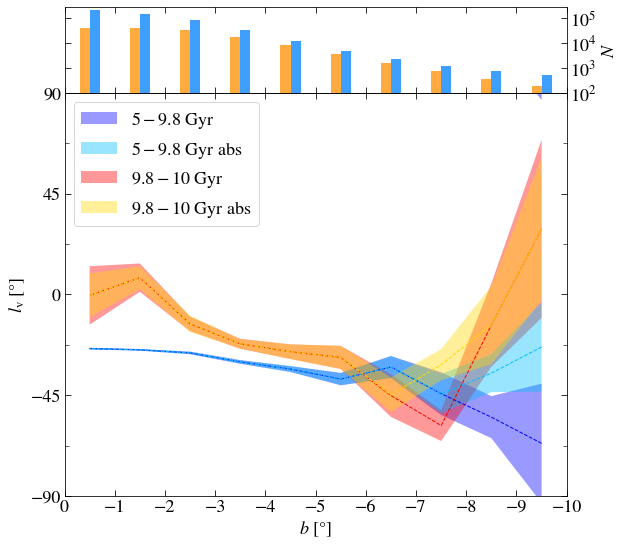

In [63]:
transparency = 0.5
alpha_area = 0.4

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", size=1.2, pad=0, sharex=ax)
ax_histx.xaxis.set_tick_params(labelbottom=False)

map_string="vertex"
error_string = "vertex_error"
map_array = map_dict[map_string]
error_array = map_dict[error_string]
map_symbol = symbol_dict["vertex"]
yticks = get_variable_ticks(map_string, map_array)
displacement = max(yticks) - min(yticks)
label_y = r"$5-9.8$ Gyr"
label_o = r"$9.8-10$ Gyr"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

bar_width=0.2
ax_histx.bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_y)
ax_histx.bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_o)
ax_histx.yaxis.set_tick_params(labelleft=False,labelright=True)

ax.plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
ax.plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

ax.fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
ax.fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

ax.fill_between(b_range_plot, map_array[:,0]-error_array[:,0]+displacement, map_array[:,0]+error_array[:,0]+displacement,alpha=alpha_area, facecolor=color_y)
ax.fill_between(b_range_plot, map_array[:,1]-error_array[:,1]+displacement, map_array[:,1]+error_array[:,1]+displacement,alpha=alpha_area, facecolor=color_o)
ax.fill_between(b_range_plot, map_array[:,0]-error_array[:,0]-displacement, map_array[:,0]+error_array[:,0]-displacement,alpha=alpha_area, facecolor=color_y)
ax.fill_between(b_range_plot, map_array[:,1]-error_array[:,1]-displacement, map_array[:,1]+error_array[:,1]-displacement,alpha=alpha_area, facecolor=color_o)
ax.set_yticks(yticks)
ax.set_ylim(min(yticks),max(yticks))


map_string = "vertex_abs"
error_string = "vertex_error_abs"
map_array = map_dict[map_string]
error_array = map_dict[error_string]
yticks = get_variable_ticks(map_string, map_array)
displacement = max(yticks) - min(yticks)
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$5-9.8$ Gyr abs"
label_o = r"$9.8-10$ Gyr abs"

bar_width=0.2
ax_histx.bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_y)
ax_histx.bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_o)
ax_histx.yaxis.set_tick_params(labelleft=False,labelright=True)

ax.plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
ax.plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

ax.fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
ax.fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc="upper left")

ax_histx.set_yticks([100,1000,10000,100000])
ax_histx.set_ylabel(r"$N$",labelpad=5)
ax_histx.yaxis.set_label_position("right")
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor',direction='in',color='black',length=4)#,width=1)
ax.set_xlim(0,-10)
ax.set_xticks(np.arange(0,-10-1,-1))

ax.set_xlabel(r"$b$ [°]")
ax.set_ylabel(map_symbol)

ax.set_aspect('auto')
plt.savefig(save_path+"vertex_comparison.png",bbox_inches='tight',dpi=300)

plt.show()

#### velocities

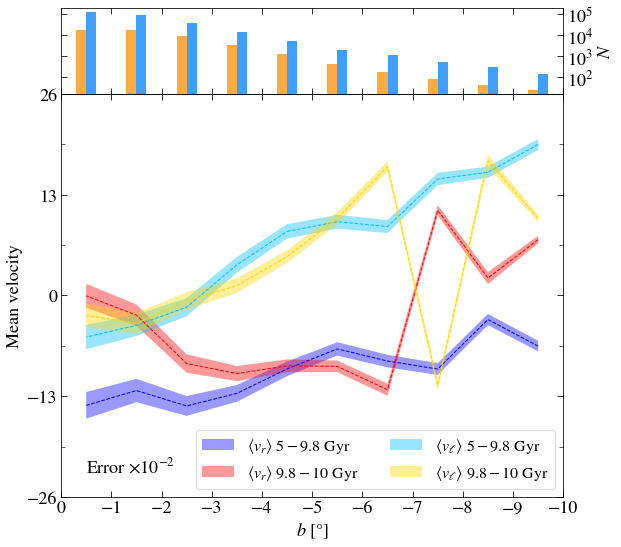

In [37]:
transparency = 0.5
alpha_area = 0.4
error_factor = 100

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", size=1.2, pad=0, sharex=ax)
ax_histx.xaxis.set_tick_params(labelbottom=False)

map_string="mean_vr"
error_string = "varr"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor
yticks = get_variable_ticks(map_string, map_array)
label_y = r"$\langle v_r \rangle$ $5-9.8$ Gyr"
label_o = r"$\langle v_r \rangle$ $9.8-10$ Gyr"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

bar_width=0.2
ax_histx.bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_y)
ax_histx.bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_o)
ax_histx.yaxis.set_tick_params(labelleft=False,labelright=True)

ax.plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
ax.plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

ax.fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
ax.fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)


map_string = "mean_vl"
error_string = "varl"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$\langle v_l \rangle$ $5-9.8$ Gyr"
label_o = r"$\langle v_l \rangle$ $9.8-10$ Gyr"

ax_histx.bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_y)
ax_histx.bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_o)
ax_histx.yaxis.set_tick_params(labelleft=False,labelright=True)

ax.plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
ax.plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

ax.fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
ax.fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

#handles, labels = ax.get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#ax.legend(handles, labels, loc="upper left")
ax.legend(loc='lower right',ncol=2,fontsize=16)

ax_histx.set_yticks([100,1000,10000,100000])
ax_histx.set_ylabel(r"$N$",labelpad=5)
ax_histx.yaxis.set_label_position("right")
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor',direction='in',color='black',length=4)#,width=1)
ax.set_xlim(0,-10)
ax.set_xticks(np.arange(0,-10-1,-1))

ylim = 26
yticks = np.linspace(-ylim,ylim,5)
ax.set_yticks(yticks)
ax.set_ylim(min(yticks),max(yticks))

ax.set_xlabel(r"$b$ [°]")
ax.set_ylabel("Mean velocity")

ax.set_aspect('auto')

if error_factor != 1:
    ax.text(-0.5,yticks[1]*7/4,r"Error $\times 10^{-%i}$" % get_exponent(error_factor))

error_factor_string = '_error'+str(error_factor) if error_factor != 1 else ''
plt.savefig(save_path+f"mean_velocities{error_factor_string}.png",bbox_inches='tight',dpi=300)
plt.show()

#### corr & anis

In [183]:
o_b_range_max

[2.5, 4, 6.6, 9]

In [94]:
color_dict_comp = {
    0 : ["blue", "red"],
    1 : ["deepskyblue", "gold"]
}

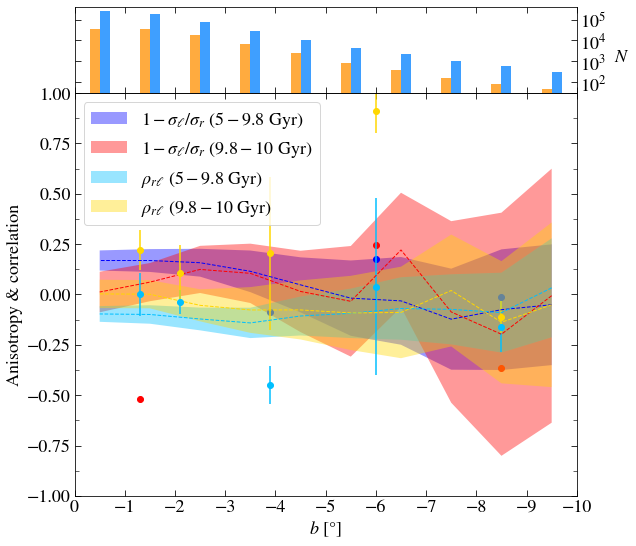

In [99]:
transparency = 0.5
alpha_area = 0.4
error_factor = 10

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", size=1.2, pad=0, sharex=ax)
ax_histx.xaxis.set_tick_params(labelbottom=False)

map_string="anisotropy"
error_string = "anisotropy_error"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor
yticks = get_variable_ticks(map_string, map_array)
label_y = r"$1-\sigma_{l}/\sigma_r$ ($5-9.8$ Gyr)"
label_o = r"$1-\sigma_{l}/\sigma_r$ ($9.8-10$ Gyr)"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

bar_width=0.2
ax_histx.bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_y)
ax_histx.bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_o)
ax_histx.yaxis.set_tick_params(labelleft=False,labelright=True)

ax.plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
ax.plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

ax.fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
ax.fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

#OBSERVATIONS-----------------------------------------------------------------------------------------------
o_map_array = o_map_dict[map_string]
o_error_array = o_map_dict[error_string]

#ax.errorbar(o_b_range_plot, o_map_array[:,0], yerr= o_error_array[:,0], color=color_y, fmt='o')
#ax.errorbar(o_b_range_plot, o_map_array[:,1] , yerr= o_error_array[:,1], color=color_o, fmt='o')
ax.scatter(o_b_range_plot, o_map_array[:,0], color=color_y)
ax.scatter(o_b_range_plot, o_map_array[:,1] , color=color_o)

#------------------------------------------------------------------------------------------------------------

map_string = "correlation"
error_string = "correlation_error"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$\rho_{rl}$ ($5-9.8$ Gyr)"
label_o = r"$\rho_{rl}$ ($9.8-10$ Gyr)"

ax_histx.bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_y)
ax_histx.bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_o)
ax_histx.yaxis.set_tick_params(labelleft=False,labelright=True)

ax.plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
ax.plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

ax.fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
ax.fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

#OBSERVATIONS-----------------------------------------------------------------------------------------------
o_map_array = o_map_dict[map_string]
o_error_array = o_map_dict[error_string]

ax.errorbar(o_b_range_plot, o_map_array[:,0], yerr= o_error_array[:,0], color=color_y, fmt='o')
ax.errorbar(o_b_range_plot, o_map_array[:,1] , yerr= o_error_array[:,1], color=color_o, fmt='o')

#------------------------------------------------------------------------------------------------------------

#handles, labels = ax.get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#ax.legend(handles, labels, loc="upper left")
ax.legend(loc='best')

ax_histx.set_yticks([100,1000,10000,100000])
ax_histx.set_ylabel(r"$N$",labelpad=15,rotation=0)
ax_histx.yaxis.set_label_position("right")
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='minor',direction='in',color='black',length=4)#,width=1)
ax.set_xlim(0,-10)
ax.set_xticks(np.arange(0,-10-1,-1))

ax.set_ylim(-1,1)

ax.set_xlabel(r"$b$ [°]")
ax.set_ylabel("Anisotropy & correlation")
#ax.set_yticks(np.array(yticks))
#ax.set_ylim(min(yticks),max(yticks))

ax.set_aspect('auto')

x_error = -0.5
if error_factor != 1:
    ax.text(x_error,-0.85,r"Error $\times 10^{-%i}$" % get_exponent(error_factor), size=15)#error_fontsize)

error_factor_string = '_error'+str(error_factor) if error_factor != 1 else ''
plt.savefig(save_path+f"corr_anis{error_factor_string}.png",bbox_inches='tight',dpi=300)
plt.show()

### Grouped

#### vertex,anicorr,vel

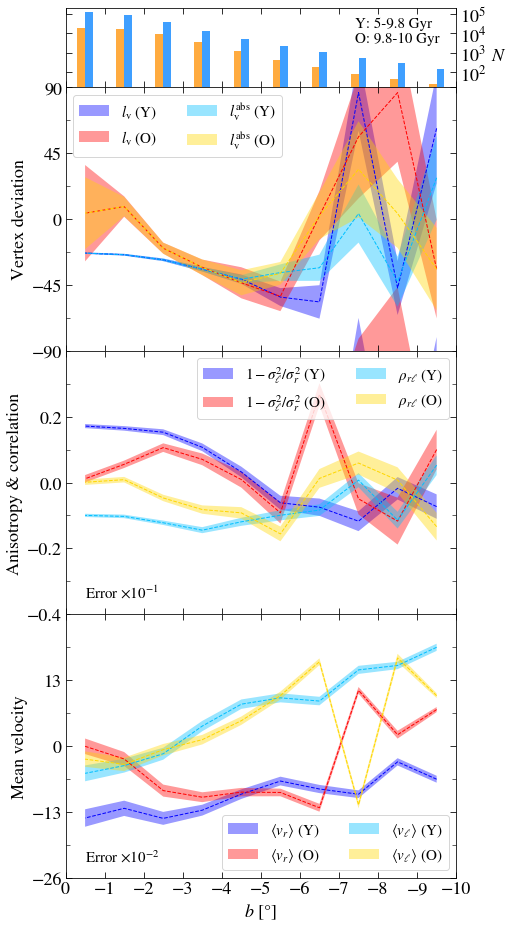

In [39]:
transparency = 0.5
alpha_area = 0.4
legend_fontsize = 15
legend_ncol = 2
error_fontsize=15

fig, axs = plt.subplots(4,1,sharex=True,figsize=(7,16),gridspec_kw={"hspace":0, "height_ratios":[0.3,1,1,1]})

for ax in axs:
    if ax.is_last_row():
        ax.set_xlabel(r"$b$ [°]")
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_aspect('auto')
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(which='minor',direction='in',color='black',length=4)#,width=1)
    ax.set_xlim(0,-10)
    ax.set_xticks(np.arange(0,-10-1,-1))

#------------------------------------------------------------------------------------------------------------------
error_factor_vert = 1

map_string="vertex"
error_string = "vertex_error"
map_array = map_dict[map_string]
error_array = map_dict[error_string]/error_factor_vert
yticks = get_variable_ticks(map_string, map_array)
displacement = max(yticks) - min(yticks)
label_y = r"$l_{\mathrm{v}}$ (Y)"
label_o = r"$l_{\mathrm{v}}$ (O)"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

axs[1].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[1].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0]+displacement, map_array[:,0]+error_array[:,0]+displacement,alpha=alpha_area, facecolor=color_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1]+displacement, map_array[:,1]+error_array[:,1]+displacement,alpha=alpha_area, facecolor=color_o)
axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0]-displacement, map_array[:,0]+error_array[:,0]-displacement,alpha=alpha_area, facecolor=color_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1]-displacement, map_array[:,1]+error_array[:,1]-displacement,alpha=alpha_area, facecolor=color_o)
axs[1].set_yticks(yticks)
axs[1].set_ylim(min(yticks),max(yticks))

map_string = "vertex_abs"
error_string = "vertex_error_abs"
map_array = map_dict[map_string]
error_array = map_dict[error_string]/error_factor_vert
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$l_{\mathrm{v}}^{\mathrm{abs}}$ (Y)"
label_o = r"$l_{\mathrm{v}}^{\mathrm{abs}}$ (O)"

axs[1].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[1].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

#handles, labels = axs[1].get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#axs[1].legend(handles, labels, loc="upper center", fontsize=legend_fontsize)
axs[1].legend(loc="upper left", fontsize=legend_fontsize,ncol=legend_ncol)

if error_factor_vert != 1:
    if error_factor_vert >= 10:
        axs[1].text(-0.5,yticks[1]*7/4,r"Error $\times 10^{-%i}$" % get_exponent(error_factor_vert), size=error_fontsize)
    elif error_factor_vert == 2:
        axs[1].text(-0.5,yticks[1]*7/4,r"Error $\times 0.5$", size=error_fontsize)
    else:
        raise ValueError("Unknown error factor in vertex")
        
axs[1].set_ylabel("Vertex deviation")
    
#-------------------------------------------------------------------------------------------------------------------

error_factor_anicorr = 10

map_string="anisotropy"
error_string = "anisotropy_error"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor_anicorr
yticks = get_variable_ticks(map_string, map_array)
label_y = r"$1-\sigma_{l}^2/\sigma_r^2$ (Y)"
label_o = r"$1-\sigma_{l}^2/\sigma_r^2$ (O)"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

axs[2].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[2].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[2].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[2].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

map_string = "correlation"
error_string = "correlation_error"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor_anicorr
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$\rho_{rl}$ (Y)"
label_o = r"$\rho_{rl}$ (O)"

axs[2].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[2].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[2].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[2].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

axs[2].set_ylabel("Anisotropy & correlation")

#handles, labels = ax.get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#ax.legend(handles, labels, loc="upper left")
axs[2].legend(loc='upper right', fontsize=legend_fontsize,ncol=legend_ncol)

yticks = np.linspace(-0.4,0.4,5)
axs[2].set_yticks(yticks[:-1])
axs[2].set_ylim(min(yticks),max(yticks))

axs[2].text(-0.5,yticks[1]*7/4,r"Error $\times 10^{-%i}$" % get_exponent(error_factor_anicorr), size=error_fontsize)

#------------------------------------------------------------------------------------------------------------------

error_factor_vel = 100

map_string="mean_vr"
error_string = "varr"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor_vel
yticks = get_variable_ticks(map_string, map_array)
label_y = r"$\langle v_r \rangle$ (Y)"
label_o = r"$\langle v_r \rangle$ (O)"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

axs[3].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[3].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[3].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[3].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

map_string = "mean_vl"
error_string = "varl"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor_vel
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$\langle v_l \rangle$ (Y)"
label_o = r"$\langle v_l \rangle$ (O)"

axs[3].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[3].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[3].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[3].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

axs[3].set_ylabel("Mean velocity")

#handles, labels = ax.get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#ax.legend(handles, labels, loc="upper left")
axs[3].legend(loc='lower right', fontsize=legend_fontsize,ncol=legend_ncol)
ylim = 26
yticks = np.linspace(-ylim,ylim,5)
axs[3].set_yticks(yticks[:-1])
axs[3].set_ylim(min(yticks),max(yticks))

axs[3].text(-0.5,yticks[1]*7/4,r"Error $\times 10^{-%i}$" % get_exponent(error_factor_vel), size=error_fontsize)

#------------------------------------------------------------------------------------------------------------------

bar_width=0.2
axs[0].bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[0][0])
axs[0].bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[0][1])
axs[0].bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[1][0])
axs[0].bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[1][1])
axs[0].yaxis.set_tick_params(labelleft=False,labelright=True)

axs[0].set_yticks([100,1000,10000,100000])
axs[0].set_ylabel(r"$N$",labelpad=13,rotation=0)
axs[0].yaxis.set_label_position("right")

axs[0].text(-7.4,3500,"Y: 5-9.8 Gyr\nO: 9.8-10 Gyr", size=error_fontsize)

error_string_vert = "_errorvert"+str(error_factor_vert) if error_factor_vert != 1 else ''
error_string_anicorr = '_erroranicorr'+str(error_factor_anicorr) if error_factor_anicorr != 1 else ''
error_string_vel = '_errorvel'+str(error_factor_vel) if error_factor_vel != 1 else ''
filename = "group"+error_string_vert+error_string_anicorr+error_string_vel+'.png'
plt.savefig(save_path+filename,bbox_inches='tight',dpi=300)
plt.show()

#### vertex,anicorr

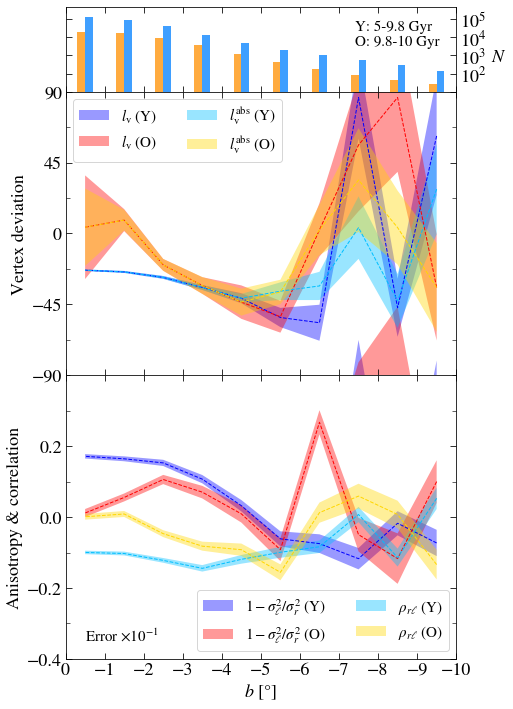

In [42]:
transparency = 0.5
alpha_area = 0.4
legend_fontsize = 15
error_fontsize=15

fig, axs = plt.subplots(3,1,sharex=True,figsize=(7,12),gridspec_kw={"hspace":0, "height_ratios":[0.3,1,1]})

for ax in axs:
    if ax.is_last_row():
        ax.set_xlabel(r"$b$ [°]")
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_aspect('auto')
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(which='minor',direction='in',color='black',length=4)#,width=1)
    ax.set_xlim(0,-10)
    ax.set_xticks(np.arange(0,-10-1,-1))

#------------------------------------------------------------------------------------------------------------------
error_factor_vert = 1

map_string="vertex"
error_string = "vertex_error"
map_array = map_dict[map_string]
error_array = map_dict[error_string]/error_factor_vert
yticks = get_variable_ticks(map_string, map_array)
displacement = max(yticks) - min(yticks)
label_y = r"$l_{\mathrm{v}}$ (Y)"
label_o = r"$l_{\mathrm{v}}$ (O)"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

axs[1].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[1].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0]+displacement, map_array[:,0]+error_array[:,0]+displacement,alpha=alpha_area, facecolor=color_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1]+displacement, map_array[:,1]+error_array[:,1]+displacement,alpha=alpha_area, facecolor=color_o)
axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0]-displacement, map_array[:,0]+error_array[:,0]-displacement,alpha=alpha_area, facecolor=color_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1]-displacement, map_array[:,1]+error_array[:,1]-displacement,alpha=alpha_area, facecolor=color_o)
axs[1].set_yticks(yticks)
axs[1].set_ylim(min(yticks),max(yticks))

map_string = "vertex_abs"
error_string = "vertex_error_abs"
map_array = map_dict[map_string]
error_array = map_dict[error_string]/error_factor_vert
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$l_{\mathrm{v}}^{\mathrm{abs}}$ (Y)"
label_o = r"$l_{\mathrm{v}}^{\mathrm{abs}}$ (O)"

axs[1].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[1].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

#handles, labels = axs[1].get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#axs[1].legend(handles, labels, loc="upper center", fontsize=legend_fontsize)
axs[1].legend(loc="upper left", fontsize=legend_fontsize, ncol=2)

if error_factor_vert != 1:
    if error_factor_vert >= 10:
        axs[1].text(-0.5,yticks[1]*7/4,r"Error $\times 10^{-%i}$" % get_exponent(error_factor_vert), size=error_fontsize)
    elif error_factor_vert == 2:
        axs[1].text(-0.5,yticks[1]*7/4,r"Error $\times 0.5$", size=error_fontsize)
    else:
        raise ValueError("Unknown error factor in vertex")
        
axs[1].set_ylabel("Vertex deviation")
    
#-------------------------------------------------------------------------------------------------------------------

error_factor_anicorr = 10

map_string="anisotropy"
error_string = "anisotropy_error"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor_anicorr
yticks = get_variable_ticks(map_string, map_array)
label_y = r"$1-\sigma_{l}^2/\sigma_r^2$ (Y)"
label_o = r"$1-\sigma_{l}^2/\sigma_r^2$ (O)"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

axs[2].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[2].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[2].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[2].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

map_string = "correlation"
error_string = "correlation_error"
map_array = map_dict[map_string]
error_array = np.sqrt(map_dict[error_string])/error_factor_anicorr
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$\rho_{rl}$ (Y)"
label_o = r"$\rho_{rl}$ (O)"

axs[2].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[2].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[2].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[2].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

axs[2].set_ylabel("Anisotropy & correlation")

#handles, labels = ax.get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#ax.legend(handles, labels, loc="upper left")
axs[2].legend(loc='lower right', fontsize=legend_fontsize, ncol=2)

yticks = np.linspace(-0.4,0.4,5)
axs[2].set_yticks(yticks[:-1])
axs[2].set_ylim(min(yticks),max(yticks))

if error_factor_anicorr != 1:
    if error_factor_anicorr >= 10:
        axs[2].text(-0.5,yticks[1]*7/4,r"Error $\times 10^{-%i}$" % get_exponent(error_factor_anicorr), size=error_fontsize)
    elif error_factor_anicorr == 2:
        axs[2].text(-0.5,yticks[1]*7/4,r"Error $\times 0.5$", size=error_fontsize)
    else:
        raise ValueError("Unknown error factor in anicorr")

#------------------------------------------------------------------------------------------------------------------

bar_width=0.2
axs[0].bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[0][0])
axs[0].bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[0][1])
axs[0].bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[1][0])
axs[0].bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[1][1])
axs[0].yaxis.set_tick_params(labelleft=False,labelright=True)

axs[0].set_yticks([100,1000,10000,100000])
axs[0].set_ylim(10,500000)
axs[0].set_ylabel(r"$N$",labelpad=13, rotation=0)
axs[0].yaxis.set_label_position("right")

axs[0].text(-7.4,3500,"Y: 5-9.8 Gyr\nO: 9.8-10 Gyr", size=error_fontsize)

error_string_vert = "_errorvert"+str(error_factor_vert) if error_factor_vert != 1 else ''
error_string_anicorr = '_erroranicorr'+str(error_factor_anicorr) if error_factor_anicorr != 1 else ''
filename = "group"+error_string_vert+error_string_anicorr+'.png'
plt.savefig(save_path+filename,bbox_inches='tight',dpi=300)
plt.show()

#### vertex,covdiff

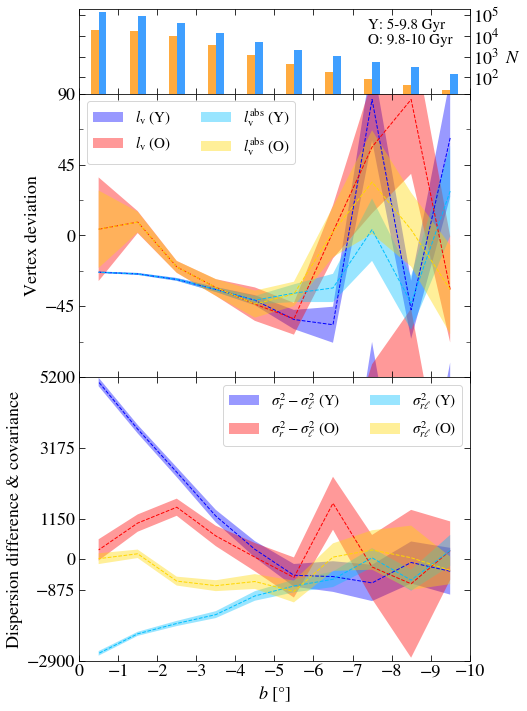

In [45]:
transparency = 0.5
alpha_area = 0.4
legend_fontsize = 15
error_fontsize=15

fig, axs = plt.subplots(3,1,sharex=True,figsize=(7,12),gridspec_kw={"hspace":0, "height_ratios":[0.3,1,1]})

for ax in axs:
    if ax.is_last_row():
        ax.set_xlabel(r"$b$ [°]")
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_aspect('auto')
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(which='minor',direction='in',color='black',length=4)#,width=1)
    ax.set_xlim(0,-10)
    ax.set_xticks(np.arange(0,-10-1,-1))

#------------------------------------------------------------------------------------------------------------------
error_factor_vert = 1

map_string="vertex"
error_string = "vertex_error"
map_array = map_dict[map_string]
error_array = map_dict[error_string]/error_factor_vert
yticks = get_variable_ticks(map_string, map_array)
displacement = max(yticks) - min(yticks)
label_y = r"$l_{\mathrm{v}}$ (Y)"
label_o = r"$l_{\mathrm{v}}$ (O)"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

axs[1].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[1].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0]+displacement, map_array[:,0]+error_array[:,0]+displacement,alpha=alpha_area, facecolor=color_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1]+displacement, map_array[:,1]+error_array[:,1]+displacement,alpha=alpha_area, facecolor=color_o)
axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0]-displacement, map_array[:,0]+error_array[:,0]-displacement,alpha=alpha_area, facecolor=color_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1]-displacement, map_array[:,1]+error_array[:,1]-displacement,alpha=alpha_area, facecolor=color_o)
axs[1].set_yticks(yticks[1:])
axs[1].set_ylim(min(yticks),max(yticks))

map_string = "vertex_abs"
error_string = "vertex_error_abs"
map_array = map_dict[map_string]
error_array = map_dict[error_string]/error_factor_vert
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$l_{\mathrm{v}}^{\mathrm{abs}}$ (Y)"
label_o = r"$l_{\mathrm{v}}^{\mathrm{abs}}$ (O)"

axs[1].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[1].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[1].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[1].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

#handles, labels = axs[1].get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#axs[1].legend(handles, labels, loc="upper center", fontsize=legend_fontsize)
axs[1].legend(loc="best", fontsize=legend_fontsize,ncol=2)

if error_factor_vert != 1:
    if error_factor_vert >= 10:
        axs[1].text(-0.5,yticks[1]*7/4,r"Error $\times 10^{-%i}$" % get_exponent(error_factor_vert), size=error_fontsize)
    elif error_factor_vert == 2:
        axs[1].text(-0.5,yticks[1]*7/4,r"Error $\times 0.5$", size=error_fontsize)
    else:
        raise ValueError("Unknown error factor in vertex")

axs[1].set_ylabel("Vertex deviation")
    
#-------------------------------------------------------------------------------------------------------------------

map_string="var_difference"
error_string = "var_difference_error"
map_array = map_dict[map_string]
error_array = map_dict[error_string] #/error_factor_anicorr
yticks = get_variable_ticks(map_string, map_array)
label_y = r"$\sigma_r^2-\sigma_{l}^2$ (Y)"
label_o = r"$\sigma_r^2-\sigma_{l}^2$ (O)"
color_y, color_o = color_dict_comp[0][0], color_dict_comp[0][1]

axs[2].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[2].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[2].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[2].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

map_string = "covariance"
error_string = "covariance_error"
map_array = map_dict[map_string]
error_array = map_dict[error_string] #/error_factor_anicorr
color_y, color_o = color_dict_comp[1][0], color_dict_comp[1][1]
label_y = r"$\sigma_{rl}^2$ (Y)"
label_o = r"$\sigma_{rl}^2$ (O)"

axs[2].plot(b_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)
axs[2].plot(b_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)

axs[2].fill_between(b_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)
axs[2].fill_between(b_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)

axs[2].set_ylabel("Dispersion difference & covariance")

#handles, labels = ax.get_legend_handles_labels()
## sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#ax.legend(handles, labels, loc="upper left")
axs[2].legend(loc='best', fontsize=legend_fontsize,ncol=2)

yticks = np.concatenate(([0], np.linspace(-2900,5200,5)))
axs[2].set_yticks(yticks)
axs[2].set_ylim(min(yticks),max(yticks))

#axs[2].text(-0.5,-0.17,r"Error $\times 10^{-%i}$" % get_exponent(error_factor_anicorr), size=error_fontsize)

#------------------------------------------------------------------------------------------------------------------

bar_width=0.2
axs[0].bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[0][0])
axs[0].bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[0][1])
axs[0].bar(b_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[1][0])
axs[0].bar(b_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_dict_comp[1][1])
axs[0].yaxis.set_tick_params(labelleft=False,labelright=True)

axs[0].set_yticks([100,1000,10000,100000])
axs[0].set_ylabel(r"$N$",labelpad=13, rotation=0)
axs[0].yaxis.set_label_position("right")

axs[0].text(-7.4,4000,"Y: 5-9.8 Gyr\nO: 9.8-10 Gyr", size=error_fontsize)

#error_string_ = '_erroranicorr'+str(error_factor_anicorr) if error_factor_anicorr != 1 else ''
error_string_vert = "_errorvert"+str(error_factor_vert) if error_factor_vert != 1 else ''
filename = "vardiffcov"+error_string_vert+'.png'
plt.savefig(save_path+filename,bbox_inches='tight',dpi=300)
plt.show()

# Stellar populations

## Velocity plots

In [206]:
# sim_bool = True
sim_bool = False

data_bool = True
# data_bool = False

In [208]:
#Baade's window is centered on (l,b) = (1.02,-3.92)°
#https://doi.org/10.1051%2F0004-6361%2F201116829

lmin,lmax = -2,2
bmin,bmax = 1,10
dmin,dmax = 6, 10

In [209]:
# save_path_pop

save_path_pop = general_path + "708main_simulation/graphs/Observations/Apogee/"
MF.create_dir(save_path_pop)

# save_path_pop += "scaling_"+str(sim_scaling)+'/'
# MF.create_dir(save_path_pop)

save_path_pop += "individual_variable/"
MF.create_dir(save_path_pop)
    
save_path_pop += "age_metal/"
MF.create_dir(save_path_pop)

save_path_pop += "velocity_plots/"
MF.create_dir(save_path_pop)

if lmax > 3:
    save_path_pop += "wider_long/"
    MF.create_dir(save_path_pop)
else:
    save_path_pop += f"{lmin}l{lmax}/"
    MF.create_dir(save_path_pop)

save_path_pop += f"{lmin}l{lmax}_{bmin}b{bmax}_{dmin}d{dmax}/"
MF.create_dir(save_path_pop)

print("SAVING IN\n"+save_path_pop)

SAVING IN
C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/-2l2/-2l2_1b10_6d10/


### Sim

In [190]:
df_extra = df0[(df0["l"]>lmin)&(df0["l"]<lmax)&(df0["d"]>dmin)&(df0["d"]<dmax)&(df0["b"]>bmin)&(df0["b"]<bmax)]

In [191]:
oscar_cuts = False

moderate_age = False
all_mod = False

if oscar_cuts:
    young_min = 4
    young_max = 7
    old_min = 9.98
    old_max = 10
else:
    young_min = 4
    young_max = 7
    old_min = 9.5
    old_max = 10
    
if moderate_age:
    if all_mod:
        mod_min = young_max
        mod_max = old_min
    else:
        mod_min = 8
        mod_max = 9

age_limits = [[young_min,young_max],[old_min,old_max]]
if moderate_age:
    age_limits.append([mod_min,mod_max])
print(age_limits)

df_ages = [df_extra[(df_extra["age"]>agelim[0])&(df_extra["age"]<agelim[1])] for agelim in age_limits]

[[4, 7], [9.5, 10]]


In [192]:
label_young = fr"${young_min}<$Age/Gyr$<{young_max}$"
label_old = fr"${old_min}<$Age/Gyr$<{old_max}$"
sim_pop_strings = [f'{young_min}Age{young_max}',f'{old_min}Age{old_max}']
print('Young:\t',label_young, '\nOld:\t',label_old)
if moderate_age:
    label_mod = fr"${mod_min}<$Age/Gyr$<{mod_max}$"
    sim_pop_strings.append(f'{mod_min}Age{mod_max}')
    print('Mod:\t',label_mod)

Young:	 $4<$Age/Gyr$<7$ 
Old:	 $9.5<$Age/Gyr$<10$


Plot the velocity distributions of old and young stars

sim_vel_lim = 400
bins = np.linspace(-sim_vel_lim,sim_vel_lim,50)

fig,axs = plt.subplots(figsize=(15,5),ncols=2,sharey=True,gridspec_kw={'wspace':0})
axs[0].hist(df_ages[0]['vl'],bins,alpha=1,label=r'young $v_l$',color='blue')
axs[0].hist(df_ages[0]['vr'],bins,alpha=0.6,label=r'young $v_r$',color='red')
axs[1].hist(df_ages[1]['vl'],bins,alpha=1,label=r'old $v_l$',color='blue')
axs[1].hist(df_ages[1]['vr'],bins,alpha=0.6,label=r'old $v_r$',color='red')
axs[0].set_ylabel(r"$N$",rotation=0,labelpad=20)
for ax in axs:
    ax.set_xlabel(r"$v$ [km s$^{-1}$]")
    ax.set_xticks(np.concatenate([[0],np.linspace(-sim_vel_lim,sim_vel_lim,6)]))
fig.legend(ncol=2,loc='upper center')
#plt.savefig(save_path_pop+'velocities_sim.png',bbox_inches='tight',dpi=200)
plt.show()

#### Swarzschild check

Checking that the ellipses are indeed ellipses in different bulge areas

In [27]:
dmin, dmax = 6,10
bmin,bmax = 5,10
lmin,lmax = -10,10

df_extra = df0[(df0["l"]>lmin)&(df0["l"]<lmax)&(df0["d"]>dmin)&(df0["d"]<dmax)&(df0["b"]>bmin)&(df0["b"]<bmax)]

In [110]:
only_symmetric_l = True
# only_symmetric_l = False

if only_symmetric_l:
    lmin_range = [-3,-2,-1]
    lmax_range = [3,2,1]
else:
    lmin_range = [-10, -5, 0, -5, 5,-3,-2,-1]
    lmax_range = [-5, 0, 5, 5, 10,3,2,1]

agemin_range = [4,9.97]
agemax_range = [7,10]

In [111]:
smoothing = 0.5
bootstrap_repeat = 100

In [112]:
save_path = general_path+'708main_simulation/graphs/other_plots/velocity_plot_check/'

save_path += f"{bmin}b{bmax}_{dmin}d{dmax}/"
MF.create_dir(save_path)

save_path += f"smooth{smoothing}/"
MF.create_dir(save_path)

if axisymmetric:
    save_path += 'axisym/'
    MF.create_dir(save_path)
    
if rot_angle != 27:
    save_path += f'angle{rot_angle}/'
    MF.create_dir(save_path)
    
save_path += f"{agemin_range[0]}-{agemax_range[0]}_{agemin_range[1]}-{agemax_range[1]}/"
MF.create_dir(save_path)

print(save_path)

C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/other_plots/velocity_plot_check/5b10_6d10/smooth0.5/4-7_9.97-10/


In [116]:
# colour_var = None
# colour_var = 'd'
colour_var = 'l'

contours_bool = True if colour_var is None else False
colour_cmap = 'coolwarm' if colour_var=='l' else 'viridis'

In [117]:
save_bool = True
# save_bool = False

# show = True
show = False

In [118]:
for agem,ageM in zip(agemin_range,agemax_range):
    df_age = df_extra[(df_extra['age']>agem)&(df_extra['age']<ageM)]
    age_str = 'Young' if agem==agemin_range[0] else 'Old'
    for lm,lM in zip(lmin_range,lmax_range):
        df_l = df_age[(df_age['l']>lm)&(df_age['l']<lM)]

        vr,vl = df_l.vr.values,df_l.vl.values
        pop_string = f'{age_str}_{lm}l{lM}' + (f"_colour_{colour_var}" if colour_var is not None else '')
        
        title_str = r'$\mathrm{%s}\hspace{2}%i^\circ<l<%i^\circ$'%(age_str,lm,lM)
        
        c = None if colour_var is None else df_l[colour_var]
        
        velocity_plot.velocity_plot(vr, vl, smoothing=smoothing,save_path = save_path, population_string = pop_string, bootstrap_repeat=bootstrap_repeat,
                                                   show=show, save=save_bool,title_str=title_str,contours_bool=contours_bool,colour_var=colour_var,c=c,colour_cmap=colour_cmap)

Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/other_plots/velocity_plot_check/5b10_6d10/smooth0.5/4-7_9.97-10/Young_-3l3_colour_l.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/other_plots/velocity_plot_check/5b10_6d10/smooth0.5/4-7_9.97-10/Young_-2l2_colour_l.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/other_plots/velocity_plot_check/5b10_6d10/smooth0.5/4-7_9.97-10/Young_-1l1_colour_l.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/other_plots/velocity_plot_check/5b10_6d10/smooth0.5/4-7_9.97-10/Old_-3l3_colour_l.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/other_plots/velocity_plot_check/5b10_6d10/smooth0.5/4-7_9.97-10/Old_-2l2_colour_l.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/other_plots/velocity_plot_check/5b10_6d10/smooth0.5/4-7_9.97-10/Old_-1l1_colour_l.png


#### nuclear disk

In [119]:
lmin,lmax = -2,2
bmin,bmax = 1,10 #baade's window at 4
dmin,dmax = 6, 10

df_extra = df0[(df0["l"]>lmin)&(df0["l"]<lmax)&(df0["d"]>dmin)&(df0["d"]<dmax)&(df0["b"]>bmin)&(df0["b"]<bmax)]

In [120]:
save_path_disc = general_path+"708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/nuclear_disc/"
MF.create_dir(save_path_disc)

save_path_disc += f"{lmin}l{lmax}_{bmin}d{bmax}_{dmin}d{dmax}/"
MF.create_dir(save_path_disc)

print(save_path_disc)

Created successfully
C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/nuclear_disc/-2l2_1d10_6d10/


In [153]:
disk_age_min = 0
disk_age_max = 3

# disc_str = "all_disk"
# disk = df_extra[(df_extra['age']>disk_age_min)&(df_extra['age']<disk_age_max)]

# disc_str = "nuclear_bar"
# disk = df_extra[(df_extra['age']>disk_age_min)&(df_extra['age']<disk_age_max)&(df_extra['R']<0.2)]

# disc_str = "all_rings"
# disk = df_extra[(df_extra['age']>disk_age_min)&(df_extra['age']<disk_age_max)&(df_extra['R']>0.2)]

# disc_str = "inner_ring"
# disk = df_extra[(df_extra['age']>disk_age_min)&(df_extra['age']<disk_age_max)&(df_extra['R']<1)&(df_extra['R']>0.2)]

disc_str = "outer_ring"
disk = df_extra[(df_extra['age']>disk_age_min)&(df_extra['age']<disk_age_max)&(df_extra['R']>1)]


pop_str = disc_str+f"_{disk_age_min}age{disk_age_max}"
print(pop_str)

outer_ring_0age3


In [154]:
save_positions = True
# save_positions = False

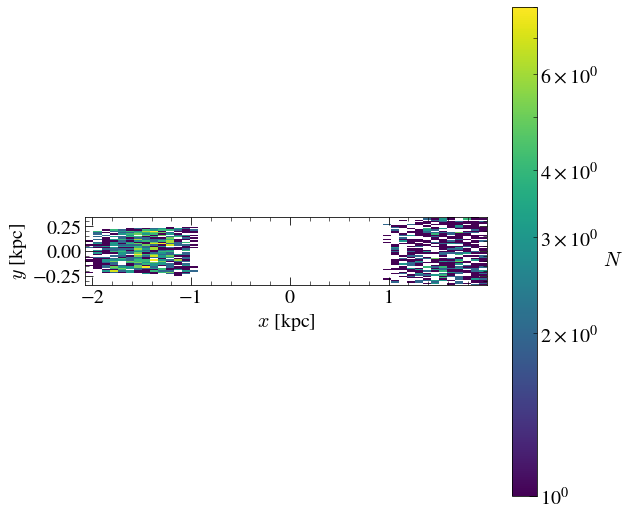

In [155]:
fig,ax=plt.subplots()
h=ax.hist2d(disk['x'],disk['y'],bins=50,norm=LogNorm())
ax.set(xlabel=r'$x$ [kpc]',ylabel=r'$y$ [kpc]')
ax.set_aspect('equal')
cbar=plt.colorbar(h[3],shrink=1)
cbar.ax.set_ylabel(r"$N$",rotation=0,labelpad=15)
if save_positions:
    plt.savefig(save_path_disc+pop_str+"_xy.png",bbox_inches='tight',dpi=300)
plt.show()

In [156]:
save_vel = True
# save_vel = False

Using smoothing 1
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/nuclear_disc/-2l2_1d10_6d10/outer_ring_0age3_vel.png.png


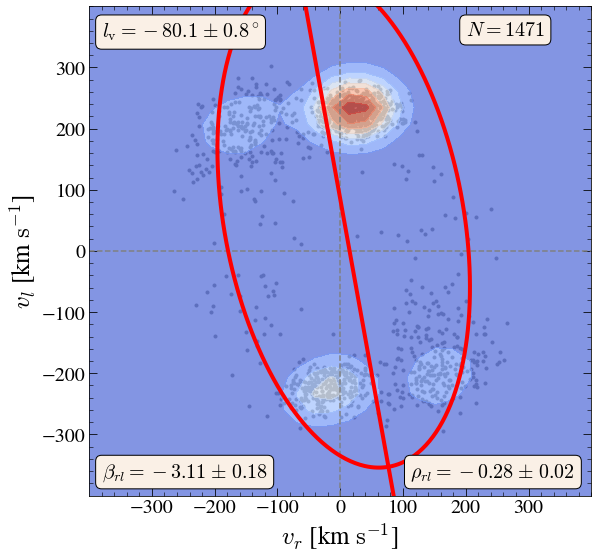

In [157]:
velocity_plot.velocity_plot(disk.vr.values,disk.vl.values,save_path=save_path_disc,save=save_vel,filename=pop_str+"_vel.png")

In [478]:
print([len(df_extra[df_extra['age']<i]) for i in range(1,4)])

[75487, 168900, 283599]


### Data

lmin,lmax = -4,4
bmin,bmax = 3,9
dmin,dmax = 6, 10

In [210]:
o_df_extra = data[(data.l>lmin)&(data.l<lmax)&(data.b>bmin)&(data.b<bmax)&(data.d>dmin)&(data.d<dmax)]

In [211]:
# reducing_bool = True
reducing_bool = False

minimum_leftover = 550

if reducing_bool: # Equalize density by downsampling
    o_df_extra = data[(data.l>lmin)&(data.l<lmax)&(data.b>bmin)&(data.b<bmax)&(data.d>dmin)&(data.d<dmax)]

    print(f"Size: {len(o_df_extra)}. Reducing...")   
    
    # region 1
    lmin_red1 = 0.75
    lmax_red1 = 1.25
    bmin_red1 = bmin
    bmax_red1 = 9
    region_condition1 = (o_df_extra['b']>bmin_red1)&(o_df_extra['b']<bmax_red1)&(o_df_extra['l']>lmin_red1)&(o_df_extra['l']<lmax_red1)
    
    # region 2
    lmin_red2 = 3.5
    lmax_red2 = lmax
    bmin_red2 = bmin
    bmax_red2 = bmax
    region_condition2 = (o_df_extra['b']>bmin_red2)&(o_df_extra['b']<bmax_red2)&(o_df_extra['l']>lmin_red2)&(o_df_extra['l']<lmax_red2)
    
    # region 3
#     lmin_red3 = 
#     lmax_red3 = 
#     bmin_red3 = 
#     bmax_red3 = 
#     region_condition3 = (o_df_extra['b']>bmin_red3)&(o_df_extra['b']<bmax_red3)&(o_df_extra['l']>lmin_red3)&(o_df_extra['l']<lmax_red3)
    
    # List all conditions
#     selection_condition = region_condition2
#     describe_selection = f'{lmin_red2}l{lmax_red2}_b{bmax_red2}'
    
    selection_condition = region_condition1 | region_condition2
    describe_selection = f'{lmin_red1}l{lmax_red1}_{lmin_red2}l{lmax_red2}_with_b{bmax_red2}'
    
    region_df = o_df_extra[selection_condition]
    rest_df = o_df_extra[~selection_condition]

    region_indices = region_df.index.to_list()

    total_pos = len(o_df_extra[o_df_extra['l']>0])
    total_neg = len(o_df_extra[o_df_extra['l']<0])

    reduced_size = len(region_indices)
    while total_pos >= total_neg and reduced_size > minimum_leftover:
        reduced_region_indices = np.random.choice(region_indices,size=reduced_size,replace=False)
        reduced_size -= 1
        total_pos -= 1

    reduced_region_df = region_df.loc[reduced_region_indices]
    
    o_df_extra = pd.concat([reduced_region_df,rest_df],ignore_index=True)
    
    print(f"Reduced size: {len(o_df_extra)}")

In [212]:
# plot_long_distribution = True
plot_long_distribution = False

# save_bool_long = True
save_bool_long = False
# save_lb_bool = True
save_lb_bool = False

if plot_long_distribution: # Plot longitude distribution

    filename = f'{lmin}l{lmax}_{bmin}b{bmax}'
    filename += f'_downsampled{total_pos}_{describe_selection}' if reducing_bool else ''

    fig,ax=plt.subplots()
    h=ax.hist(o_df_extra['l'],bins=50,color='tab:purple')#,alpha=0)
    x,y=MF.get_plot_values_from_hist(h)
    left_condition = x<0
    right_condition = x>0
#     ax.fill_between(x=x[left_condition],y1=0,y2=y[left_condition],color='m',step='mid')
#     ax.fill_between(x=x[right_condition],y1=0,y2=y[right_condition],color='y',step='mid')
    ax.set_xlabel(r'$l \hspace{0.2}[^\circ]$')
    ax.set_ylabel(r"$N$",rotation=0,labelpad=20)
    ax.set_xlim(lmin,lmax)
    ax.text(x=0.8,y=0.935,size=17,s=fr"${bmin}<|b|<{bmax}^\circ$",transform=ax.transAxes,bbox={'facecolor':'w'})
    ax.text(x=0.63,y=0.65,s=fr"$N(l<0^\circ)={len(o_df_extra[o_df_extra['l']<0])}$"+'\n'+fr"$N(l>0^\circ)={len(o_df_extra[o_df_extra['l']>0])}$",transform=ax.transAxes,bbox={'facecolor':'w'})
    for l in np.arange(lmin,lmax+2,2):
        ax.axvline(x=l,color='k',linestyle='--')
    ax.invert_xaxis()
#     ax.set_ylim(ymax=180)
    if save_bool_long:
        plt.savefig(general_path+'708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/longitude_distribution/'+filename+'.png',bbox_inches='tight',dpi=200)
        print("Saved:\t",filename)
    else:
        print(filename)
    plt.show()

    if True: #Plot lb space view 
        fig,ax=plt.subplots()
        lb_h=ax.hist2d(o_df_extra['l'],o_df_extra['b'],bins=[30,15],norm=LogNorm())
#         ax.set_aspect('equal')
        ax.set_xlim(lmin,lmax);ax.set_ylim(bmin,bmax)
        ax.tick_params(which='both',direction='out')
        ax.invert_xaxis()
        ax.set_xlabel(r'$l$');ax.set_ylabel(r'$|b|$')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05) 
        cbar = plt.colorbar(lb_h[3],cax=cax)
        cbar.ax.tick_params(which='both',color='w')
        if save_lb_bool:
            plt.savefig(general_path+'708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/longitude_distribution/'+'lb_'+filename+'.png',bbox_inches='tight',dpi=200)
            print("Saved:\t",'lb_'+filename)
        plt.show()

#### Range

In [232]:
manual_metal = True
# manual_metal = False

if manual_metal:
#     min_metal = min(o_df_extra['FeH'])
#     max_metal = max(o_df_extra['FeH'])
    
    range_str = "metal_cuts_C/"
    metal_min_range = np.array([min_metal, -1.2, -0.7, 0.3])
    metal_max_range = np.array([-1.2,-0.7,0.3,max_metal])

#     range_str = "metal_cuts_A/"
#     metal_min_range = np.array([min_metal, -0.7, -0.4, -0.1, 0.3])
#     metal_max_range = np.array([-0.7,-0.4,0.1,0.3,max_metal])
    
#     range_str = "metal_cuts_B/"
#     metal_min_range = np.array([min_metal, -1, -0.5, 0,0.3])
#     metal_max_range = np.array([-1,-0.5,0,0.3,max_metal])
    
#     range_str = "all_poor/"
#     metal_max_range = np.array([-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7])
#     metal_min_range = np.array([min_metal]*len(metal_max_range))

#     range_str = "axisymmetric/"
#     metal_min_range = np.array([-1.2, -1.2, -1.2, -1.1,-1.1, -1,-1,-1])
#     metal_max_range = np.array([-0.9,-0.8,-0.7,-0.9,-0.8,-0.7, -0.6,-0.5])

#     range_str = "all_rich/"
#     metal_min_range = np.array([-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0])
#     metal_max_range = np.array([max_metal]*len(metal_min_range))

else:
    min_metal = -1.5 # data_extra['FeH'].min()
    metal_step = 0.1
    metal_min_range = np.arange(min_metal,o_df_extra['FeH'].max(),metal_step)
    metal_max_range = metal_min_range + metal_step
    
assert len(metal_min_range) == len(metal_max_range), "Lengths need to be equal"
print(metal_min_range)
print(metal_max_range)

[-1.90316153 -1.2        -0.7         0.3       ]
[-1.2        -0.7         0.3         0.59939843]


In [233]:
save_path_range = save_path_pop + range_str
MF.create_dir(save_path_range)

if range_str == "all_rich/" and max(metal_max_range) != o_df_extra['FeH'].max():
    save_path_range += f"max{max(metal_max_range)}/"
    MF.create_dir(save_path_range)

print(save_path_range)

C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/-2l2/-2l2_1b10_6d10/metal_cuts_C/


In [234]:
save_pos = True
# save_pos = False

# show_pos = True
show_pos = False

save_bool = True
# save_bool = False

In [235]:
for (left,right) in zip(metal_min_range,metal_max_range):
    df_metal = o_df_extra[(o_df_extra['FeH']>=left)&(o_df_extra['FeH']<right)]
    
    if True: # filename
        filename = ""
        if left != o_df_extra['FeH'].min():
            filename += f"{left}" if left != int(left) else f"{int(left)}"
        filename += "metal"
        if right != o_df_extra['FeH'].max():
            filename += f"{right}" if right != int(right) else f"{int(right)}"
            
    if save_pos:
        save_pos = save_path_range + "pos/"
        MF.create_dir(save_pos)
        
        fig,ax=plt.subplots()
        sc= ax.scatter(df_metal['l'],df_metal['b'],c=df_metal['d'],cmap='viridis',s=8)
        ax.set(xlabel=r'$l$ [deg]',ylabel=r'$|b|$ [deg]',aspect='equal')
        plt.colorbar(sc,shrink=1)
        plt.savefig(save_pos+filename+'_lb.png',bbox_inches='tight',dpi=300)
        if show_pos:
            plt.show()
        else:
            plt.close()
    
    velocity_plot.velocity_plot(df_metal.vr.values,df_metal.vl.values,save_path=save_path_range,save=save_bool,filename="velocity_"+filename,show=False,smoothing=-2)

Created successfully
Using smoothing 3
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/-2l2/-2l2_1b10_6d10/metal_cuts_C/velocity_metal-1.2.png
Using smoothing 2
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/-2l2/-2l2_1b10_6d10/metal_cuts_C/velocity_-1.2metal-0.7.png
Using smoothing 2
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/-2l2/-2l2_1b10_6d10/metal_cuts_C/velocity_-0.7metal0.3.png
Using smoothing 2
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/-2l2/-2l2_1b10_6d10/metal_cuts_C/velocity_0.3metal.png


#### poor-moderate-rich

In [54]:
moderate_bool = True

metal_poor_lowlim = None
metal_poor_highlim = -1.1

metal_rich_lowlim = -0.7
metal_rich_highlim = None

o_pop_strings = [f"{metal_rich_lowlim}[FeH]{metal_rich_highlim}", f"{metal_poor_lowlim}[FeH]{metal_poor_highlim}"]

if moderate_bool:
    metal_moderate_lowlim = metal_poor_highlim
    metal_moderate_highlim = metal_rich_lowlim
    o_pop_strings.append(f"{metal_poor_highlim}[FeH]{metal_rich_lowlim}")

In [55]:
# labels 
if metal_rich_highlim is None:
    rich_condition = o_df_extra["FeH"] > metal_rich_lowlim
    label_rich = fr'[Fe/H]$>{metal_rich_lowlim}$'
else:
    rich_condition = (o_df_extra["FeH"] < metal_rich_highlim)&(o_df_extra["FeH"] > metal_rich_lowlim)
    label_rich = fr'${metal_rich_lowlim}<$[Fe/H]/dex$<{metal_rich_highlim}$'
    
if metal_poor_lowlim is None:
    poor_condition = o_df_extra["FeH"] < metal_poor_highlim
    label_poor = fr'[Fe/H]$<{metal_poor_highlim}$'
else:
    poor_condition = (o_df_extra["FeH"] < metal_poor_highlim)&(o_df_extra["FeH"] > metal_poor_lowlim)
    label_poor = fr'${metal_poor_lowlim}<$[Fe/H]$<{metal_poor_highlim}$'

df_metals = [o_df_extra[rich_condition], o_df_extra[poor_condition]]

print(f"{label_rich}\n{label_poor}")
if moderate_bool:
    df_metals.append(o_df_extra[(o_df_extra["FeH"] > metal_poor_highlim)&(o_df_extra["FeH"] < metal_rich_lowlim)])    
    o_label_mod = fr"${metal_poor_highlim}<$[FeH]$<{metal_rich_lowlim}$"
    print(o_label_mod)

[Fe/H]$>-0.7$
[Fe/H]$<-1.1$
$-1.1<$[FeH]$<-0.7$


In [56]:
# save_metal = True
save_metal = False

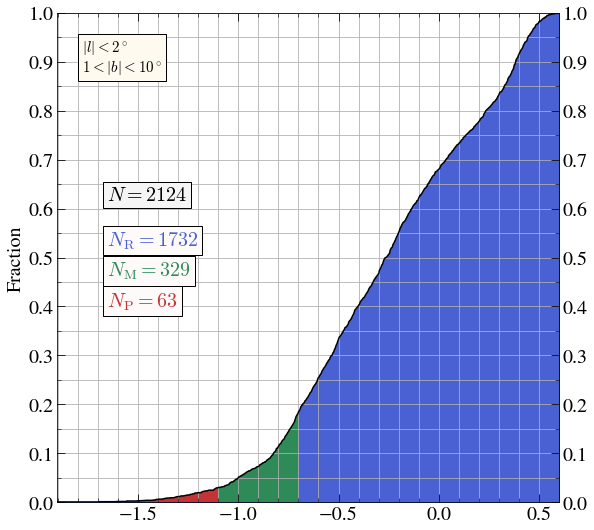

In [57]:
# Plot metallicity cumulative distribution

cumulative_bool = True
bins = 1000 if cumulative_bool else 50
if True: # Metallicity distribution
    fig,ax=plt.subplots()
    if cumulative_bool:
#         o_df_extra = o_df_extra[o_df_extra['FeH']>-1.5]
        h=ax.hist(o_df_extra['FeH'],bins=bins,cumulative=True,density=True,alpha=0)
        ax.set_ylim(0,1)
        ax.set_yticks(np.arange(0,1+0.1,0.1))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        plt.grid(which='both')
        ax.set_ylabel('Fraction')
        ax.tick_params(labelright=True)
    else:
        h=ax.hist(o_df_extra['FeH'],bins=bins,alpha=0,density=True)
        ax.set_ylabel(r'$N$',rotation=0,labelpad=20)
    ax.set_xlim(o_df_extra['FeH'].min(),o_df_extra['FeH'].max())
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    
    x,y=MF.get_plot_values_from_hist(h)
    ax.plot(x,y,color='k')
    for cut_away,color,step in zip([x>metal_poor_highlim, (x<metal_poor_highlim)|(x>metal_rich_lowlim), x<metal_rich_lowlim], [red,green,blue], ['pre','mid','post']):
        x,y=MF.get_plot_values_from_hist(h)
        y[cut_away] = 0
        ax.fill_between(x=x,y1=0,y2=y,color=color,step=step)
    
    y_string_min,y_string_diff = 0.4, 0.062
    ax.text(x=0.1,y=y_string_min+3.5*y_string_diff,s=r"$N=%i$"%len(o_df_extra),transform=ax.transAxes,bbox={'facecolor':'whitesmoke'})#;ax.tick_params(labeltop=True)
    for df,color,y_string,lab in zip(df_metals,[blue,red,green],[y_string_min+2*y_string_diff,y_string_min,y_string_min+y_string_diff],['R','P','M']):
        ax.text(x=0.1,y=y_string,s=r"$N_\mathrm{%s}=%i$"%(lab,len(df)),color=color,transform=ax.transAxes,bbox={'facecolor':'snow'})#;ax.tick_params(labeltop=True)
    
    l_cut = f"|l|<{lmax}" if lmin==-lmax else f"{lmin}<|l|<{lmax}"
    b_cut = f"|b|<{bmax}" if bmin==0 else f"{bmin}<|b|<{bmax}"
    ax.text(x=0.05,y=0.88,size=15,s=r"$%s^\circ$"%l_cut+'\n'+r"$%s^\circ$"%b_cut,transform=ax.transAxes,bbox={'facecolor':'floralwhite'})
    #ax.set_title(r"$%s^\circ$,  $%s^\circ$"%(l_cut,b_cut));ax.set_xlabel('[Fe/H]')
    
    if save_metal:
        filename = 'cum_' if cumulative_bool else ''
        lb_cut_string = f'{lmin}l{lmax}_{bmin}b{bmax}'
        filename += f'metal_%s_{metal_poor_highlim}FeH{metal_rich_lowlim}'%(lb_cut_string)
        plt.savefig(save_path_pop+filename+'.png',dpi=200,bbox_inches='tight')
        print("Saved:\t",save_path_pop+filename)
    plt.show()

Velocity distributions APOGEE

data_vel_lim = 400
bins = np.linspace(-data_vel_lim,data_vel_lim,20)

fig,axs = plt.subplots(figsize=(15,5),ncols=2,sharey=True,gridspec_kw={'wspace':0})
axs[0].hist(df_metals[0]['vl'],bins,alpha=1,label=r'rich $v_l$',color='blue')
axs[0].hist(df_metals[0]['vr'],bins,alpha=0.6,label=r'rich $v_r$',color='red')
axs[1].hist(df_metals[1]['vl'],bins,alpha=1,label=r'poor $v_l$',color='blue')
axs[1].hist(df_metals[1]['vr'],bins,alpha=0.6,label=r'poor $v_r$',color='red')
axs[0].set_ylabel(r"$N$",rotation=0,labelpad=20)
axs[0].set_xlabel(r"$v$ [km s$^{-1}$]")
axs[0].set_xticks(np.linspace(-data_vel_lim,data_vel_lim,11))
axs[1].set_xlabel(r"$v$ [km s$^{-1}$]")
axs[1].set_xticks(np.linspace(-data_vel_lim,data_vel_lim,11))
for ax in axs:
    ax.set_xlabel(r"$v$ [km s$^{-1}$]")
    ax.set_xticks(np.concatenate([[0],np.linspace(-sim_vel_lim,sim_vel_lim,6)]))
fig.legend(ncol=2,loc='upper center')
#plt.savefig(save_path_pop+'velocities_apogee.pdf',bbox_inches='tight',dpi=200)
plt.show()

### Plot

In [193]:
#CHOOSE
sim_bool = True
# sim_bool = False

if sim_bool:
    df_list = df_ages
    pop_list = sim_pop_strings
else:
    df_list = df_metals
    pop_list = o_pop_strings

In [194]:
# correct_rot_broadening = True
correct_rot_broadening = False

if correct_rot_broadening:
    # d_step = 1 if sim_bool else 2
    d_step = 1
    # d_step = 2
    
    d_range = np.arange(dmin,dmax,d_step)
else:
    d_step = dmax-dmin
    d_range = [dmin]

In [195]:
# downsampling_bool = True
downsampling_bool = False

downsampling_n = 100 if downsampling_bool else 1
downsampling_age = 9.972

if downsampling_bool:
    downsamples = []
    
    downsampling_size = len(df_extra[df_extra['age']>downsampling_age])

In [196]:
show_positions = True
# show_positions = False

save_positions = True
# save_positions = False

save_vel = True
# save_vel = False

In [200]:
min_star_number = 100
bootstrap_repeat = 100 if sim_bool else 1000
smoothing = 0 # If -1, it will default to 1 if N>300 else 2

only_young = True
# only_young = False
# only_old = True
only_old = False

4Age7
Saved pos:  C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/wider_long/-20l20_3b10_6d10/sim/_xy.png


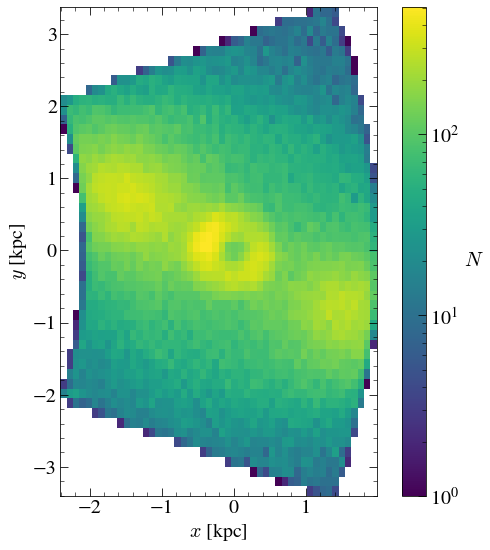

Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/velocity_plots/wider_long/-20l20_3b10_6d10/sim/4Age7_smooth0.png


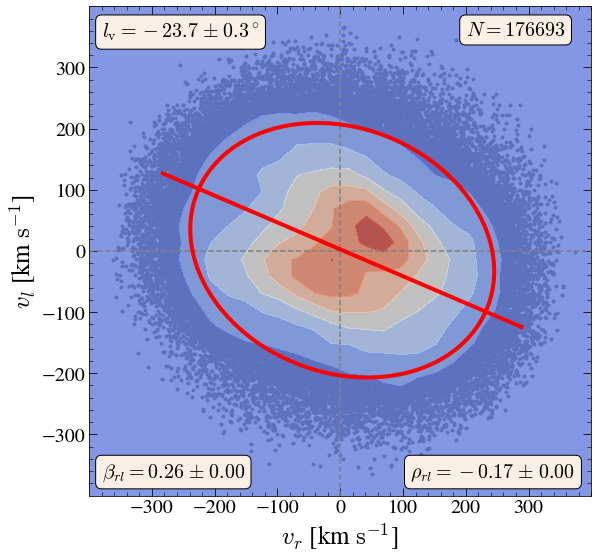

In [202]:
for j in range(downsampling_n):
    for d in d_range:
        for i,(df,pop_string) in enumerate(zip(df_list,pop_list)):
            if i != 0 and only_young: continue
            if i % 2 == 0 and only_old: continue
            
            df_d = df[(df['d']>d)&(df['d']<d+d_step)]
            vr = df_d.vr.values
            vl = df_d.vl.values

            if downsampling_bool: # Check effect of downsampling. Not sure if it's statistically "legal"
                if j == 0:
                    print(f"Downsampling {pop_string} to {downsampling_age}Age, reducing size from {len(df)} to {downsampling_size}")
                indices = np.random.choice(np.arange(len(vr)),size=downsampling_size,replace=False)
                vr = vr[indices]
                vl = vl[indices]
            
            if True: #strings
                if correct_rot_broadening: 
                    pop_string += f"_{d}d{d+d_step}"
                if downsampling_bool:
                    pop_string += '_downsampled'
                sim_string = 'sim/' if sim_bool else 'data/'
                d_string = 'd_steps/' if correct_rot_broadening else ''
                if not downsampling_bool:
                    print(pop_string)
                    
            if show_positions:
                fig,ax=plt.subplots()
                h=ax.hist2d(df_d['x'],df_d['y'],bins=50,norm=LogNorm())
                ax.set(xlabel=r'$x$ [kpc]',ylabel=r'$y$ [kpc]')
                ax.set_aspect('equal')
                cbar=plt.colorbar(h[3],shrink=1)
                cbar.ax.set_ylabel(r"$N$",rotation=0,labelpad=15)
                if save_positions:
                    plt.savefig(save_path_total+pop_string+"_xy.png",bbox_inches='tight',dpi=300)
                    print("Saved pos: ",save_path_total+"_xy.png")
                plt.show()
            
            save_path_total = save_path_pop+sim_string+d_string
            
            if smoothing != -1: pop_string += f'_smooth{smoothing}'
            
            var_dict = velocity_plot.velocity_plot(vr, vl, smoothing=smoothing,save_path = save_path_total, population_string = pop_string, bootstrap_repeat=bootstrap_repeat,
                                                   show= not downsampling_bool, save=save_vel and not downsampling_bool, return_dict = downsampling_bool)
            
            if downsampling_bool:
                downsamples.append(var_dict)
                if j%5 == 0: print(j)

#### Downsampling

In [292]:
downsampled_variables = [[] for _ in range(len(downsamples[0].keys()))]

for i,key in enumerate(downsamples[0].keys()):
    for dic in downsamples:
        downsampled_variables[i].append(dic[key])

In [299]:
val_index = 0 # 0 2 4
err_index = val_index + 1

save_path_down = save_path_pop+'sim/'
filename = f'downsampling_{old_min}-{downsampling_age}_'+list(downsamples[0].keys())[val_index]+f'_{downsampling_n}' if downsampling_n != 100 else ''
print(filename)

downsampling_9.97-9.972_vertex_500


Saved:	 C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/scaling_1.7/age_metal/-6l6_3b9_6d10/sim/downsampling_9.97-9.972_vertex_500.png


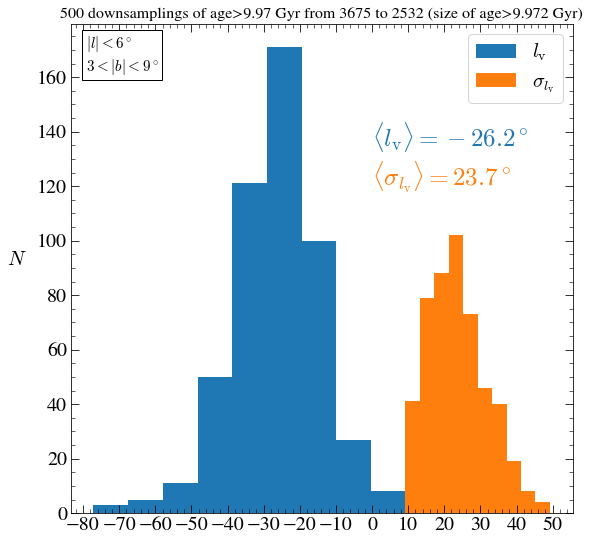

In [305]:
save_bool_down = True

if True: # Plot
    if val_index % 2: raise ValueError("Variable index should be even!")
    var,err = list(downsamples[0].keys())[val_index], list(downsamples[0].keys())[err_index]

    fig,ax=plt.subplots()
    if var == 'vertex':
        var_bins = None
        err_alpha = None
        x_string = 0.6
        y_string = 0.75
        leg_loc = 'best'
        n_dec = '%.1f'
        ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    elif var == 'anisotropy':
        var_bins = None
        err_alpha = 0.9
        x_string = 0.7
        y_string = 0.7
        leg_loc = 'best'
        n_dec = '%.2f'
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
    elif var == 'correlation':
        var_bins = None
        err_alpha = None
        x_string = 0.54
        y_string = 0.7
        leg_loc = 'upper center'
        n_dec = '%.3f'
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
    ax.hist(downsampled_variables[val_index],label=r"$%s$"%only_symbol_dict[var],bins=var_bins)
    ax.hist(downsampled_variables[err_index],label=r"$\sigma_{%s}$"%only_symbol_dict[var],alpha=err_alpha)
    ax.text(x=x_string,y=y_string,color='tab:blue',s=fr"$\langle %s \rangle = {n_dec} %s$"%(only_symbol_dict[var],np.mean(downsampled_variables[val_index]),units_dict[var]),transform=ax.transAxes,fontsize=25)
    ax.text(x=x_string,y=y_string-0.08,color='tab:orange',s=r"$\langle \sigma_{%s} \rangle"%only_symbol_dict[var] +fr"= {n_dec}"%np.mean(downsampled_variables[err_index])+r"%s$"%units_dict[var],transform=ax.transAxes,fontsize=25)
    ax.text(x=0.03,y=0.905,fontsize=15,s=fr"$|l|<{lmax}^\circ$"+"\n"+fr"${bmin}<|b|<{bmax}^\circ$",transform=ax.transAxes,bbox={'facecolor':'w'})
    ax.set_title(f"{downsampling_n} downsamplings of age>{old_min} Gyr from {len(df_list[1])} to {downsampling_size} (size of age>{downsampling_age} Gyr)",size=16)
    ax.set_ylabel(r"$N$",rotation=0,labelpad=20)
    plt.legend(loc=leg_loc)
    if save_bool_down:
        plt.savefig(save_path_down+filename+'.png',dpi=200,bbox_inches='tight')
        print("Saved:\t",save_path_down+filename+'.png')
    plt.show()

## Kinematics vs age/FeH

In [20]:
def get_base_path():
    return general_path+'graphs/Observations/Apogee/individual_variable/age_metal/'

def get_save_path_POPPLOT_spatial_cuts(extra_variable,extra_min,extra_max,depth_var,depth_min,depth_max,height_var,height_min,height_max):
    """
    Expected values:
    
    extra_variable = "R" or "d"
    depth_var = "l" or "y"
    height_var = "b" or "z"
    """
    
    save_path = get_base_path()

    save_path += f"{MF.return_int_or_dec(extra_min,2)}{extra_variable}{MF.return_int_or_dec(extra_max,2)}/"
    MF.create_dir(save_path)

    save_path += f"{MF.return_int_or_dec(depth_min,2)}{depth_var}{MF.return_int_or_dec(depth_max,2)}/"
    MF.create_dir(save_path)
    
    save_path += f"{MF.return_int_or_dec(height_min,2)}{height_var}{MF.return_int_or_dec(height_max,2)}/"
    MF.create_dir(save_path)
    
    return save_path

def get_save_path_POPPLOT_data(save_path_spatial, binning_str, pop_str):
        
    save_path = save_path_spatial + "data/"
    MF.create_dir(save_path)
    
    save_path += f"{binning_str}/"
    MF.create_dir(save_path)
    
    save_path += f"{pop_str}/"
    MF.create_dir(save_path)
        
    return save_path

def get_save_path_POPPLOT_sim(save_path_spatial, binning_str, pop_str):
        
    save_path = save_path_spatial + "sim/"
    MF.create_dir(save_path)
    
    save_path += f"{binning_str}/"
    MF.create_dir(save_path)
    
    save_path += f"{pop_str}/"
    MF.create_dir(save_path)
        
    return save_path

In [21]:
# metal_lowcut = -9999
metal_lowcut = -1

try:
    data_trim = data[data['FeH']>=metal_lowcut]
    print(f"Chose minimum metallicity of {metal_lowcut}" if metal_lowcut != -9999 else "No minimum metallicity")
except NameError:
    print("Working with simulation only")

Chose minimum metallicity of -1


### Latitude ranges

Currently chosen according to the data.

In [99]:
depth_variable_lims = {
    "l": [-2,2],
    "y": [-0.1,0.1]
}

overall_height_variable_lims = {
    "b": [1.5,9],
    "z": [0.2,2]
}

extra_variable_lims = {
    "d": [6.1,10.1],
    "R": [0,3.5]
}

# CHOOSE
# extra_variable = "d"
extra_variable = "R"
depth_var = "l"
height_var = "b"

if True: # print
    depth_min,depth_max = depth_variable_lims[depth_var]
    overall_height_min,overall_height_max = overall_height_variable_lims[height_var]
    extra_min,extra_max = extra_variable_lims[extra_variable]
    
    print(depth_var,depth_min,depth_max)
    print(height_var,overall_height_min,overall_height_max)
    print(extra_variable,extra_min,extra_max)

l -2 2
b 1.5 9
R 0 3.5


In [100]:
if height_var == "b":
    o_b_range_min,o_b_range_max = PH.get_equal_n_minmax_b_ranges(data_trim, n_points=3,\
                                                                 extra_variable=extra_variable,extra_min=extra_min,extra_max=extra_max,\
                                                                 depth_min=depth_min,depth_max=depth_max,\
                                                                 overall_bmin=overall_height_min,overall_bmax=overall_height_max)

In [101]:
lat_bin_idx = 2

if height_var == "b":
    bmin = o_b_range_min[lat_bin_idx]
    bmax = o_b_range_max[lat_bin_idx]

    print(bmin, MF.return_int_or_dec(bmin,2))
    print(bmax, MF.return_int_or_dec(bmax,2))

7.13475639098 7.13
8.85301437083 8.85


I will apply the same latitude binning (using 0R3.5) for the different radial variations (eg 0R2, for which the equal-number latitude binning would change slightly)

### Sim

In [102]:
data_bool = False

In [126]:
depth_variable_lims = {
    "l": [-2,2],
    "y": [coordinates.ang_to_rect(ang=-2,x=coordinates.get_solar_radius()), coordinates.ang_to_rect(ang=2,x=coordinates.get_solar_radius())]
}

height_variable_lims = {
    "b": [bmin,bmax],
    "z": [coordinates.ang_to_rect(bmin,x=R0), coordinates.ang_to_rect(bmax,x=R0)]
} if "bmin" in globals() and "bmax" in globals() else {
    "b": [1.5,9],
    "z": [0.2,2]
}

extra_variable_lims = {
    "d": [6.1,10.1],
    "R": [0,2]
}

# CHOOSE
# extra_variable = "d"
extra_variable = "R"
depth_var = "y"
height_var = "z"

if True: # print
    depth_min,depth_max = depth_variable_lims[depth_var]
    height_min,height_max = height_variable_lims[height_var]
    extra_min,extra_max = extra_variable_lims[extra_variable]
    
    print(depth_var,depth_min,depth_max)
    print(height_var,height_min,height_max)
    print(extra_variable,extra_min,extra_max)

y -0.2828582328831566 0.2828582328831566
z 1.0138985108337137 1.2616216980786246
R 0 2


visualise_cuts_z1.01_z1.26_R2_R3.5_b7.13_b8.85_xz_-0.28y0.28


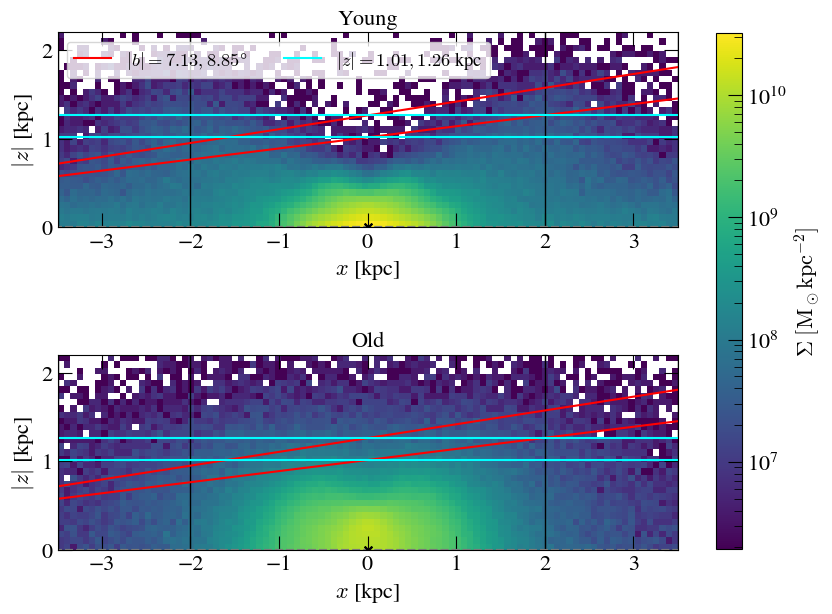

In [127]:
# save_bool = True
save_bool = False

# projection = "xy"
projection = "xz"

plt.rcParams["font.size"] = 16

if True: # visualise cuts for young and old

    xymax = 3.5

    zmax = 2.2
    zmin = (0 if zabs else -zmax) if projection == "xz" else 0.5

    bins_x=100

    young_ages,old_ages = [4,7],[9.5,10]

    if True:

        aspect_ratio = 2*(zmax-zmin)/(1.5*xymax) if projection == "xz" else 1

        fig,axs=plt.subplots(figsize=(10,aspect_ratio*10),nrows=2,gridspec_kw={"hspace":0})

        if True: # quick show & colorbar

            spatial_cut_dict = { depth_var:[depth_min,depth_max] } if projection == "xz" else { "z":[zmin,zmax]}
            young_cut_dict,old_cut_dict = {"age":young_ages}, {"age":old_ages}

            if projection == "xz":
                c1 = MP.quick_show_xz(MF.apply_cuts_to_df(df0,[spatial_cut_dict,young_cut_dict]),bins_x=bins_x,zmin=zmin,zmax=zmax,xmin=-xymax,xmax=xymax,show=False)
                c2 = MP.quick_show_xz(MF.apply_cuts_to_df(df0,[spatial_cut_dict,old_cut_dict]),bins_x=bins_x,zmin=zmin,zmax=zmax,xmin=-xymax,xmax=xymax,show=False)
            elif projection == "xy":
                c1 = MP.quick_show_xy(MF.apply_cuts_to_df(df0,[spatial_cut_dict,young_cut_dict]),bins_x=bins_x,ymin=-xymax,ymax=xymax,xmin=-xymax,xmax=xymax,show=False)
                c2 = MP.quick_show_xy(MF.apply_cuts_to_df(df0,[spatial_cut_dict,old_cut_dict]),bins_x=bins_x,ymin=-xymax,ymax=xymax,xmin=-xymax,xmax=xymax,show=False)
            else:
                raise ValueError("Only xy and xz currently supported")

            norm = PH.get_norm_from_count_list([c1,c2],log=True)

            if projection == "xz":
                _ = MP.quick_show_xz(MF.apply_cuts_to_df(df0,[spatial_cut_dict,young_cut_dict]),bins_x=bins_x,zmin=zmin,zmax=zmax,xmin=-xymax,xmax=xymax,ax=axs[0],norm=norm)
                _ = MP.quick_show_xz(MF.apply_cuts_to_df(df0,[spatial_cut_dict,old_cut_dict]),bins_x=bins_x,zmin=zmin,zmax=zmax,xmin=-xymax,xmax=xymax,ax=axs[1],norm=norm)
            elif projection == "xy":
                _ = MP.quick_show_xy(MF.apply_cuts_to_df(df0,[spatial_cut_dict,young_cut_dict]),bins_x=bins_x,ymin=-xymax,ymax=xymax,xmin=-xymax,xmax=xymax,ax=axs[0],norm=norm)
                _ = MP.quick_show_xy(MF.apply_cuts_to_df(df0,[spatial_cut_dict,old_cut_dict]),bins_x=bins_x,ymin=-xymax,ymax=xymax,xmin=-xymax,xmax=xymax,ax=axs[1],norm=norm)
            else:
                raise ValueError("Only xy and xz currently supported")

            plt.colorbar(cm.ScalarMappable(norm=norm,cmap="viridis"),ax=axs,shrink=0.8,label=mass_density_label)

        if True: # visualise cuts & legend

            cuts_to_visualise = {depth_var:[depth_max],height_var:[height_min,height_max],"R":[2,3.5],"l":[2]}
            if height_var == "z":
                cuts_to_visualise["b"] = [bmin,bmax]

            filename,_ = MP.visualise_bulge_selection(given_axs=axs[::-1],projection=projection,cuts_dict=cuts_to_visualise,R0=R0)
            _,_ = MP.visualise_bulge_selection(given_axs=axs,projection=projection,cuts_dict=cuts_to_visualise,R0=R0)

            axs[0].legend(loc="upper right" if projection=="xy" else "upper left",framealpha=0.8,ncols=1 if projection=="xy" else 2)

        for i,ax in enumerate(axs): # lims, aspect, titles
            ax.set_xlim(-xymax,xymax)
            ax.set_ylim(zmin,zmax) if projection == "xz" else ax.set_ylim(-xymax,xymax)
            ax.set_aspect("equal")

            if projection == "xy":
                ax.text(x=0.03,y=0.97,s=["Young","Old"][i],transform=ax.transAxes,bbox={"facecolor":"w","alpha":0.9},ha="left",va="top")
            if projection == "xz":
                ax.set_title(["Young","Old"][i])

        if True: # filename and saving

            filename += f"_{projection}" if projection != "both" else ""

            filename += f"_{MF.return_int_or_dec(depth_min,2)}{depth_var}{MF.return_int_or_dec(depth_max,2)}" if projection == "xz" \
                        else f"_{MF.return_int_or_dec(zmin,2)}z{MF.return_int_or_dec(zmax,2)}"

            print(filename)

            if save_bool:
                if os.path.isdir(f"{general_path}graphs/other_plots/visualise_bulge_cuts/youngold_cbar/{projection}/"):
                    save_path = f"{general_path}graphs/other_plots/visualise_bulge_cuts/youngold_cbar/{projection}/"
                else:
                    raise ValueError("Save path not specified")

                print("Saving in:",save_path)

                plt.savefig(save_path+filename+".png", dpi=200,bbox_inches="tight")
                print(fileformat)

        plt.show()

In [128]:
min_age,max_age = 4,10

df_extra = MF.apply_cuts_to_df(df0,cuts_dict={depth_var:[depth_min,depth_max],height_var:[height_min,height_max],\
                                              extra_variable:[extra_min,extra_max],"age":[min_age,max_age]})

print(len(df_extra),"stars")

18749 stars


In [135]:
sim_plot_median = False

equal_number = True
manual_ages = False
equal_steps = False; old_subplots = False

n_points_sim = 15

In [136]:
assert manual_ages + equal_steps + equal_number == 1, "Select a single option"
binning_str_sim = np.array(["custom_range","equalSteps","equalN"])[np.array([manual_ages,equal_steps,equal_number])][0]
print("Using",binning_str_sim)

if manual_ages:
    
    if old_subplots:
#         pop_str_sim = "0to9in1_oldSplit"
#         pop_min_range = np.array([0,4,5,6,7,8, 9,   9.5, 9.8,  9.9,   9.925, 9.95, 9.975])
#         pop_max_range = np.array([4,5,6,7,8,9, 9.5, 9.8, 10,   9.925, 9.95,  9.975, 10])

        pop_str_sim = "4to9in1_oldSplit"
        pop_min_range = np.array([4,5,6,7,8, 9,   9.5, 9.8,  9.9,   9.925, 9.95, 9.975])
        pop_max_range = np.array([5,6,7,8,9, 9.5, 9.8, 10,   9.925, 9.95,  9.975, 10])
        
        max_age_lim = 9
        
        limit_index = np.where(pop_max_range == max_age_lim)[0][0] + 1
    else:
        pop_str_sim = "4to10in1"
        pop_min_range = np.array([min_age,5,6,7,8, 9])
        pop_max_range = np.array([5,6,7,8,9, max_age])

elif equal_number:
    equalN_age_bins = PH.get_equal_n_bin_edges(val_array=df_extra["age"].values,n_bins=n_points_sim,pandas_way=True)
    
    pop_min_range = equalN_age_bins[:-1]
    pop_max_range = equalN_age_bins[1:]
    
    pop_str_sim = f"{n_points_sim}_datapoints"
    
elif equal_steps:
    #Define set of ages to calculate the vertex deviation in
    max_age_lim = 9
    
    age_step_young = 1
    
    all_min_range = np.arange(min_age,max_age_lim+age_step_young,age_step_young)
    all_max_range = all_min_range + age_step_young
    
    if old_subplots:
        # Smaller intervals for older population
        age_limit_old = 9.9
        age_step_old = 0.025

        old_min_range = np.arange(age_limit_old, max_age_lim, age_step_old)
        old_max_range = old_min_range + age_step_old    

        pop_min_range = np.concatenate([all_min_range, old_min_range])
        pop_max_range = np.concatenate([all_max_range, old_max_range])
        
        limit_index = np.where(pop_max_range == max_age_lim)[0][0] + 1
else:
    raise ValueError("Unknown binning method.")
    
assert len(pop_min_range) == len(pop_max_range), "Lengths need to be equal"

if sim_plot_median:
    """
    I'd rather not do this, and show the values at the mid-point of the bin instead, because otherwise I need to give 
    some other indication of the width of each bin, and I don't want to show x-error bars as they'd look ugly given 
    I show the values as a surface with fill_between.
    """
    
    pop_plot_range = PH.get_range_medians(df_extra["age"],pop_min_range,pop_max_range)
    print("Plotting at the median\n",pop_plot_range)
else:
    pop_plot_range = np.array([np.mean([m,M]) for m,M in zip(pop_min_range,pop_max_range)])
    print("Plotting at the mean\n",pop_plot_range)

Using equalN
Plotting at the mean
 [5.31531262 7.06625009 7.76018739 8.19518757 8.51406288 8.76131258
 8.97195813 9.15845811 9.31656218 9.45343733 9.57093763 9.66918755
 9.75950003 9.84031248 9.93281221]


In [137]:
# number of stars per bin
stat.binned_statistic(values=None,x=df_extra["age"].values,bins=equalN_age_bins,statistic="count")[0]

array([1249., 1248., 1253., 1248., 1248., 1254., 1250., 1248., 1250.,
       1247., 1251., 1253., 1243., 1254., 1253.])

lengths = []
for individual_age in ages_range:
    age_step = age_step_young if individual_age < age_limit_oldyoung else age_step_old
    
    age_max = individual_age + age_step
    age_min = individual_age
    df = df_extra[(df_extra.age>=age_min)&(df_extra.age<age_max)]
    lengths.append(len(df))
    print("Age interval", np.float16(age_min), "to", np.float16(age_max),"has",len(df),"stars")
print("Total number of stars selected across time:",np.sum(lengths))
print("Which is "+str(np.float16(100*np.sum(lengths)/len(df0)))+"% of the total")
del df

### Data

In [77]:
data_bool = True

In [78]:
depth_variable_lims = {
    "l": [-2,2],
    "y": [-0.1,0.1]
}

height_variable_lims = {
    "b": [bmin,bmax],
    "z": [np.tan(bmin*np.pi/180)*R0, np.tan(bmax*np.pi/180)*R0]
} if "bmin" in globals() and "bmax" in globals() else {
    "b": [1.5,9],
    "z": [0.2,2]
}

extra_variable_lims = {
    "d": [6.1,10.1],
    "R": [0,3.5]
}

# CHOOSE
# extra_variable = "d"
extra_variable = "R"
depth_var = "l"
height_var = "b"

if True: # print
    depth_min,depth_max = depth_variable_lims[depth_var]
    height_min,height_max = height_variable_lims[height_var]
    extra_min,extra_max = extra_variable_lims[extra_variable]
    
    print(depth_var,depth_min,depth_max)
    print(height_var,height_min,height_max)
    print(extra_variable,extra_min,extra_max)

l -2 2
b 7.13475639098 8.85301437083
R 0 3.5


In [79]:
data_extra = MF.apply_cuts_to_df(data_trim,cuts_dict={depth_var:[depth_min,depth_max],height_var:[height_min,height_max],\
                                              extra_variable:[extra_min,extra_max]})

print(len(data_extra))

351


In [80]:
equal_number = True # divide in equal-number bins across all metallicities
manual_metal = False
equal_steps = False # divide in constant metallicity steps

plot_median_bool = True
# plot_median_bool = False # mid-point of bin

n_points_data = 3

In [81]:
assert manual_metal + equal_steps + equal_number == 1, "Select a single option"
binning_str_data = np.array(["custom_range","equalSteps","equalN"])[np.array([manual_metal,equal_steps,equal_number])][0]

if manual_metal:
    min_metal,max_metal = min(data_extra["FeH"]),max(data_extra['FeH'])
    
    pop_str_data = "metal_cuts_equal"
    pop_min_range = np.array([min_metal, -0.55, -0.25, 0.15])
    pop_max_range = np.array([-0.55,-0.25,0.15,max_metal])

#     pop_str_data = "metal_cuts_A"
#     pop_min_range = np.array([min_metal, -0.7, -0.4, -0.1, 0.3])
#     pop_max_range = np.array([-0.7,-0.4,0.1,0.3,max_metal])
    
#     pop_str_data = "metal_cuts_B"
#     pop_min_range = np.array([min_metal, -1, -0.5, 0,0.3])
#     pop_max_range = np.array([-1,-0.5,0,0.3,max_metal])
    
#     pop_str_data = "all_poor"
#     pop_max_range = np.array([-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7])
#     pop_min_range = np.array([min_metal]*len(pop_max_range))

#     pop_str_data = "axisymmetric"
#     pop_min_range = np.array([-1.2, -1.2, -1.2, -1.1,-1.1, -1,-1,-1])
#     pop_max_range = np.array([-0.9,-0.8,-0.7,-0.9,-0.8,-0.7, -0.6,-0.5])

#     pop_str_data = "all_rich"
#     pop_min_range = np.array([-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0])
#     pop_max_range = np.array([max_metal]*len(pop_min_range))
    
    pass
elif equal_steps:
    min_metal = data_extra['FeH'].min()
    metal_step = 0.1
    pop_min_range = np.arange(min_metal,data_extra['FeH'].max(),metal_step)
    pop_max_range = pop_min_range + metal_step
    
    pop_str_data = f"{metal_step}step"  
elif equal_number:
    
    pop_str_data = f"{n_points_data}_datapoints"
    
    metal_edges = PH.get_equal_n_bin_edges(data_extra.FeH.values, n_points_data)
    pop_max_range = metal_edges[1:]
    pop_min_range = metal_edges[:-1]

if True: # pop_plot_range
    if manual_metal and range_str in ["all_rich","all_poor"]:
        if range_str == "all_rich":
            pop_plot_range = pop_min_range
        if range_str == "all_poor":
            pop_plot_range = pop_max_range
    elif plot_median_bool:
        pop_plot_range = PH.get_range_medians(data_extra.FeH.values, pop_min_range, pop_max_range)
    else:
        pop_plot_range = np.array([np.mean([m,M]) for m,M in zip(pop_min_range,pop_max_range)])
    
assert len(pop_min_range) == len(pop_max_range), "Lengths need to be equal"
print(pop_plot_range)

[-0.71704656 -0.36629653  0.05788045]


### Save path

In [138]:
save_path_spatial = get_save_path_POPPLOT_spatial_cuts(extra_variable,extra_min,extra_max,depth_var,depth_min,depth_max,height_var,height_min,height_max)

if data_bool:
    save_path = get_save_path_POPPLOT_data(save_path_spatial, binning_str_data, pop_str_data)
else:
    save_path = get_save_path_POPPLOT_sim(save_path_spatial, binning_str_sim, pop_str_sim)
    
print(save_path)

Created successfully
Created successfully
Created successfully
Created successfully
/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/1.01z1.26/sim/equalN/15_datapoints/


Saved /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/1.01z1.26/sim/equalN/15_datapoints/age_chosenRanges.png


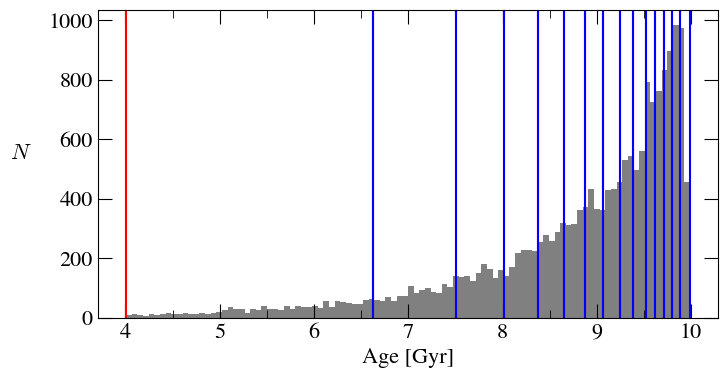

Saved /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/1.01z1.26/sim/equalN/15_datapoints/age_chosenRanges_log.png


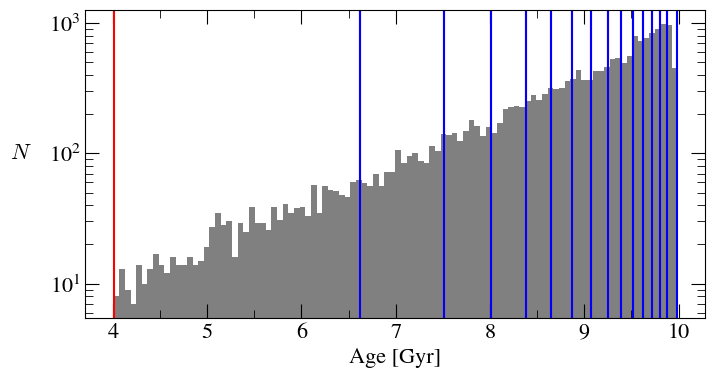

In [139]:
df = data_extra if data_bool else df_extra[(df_extra["age"]>=min_age)&(df_extra["age"]<=max_age)]
pop_var = "FeH" if data_bool else "age"
xlabel = "[Fe/H]" if data_bool else "Age [Gyr]"

MP.visualise_1D_binning(df[pop_var].values, pop_min_range, pop_max_range, hist_bins=100, log=False,\
                        save_bool=True,save_path=save_path,filename_prefix=pop_var,xlabel=xlabel)

if not data_bool:
    MP.visualise_1D_binning(df[pop_var].values, pop_min_range, pop_max_range, hist_bins=100, log=True,\
                            save_bool=True,save_path=save_path,filename_prefix=pop_var,xlabel=xlabel)

### Get arrays

In [140]:
bootstrap_repeat = 500
min_star_number = 100 if not data_bool else 50

In [141]:
vel_hist_bool = True
# vel_hist_bool = False

velhist_bins = 100 if not data_bool else 20

if vel_hist_bool:
    save_path_hist = save_path + "vel_histograms/"
    MF.create_dir(save_path_hist)
    
    save_path_hist += f"{velhist_bins}bins/"
    MF.create_dir(save_path_hist)
    
    print("Saving velocity histograms on\n",save_path_hist)

Created successfully
Created successfully
Saving velocity histograms on
 /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/1.01z1.26/sim/equalN/15_datapoints/vel_histograms/100bins/


if vel_hist_bool:
    MP.plot_velocity_histograms_both_stats(df[(df[pop_var]>=min(pop_min_range))&(df[pop_var]<=min(pop_max_range))],vel_x_variable,vel_y_variable,\
                                           bins=velhist_bins,colour_var="x",save_bool=False,suffix="example",verbose=True,show=True)

In [142]:
map_dict = {}
for map_string in full_map_string_list:
    map_dict[map_string] = np.zeros(shape=(len(pop_min_range)))
    
map_dict["mean_b"] = np.zeros(shape=(len(pop_min_range)))
map_dict["std_b"] = np.zeros(shape=(len(pop_min_range)))

for pop_index, (popmin, popmax) in enumerate(zip(pop_min_range,pop_max_range)):

    print(popmin,popmax)
    
    include_lims = "both" if pop_index==len(pop_min_range)-1 else "min"
    df_pop = MF.apply_cuts_to_df(df, cuts_dict={pop_var:[popmin,popmax]}, lims_dict={pop_var:include_lims})
        
    if vel_hist_bool:
        name_suffix = f"{str(MF.return_int_or_dec(popmin,dec=2))}pop{str(MF.return_int_or_dec(popmax,dec=2))}"
        MP.plot_velocity_histograms_both_stats(df_pop,vel_x_variable,vel_y_variable,save_bool=True,save_path=save_path_hist,suffix=name_suffix,verbose=pop_index==0,bins=velhist_bins)
        
    values = val_err.get_all_variable_values_and_errors(df_pop[f"v{vel_x_variable}"].values,df_pop[f"v{vel_y_variable}"].values, full_map_string_list,\
                                                            repeat=bootstrap_repeat, min_number = min_star_number)   

    if len(values) != len(full_map_string_list):
        raise ValueError("The length of the values list does not match the string list!")

    for map_string in full_map_string_list:
        map_dict[map_string][pop_index] = values[map_string]
        
    map_dict["mean_b"][pop_index] = np.mean(df_pop["b"])
    map_dict["std_b"][pop_index] = np.std(df_pop["b"])
    
del df_pop
print("Done")

4.007500171661377 6.623125076293945
velhists_meanstdx_4.01pop6.62
Saved in /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/1.01z1.26/sim/equalN/15_datapoints/vel_histograms/100bins/
6.623125076293945 7.509375095367432
7.509375095367432 8.01099967956543
8.01099967956543 8.379375457763672
8.379375457763672 8.648750305175781
8.648750305175781 8.873874855041505
8.873874855041505 9.07004140218099
9.07004140218099 9.246874809265137
9.246874809265137 9.386249542236328
9.386249542236328 9.520625114440918
9.520625114440918 9.62125015258789
9.62125015258789 9.717124938964846
9.717124938964846 9.801875114440918
9.801875114440918 9.87874984741211
9.87874984741211 9.9868745803833
Done


In [143]:
print(map_dict['number'])

[1249. 1248. 1253. 1248. 1248. 1254. 1250. 1248. 1250. 1247. 1251. 1253.
 1243. 1254. 1253.]


In [144]:
# save arrays

array_path = save_path + "arrays/"
MF.create_dir(array_path)

if True: # values as .txt and .npy
            
    with open(array_path+'values.txt','w') as f:
        for key in map_dict:
            f.write(key+'\n')
            np.savetxt(f,map_dict[key],fmt='%.5f')
            f.write('\n')
    
    for map_string in full_map_string_list:
        np.save(array_path+map_string, map_dict[map_string])
        
if True: # plot limits as .txt and .npy

    with open(array_path+'pop_ranges.txt','w') as f:
        f.write("pop_min_range\n")
        for mini in pop_min_range:
            f.write(f"{mini}\t")
        f.write("\n\npop_max_range\n")
        for maxi in pop_max_range:
            f.write(f"{maxi}\t")
        f.write("\n\npop_plot_range\n")
        for p in pop_plot_range:
            f.write(f"{p}\t")
    
    np.save(array_path+"pop_min_range", pop_min_range)
    np.save(array_path+"pop_max_range", pop_max_range)
    np.save(array_path+"pop_plot_range", pop_plot_range)
    
print("Saved .txt and .npy in",array_path)

Created successfully
Saved .txt and .npy in /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/1.01z1.26/sim/equalN/15_datapoints/arrays/


### Plot

In [881]:
# POPPLOT functions

# Takes global: bar_log, bar_width
def POPPLOT_number_bar(barax, plot_range, number_array,color,alpha=1,zorder=0):
    barax.bar(plot_range,number_array,width=(max(plot_range)-min(plot_range))/150,log=bar_log,color=color,alpha=alpha,zorder=zorder)
        
# Takes global: data_surface_bool, data_xerror_bool, data_lines_bool
def POPPLOT_values_data(ax, value_array, err_array, plot_range, min_range, max_range, color, label,line_alpha=1,zorder=0):
    
    if data_surface_bool:
        ax.plot(pop_plot_range,val_array,color=color,alpha=line_alpha,zorder=zorder)
        ax.fill_between(pop_plot_range,val_array-err_array,val_array+err_array,label=label,color=color,linewidth=0,alpha=line_alpha,zorder=zorder)
        
    else:
        xerror = PH.get_xerr(min_range,max_range,plot_range)

        ax.errorbar(plot_range,value_array,yerr=err_array,xerr=xerror if data_xerror_bool else None,capsize=capsize,marker='.',color=color,\
                    label=label,linestyle=None if data_lines_bool else '',alpha=line_alpha,zorder=zorder)
        
def POPPLOT_values_sim(ax, val_array, err_array, plot_range,color,label,line_alpha=1,surface_alpha=0.75,zorder=0):
    ax.plot(plot_range,val_array,color=color,alpha=line_alpha,zorder=zorder)
    ax.fill_between(plot_range,val_array-err_array,val_array+err_array,label=label,color=color,alpha=surface_alpha,linewidth=0,zorder=zorder)
        
def POPPLOT_number_bar_axis_settings(barax,min_n,max_n,bar_log=True,labels_on=True,min_shift_bool=True,max_shift_bool=True):
    if bar_log:
        exponent_ticks = np.arange(MF.get_exponent(min_n),MF.get_exponent(max_n)+1,1)
        barax.set_yticks([10**i for i in exponent_ticks])
        barax.set_ylim(bottom = 10**min(exponent_ticks) - (min_n/10 if min_shift_bool else 0))
        barax.set_ylim(top = max_n + (10**MF.get_exponent(max_n) if max_shift_bool else 0))
    elif equal_number:
        barax.set_yticks([0,max_n])
            
    barax.yaxis.set_tick_params(which='minor', right=True,left=False)

    barax.tick_params(which='both',labelleft=False,labelright=labels_on)
    barax.tick_params(which='minor',labelright=False)

    if labels_on:
        barax.set_ylabel(r"$N$",rotation=0,labelpad=20)
        barax.yaxis.set_label_position("right")
    
def POPPLOT_xaxis_settings(ax,xmin,xmax,xlabel,xticks=None,labels_on=True):
#     ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    
    ax.set_xlim(xmin,xmax)
    
    if xticks is not None:
        ax.set_xticks(xticks)
    
    if labels_on:
        ax.set_xlabel(xlabel)
    else:
        ax.set_xticklabels([])

def _POPPLOT_compute_ylims(map_dict, map_string, error_string, var1_bool=False):
    minimum = np.nanmin(map_dict[map_string]-map_dict[error_string])
    maximum = np.nanmax(map_dict[map_string]+map_dict[error_string])

    if var1_bool:
        minimum1 = np.nanmin(map_dict[var1]-map_dict[err1])
        maximum1 = np.nanmax(map_dict[var1]+map_dict[err1])

        minimum = min([minimum,minimum1])
        maximum = max([maximum,maximum1])
    
    if map_string in yshift_dict:
        minimum -= yshift_dict[map_string]
        maximum += yshift_dict[map_string]

    if symmetric_ylims_bool:
        maxabs = np.nanmax(np.abs([minimum,maximum]))
        ax.set_ylim(-maxabs,maxabs)
    else:
        ax.set_ylim(minimum,maximum)
        
def POPPLOT_yaxis_settings(ax, map_string, error_string, map_dict=None, labels_on=True,var1_bool=False, set_ylims=True):
    
    if map_string == 'tilt_abs':# or "mean" in map_string or "std" in map_string:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
        #ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    elif map_string == 'anisotropy':# or map_string == 'correlation':
#         ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    elif map_string == "correlation":
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.15))
#     elif map_string in ["mean_vx","mean_vy"]:
#         ax.yaxis.set_major_locator(ticker.MultipleLocator(15))
    elif map_string in ["std_vx","std_vy"]:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(25))
    
    if not var1_bool and labels_on:
        ax.set_ylabel(symbol_dict[map_string]+units_dict[map_string],fontsize=ylabel_size)
    
    if set_ylims:
        if hard_coded_ylims_bool and map_string in hard_coded_ylims:
            ax.set_ylim(hard_coded_ylims[map_string])
        else:
            if map_dict is None:
                raise ValueError("Cannot compute ylims if `map_dict` is None.")
            _POPPLOT_compute_ylims(map_dict, map_string, error_string, var1_bool=var1_bool)
        
    if not labels_on:
        ax.set_yticklabels([])
        
def get_label(map_string):
    return symbol_dict[map_string]+units_dict[map_string]

def get_legend_label(var_tuple,variable):
    var_symbol = pos_symbols_dict[variable]
    var_units = pos_units_dict[variable]
    
    if var_tuple[0] == 0:
        return var_symbol + fr"$< {var_tuple[1]}~$"+var_units
    else:
        return r"$%s<$"%str(var_tuple[0]) + var_symbol + r"$/\mathrm{%s}$"%var_units + fr"$<{var_tuple[1]}$"

#### Single

In [180]:
capsize = 5
ylabel_size = "medium"

data_xerror_bool = True
# data_xerror_bool = False

# bar_log = True
bar_log = False
# bar_log = not data_bool

data_lines_bool = True
# data_lines_bool = False

# data_surface_bool = True
data_surface_bool = False

sim_surface_bool = True
# sim_surface_bool = False

In [181]:
exponent_ticks = [1,2,3] if data_bool else [3,4,5]
xlabel = "[Fe/H]" if data_bool else "Age [Gyr]"

line_alpha = 0.75
surface_alpha = 0.75

In [197]:
var = 'mean_vx';        var1_bool=True
# var = 'anisotropy';     var1_bool=True
# var = "std_vx";         var1_bool=True
# var = 'tilt_abs';       var1_bool=False

err = var + "_error"

print(var,err)

color = 'steelblue'
if var1_bool:
    color = 'purple'
    color1 = 'orange'
    
    if var == 'anisotropy': var1 = 'correlation'
    elif "vx" in var: var1 = var.split("vx")[0] + "vy" + var.split("vx")[1]
    else: raise ValueError("Could not determine var1")
    
    err1 = var1+'_error'
    
    print(var1,err1)

mean_vx mean_vx_error
mean_vy mean_vy_error


In [198]:
# hard_coded_ylims_bool = True
hard_coded_ylims_bool = False
# hard_coded_ylims_bool = var == "tilt_abs"

# symmetric_ylims_bool = True
symmetric_ylims_bool = False

hard_coded_ylims = {
    "tilt_abs": [-45,3]
}

yshift_dict = {
    "anisotropy": 0.01,
    "tilt_abs": 5,
    "mean_b": 0.25,
    "std_vx": 1,
    "mean_vx": 1
}

legend_loc = "best"
# legend_loc = "upper left"

In [199]:
save_bool = True
# save_bool = False

vel
Saved in /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-2l2/7.13b8.85/sim/equalN/15_datapoints/


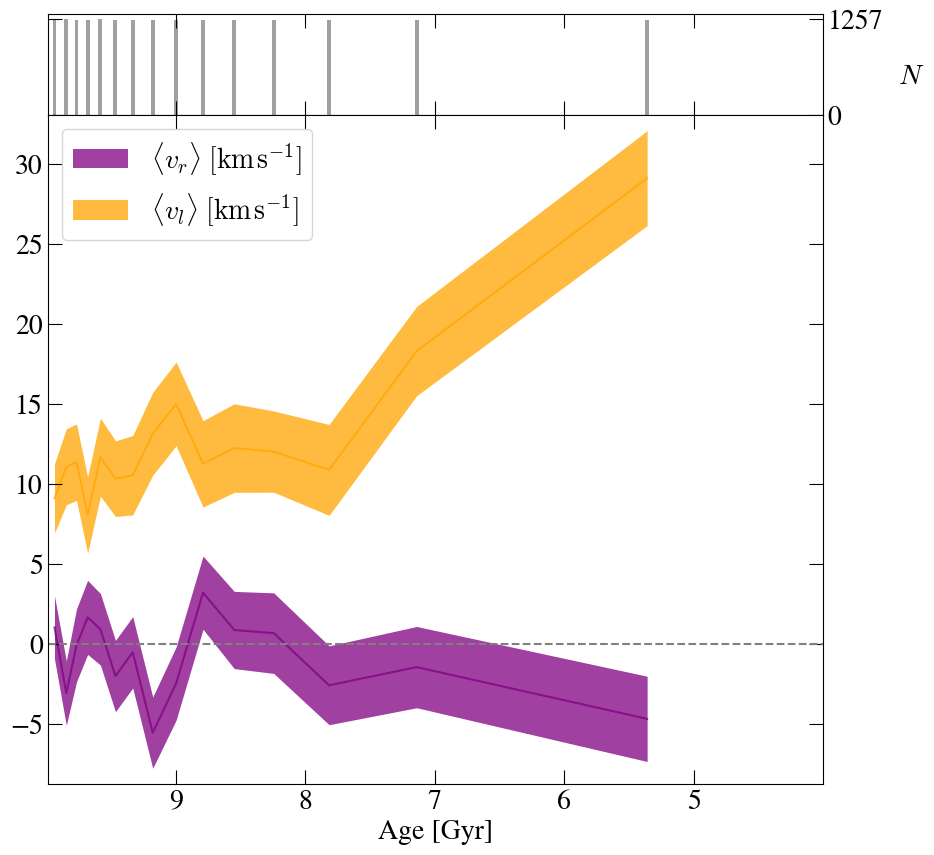

In [200]:
# plot

if True: # fig, bar, axhline
    fig,(barax,ax) = plt.subplots(figsize=(10,10),nrows=2,ncols=1, sharex=True,facecolor='w',gridspec_kw={'hspace':0,'height_ratios':[0.15,1]})

    POPPLOT_number_bar(barax, pop_plot_range, map_dict["number"],color="grey",alpha=line_alpha)
    POPPLOT_number_bar_axis_settings(barax,min_n=np.min(map_dict["number"]),max_n=np.max(map_dict["number"]))

if True: # plot
    
    if data_bool or not sim_surface_bool:
        POPPLOT_values_data(ax, map_dict[var], map_dict[err], pop_plot_range, pop_min_range, pop_max_range,color,get_label(var),alpha=line_alpha)
    else:
        POPPLOT_values_sim(ax,map_dict[var],map_dict[err],pop_plot_range,color,get_label(var),line_alpha=line_alpha,surface_alpha=surface_alpha)

    if var1_bool: # var1, legend
        if data_bool or not sim_surface_bool:
            POPPLOT_values_data(ax, map_dict[var1], map_dict[err1], pop_plot_range, pop_min_range, pop_max_range,color1,get_label(var1),alpha=line_alpha)
        else:
            POPPLOT_values_sim(ax,map_dict[var1],map_dict[err1],pop_plot_range,color1,get_label(var1),line_alpha=line_alpha,surface_alpha=surface_alpha)

        ax.legend(loc=legend_loc)
        
    if True: # zero line
        minima = [np.nanmin(map_dict[var]-map_dict[err])]
        maxima = [np.nanmax(map_dict[var]+map_dict[err])]
        if var1_bool:
            minima.append(np.nanmin(map_dict[var1]-map_dict[err1]))
            maxima.append(np.nanmax(map_dict[var1]+map_dict[err1]))
            
        zero_line_within_lims = False
        if hard_coded_ylims_bool and var in hard_coded_ylims:
            zero_line_within_lims = hard_coded_ylims[var][0] < 0 and hard_coded_ylims[var][1] > 0
            
        zero_line_within_lims_1 = False
        if var1_bool and hard_coded_ylims_bool and var1 in hard_coded_ylims:
            zero_line_within_lims_1 = hard_coded_ylims[var1][0] < 0 and hard_coded_ylims[var1][1] > 0
        
        if zero_line_within_lims or zero_line_within_lims_1 or PH.shall_plot_zero_line(minima,maxima):
            ax.axhline(y=0,linestyle='--',color='grey')

if True: # axis
    POPPLOT_xaxis_settings(ax,xmin=min(pop_min_range),xmax=max(pop_max_range),xlabel=xlabel)
    POPPLOT_yaxis_settings(ax,var,err,map_dict,var1_bool=var1_bool)
    
    if not data_bool:
        ax.invert_xaxis()

if True: # save

    filename = var
    if var1_bool: filename += var1

    if filename == 'anisotropycorrelation': filename = 'anicorr'
    elif filename == 'mean_vxmean_vy': filename = 'vel'

    if data_bool and data_lines_bool:
        filename += "_lines"

    if bootstrap_repeat != 500:
        filename += f'_boot{bootstrap_repeat}'

    print(filename)

    if save_bool:
        for formatting in ['.png','.pdf']:
            plt.savefig(save_path+filename+formatting,bbox_inches='tight',dpi=300)
        print("Saved in",save_path)
plt.show()

metal_poor = data_extra[(data_extra['FeH']>-1) & (data_extra['FeH'] < -0.5)]
vr = metal_poor.vr.values
vl = metal_poor.vl.values

velocity_plot.velocity_plot(vr,vl,tilt_abs=True)

##### Optimise cut

In [269]:
def compute_corr(plim,rlim,lowlim=data_extra['FeH'].min(),highlim=0.3):
    left_pop = data_extra[(data_extra['FeH']>lowlim)&(data_extra['FeH']<plim)]
    centre_pop = data_extra[(data_extra['FeH']>plim)&(data_extra['FeH']<rlim)]
    right_pop = data_extra[(data_extra['FeH']>rlim)&(data_extra['FeH']<highlim)]

    left_corr = CV.calculate_correlation(left_pop.vr.values,left_pop.vl.values)
    centre_corr = CV.calculate_correlation(centre_pop.vr.values,centre_pop.vl.values)
    right_corr = CV.calculate_correlation(right_pop.vr.values,right_pop.vl.values)
    
    return left_corr,centre_corr,right_corr

In [310]:
lowlim = data_extra['FeH'].min()
highlim = 0.3

# Initial guesses
plim = -0.5
rlim = -0.2

step = 0.1
combinations = [[i,j] for i in [-step,0,step] for j in [-step,0,step]]

l,c,r = compute_corr(plim,rlim) # We want largest l, lowest |c|, lowest r

In [311]:
iterations = 100

while iterations:    
    
    for comb in combinations:
        new_plim = plim+comb[0]
        new_rlim = rlim+comb[1]
        new_l,new_c,new_r = compute_corr(new_plim,new_rlim)
        
        if new_l > l and abs(new_c) < abs(c) and new_r < r:
            plim,rlim = new_plim,new_rlim
            l,c,r = new_l,new_c,new_r
        elif new_l > l and abs(new_c) < abs(c):
            plim = new_plim
            l,c = new_l,new_c
        elif abs(new_c) < abs(c) and new_r < r:
            rlim = new_rlim
            c,r = new_c,new_r
        
        #print("%.4f\t%.4f"%(plim, rlim))
        
    iterations -= 1

In [312]:
plim, rlim

(-0.5, -0.1)

Using smoothing 2


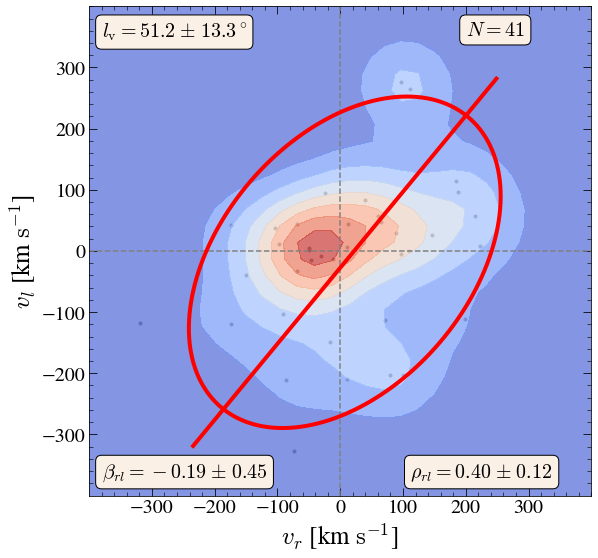

Using smoothing 2


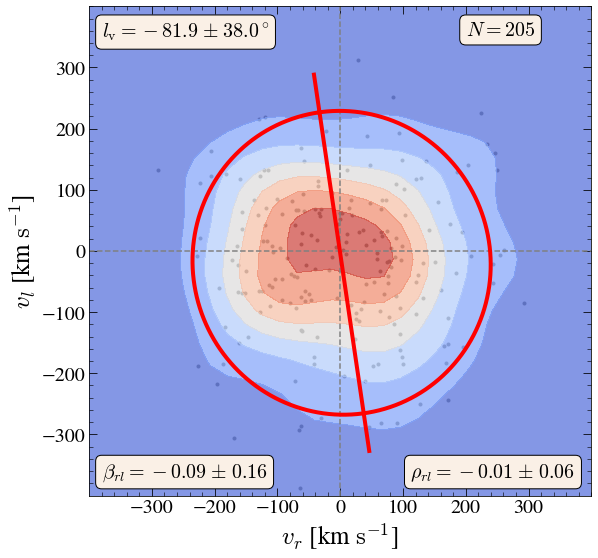

Using smoothing 1


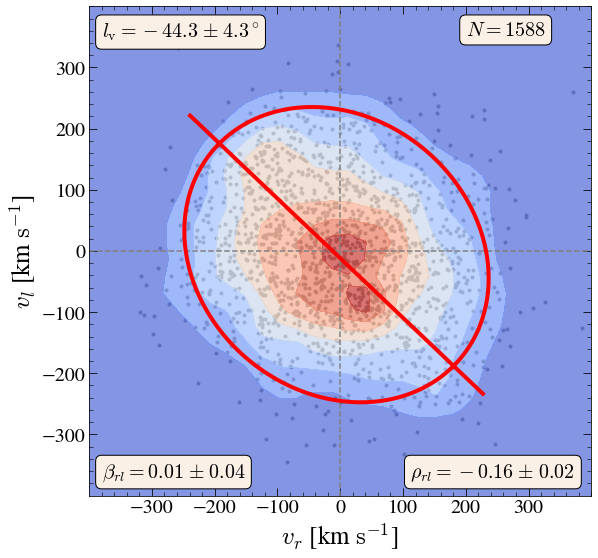

In [284]:
left_pop = data_extra[(data_extra['FeH']>lowlim)&(data_extra['FeH']<plim)]
centre_pop = data_extra[(data_extra['FeH']>plim)&(data_extra['FeH']<rlim)]
right_pop = data_extra[(data_extra['FeH']>rlim)&(data_extra['FeH']<highlim)]

for pop in [left_pop,centre_pop,right_pop]:
    velocity_plot.velocity_plot(pop.vr.values,pop.vl.values)

#### Both

This can't be used the same way as in the latitude plots because currently the code is run mutually exclusive way for data or sim. As a consequence, here we will load everything, including the main plot
* Run all the code above for the variations you want, in order to save the arrays
* The code below will load the main plot and the shadows, and create the plot

Note: currently I can only plot at the median if pop_plot_range.npy is saved at median values, as it requires having the whole array

##### Load

In [146]:
pos_units_dict["b"] = "deg"

In [814]:
def get_var_tuple_str(variable,var_tuple):
    if len(var_tuple) == 1:
        return f"{variable}{MF.return_int_or_dec(var_tuple[0],2)}"
    elif len(var_tuple) > 2:
        return f"{variable}" + ",".join([str(MF.return_int_or_dec(v,2)) for v in var_tuple])
    else:
        return f"{MF.return_int_or_dec(var_tuple[0],2)}{variable}{MF.return_int_or_dec(var_tuple[1],2)}"

def get_variation_str(var,all_value_tuples):
    var_str = ""

    for val_tuple in all_value_tuples:
        var_str += get_var_tuple_str(var,val_tuple) + "_"
    
    return var_str.removesuffix("_") + "/"

def get_save_path_POPPLOT_both(save_path,extra_var,depth_var,height_var,sim_bool=True,data_bool=True,binning_str_sim=None,binning_str_data=None,pop_str_data=None,\
                               pop_str_sim=None,extra_min=None,extra_max=None,depth_min=None,depth_max=None,height_min=None,height_max=None,all_variations_dict=None):
    
    for var,m,M in zip([extra_var,depth_var,height_var],[extra_min,depth_min,height_min],[extra_max,depth_max,height_max]):
        save_path += get_variation_str(var,all_variations_dict[var]) if var in all_variations_dict else get_var_tuple_str(var,[m,M])+"/"
        MF.create_dir(save_path)
    
    if data_bool:
        save_path += f"data_{binning_str_data}/"
        MF.create_dir(save_path)

        save_path += "data_"+get_variation_str("n",all_variations_dict["n_data"]) if "n_data" in all_variations_dict else f"data_{pop_str_data}/"
        MF.create_dir(save_path)
    
    if sim_bool:
        save_path += f"sim_{binning_str_sim}/"
        MF.create_dir(save_path)

        save_path += "sim_"+get_variation_str("n",all_variations_dict["n_sim"]) if "n_sim" in all_variations_dict else f"sim_{pop_str_sim}/"
        MF.create_dir(save_path)

    return save_path

In [208]:
def load_values_and_plot_ranges(path,full_map_string_list):
    
    map_dict = {}
    for m in full_map_string_list:
        map_dict[m] = np.load(f"{path}{m}.npy")
    
    min_range = np.load(path + f"pop_min_range.npy")
    max_range = np.load(path + f"pop_max_range.npy")
    plot_range = np.load(path + f"pop_plot_range.npy")
    
    return map_dict, min_range, max_range, plot_range

In [214]:
depth_variable_lims = {
    "l": [-2,2],
    "y": [coordinates.ang_to_rect(ang=-2,x=coordinates.get_solar_radius()), coordinates.ang_to_rect(ang=2,x=coordinates.get_solar_radius())]
}

overall_height_variable_lims = {
    "b": [1.5,9],
    "z": [coordinates.ang_to_rect(ang=1.5,x=coordinates.get_solar_radius()), coordinates.ang_to_rect(ang=9,x=coordinates.get_solar_radius())]
}

extra_variable_lims = {
    "d": [6.1,10.1],
    "R": [0,3.5]
}

# CHOOSE
# extra_variable = "d"
extra_variable = "R"
depth_var = "y"
height_var = "z"

if True: # print
    depth_min,depth_max = depth_variable_lims[depth_var]
    overall_height_min,overall_height_max = overall_height_variable_lims[height_var]
    extra_min,extra_max = extra_variable_lims[extra_variable]
    
    print(depth_var,depth_min,depth_max)
    print(height_var,overall_height_min,overall_height_max)
    print(extra_variable,extra_min,extra_max)

y -0.2828582328831566 0.2828582328831566
z 0.2121059647104141 1.2829139666287437
R 0 3.5


In [210]:
# see https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3

# colors = ["blue","blue","blue"]
colors = ["#1b9e77","#d95f02","#7570b3"]

line_alpha = 0.9
surface_alpha = 0.75
alpha_reduction_factor = 0.25

number_alpha = surface_alpha
number_alpha_reduction_factor = 0.5

In [211]:
binning_str_data = "equalN"
binning_str_sim = "equalN"

In [212]:
current_first = True
# current_first = False

# current_first_N = True
current_first_N = False

In [804]:
# data_bool = True
data_bool = False

sim_bool = True
# sim_bool = False

In [816]:
if True: # height_variations

    height_range_min,height_range_max = PH.get_equal_n_minmax_b_ranges(data_trim, n_points=3,\
                                                                 extra_variable=extra_variable,extra_min=extra_min,extra_max=extra_max,\
                                                                 depth_min=depth_variable_lims["l"][0],depth_max=depth_variable_lims["l"][1],\
                                                                 overall_bmin=overall_height_variable_lims["b"][0],overall_bmax=overall_height_variable_lims["b"][1])
    
    if height_var == "z":
        height_range_min = [coordinates.ang_to_rect(ang=bmin,x=coordinates.get_solar_radius()) for bmin in height_range_min]
        height_range_max = [coordinates.ang_to_rect(ang=bmax,x=coordinates.get_solar_radius()) for bmax in height_range_max]
    
    
    extra_variations = [[0,3.5],[0,2]]
    height_variations = [[MF.return_int_or_dec(m,2),MF.return_int_or_dec(M,2)] for (m,M) in zip(height_range_min,height_range_max)]
    
    n_extra_var,n_height_var = len(extra_variations),len(height_variations)
    
    if data_bool:
        n_data = 4
        n_variations_data = n_extra_var*[[n_data,n_data,n_data-1]]
        metal_str_variations = [[f"{x}_datapoints" for x in n_variations_data[i]] for i in range(len(n_variations_data))]
        
    if sim_bool:
        n_sim = 20
        n_variations_sim = n_extra_var*[[n_sim,n_sim,n_sim-5]]
        age_str_variations = [[f"{x}_datapoints" for x in n_variations_sim[i]] for i in range(len(n_variations_sim))]

    all_colors = n_extra_var*[colors]
    line_alphas = [n_height_var*[line_alpha], n_height_var*[line_alpha*alpha_reduction_factor]]
    surface_alphas = [n_height_var*[surface_alpha], n_height_var*[surface_alpha*alpha_reduction_factor]]
    number_alphas = [n_height_var*[number_alpha], n_height_var*[number_alpha*number_alpha_reduction_factor]]
    
    z_orders = [[len(extra_variations)*len(height_variations)-i + (-j if current_first else j) for j in range(len(height_variations))]\
                 for i in np.arange(0,len(extra_variations)*len(height_variations),len(height_variations))]
    z_orders_N = [[len(extra_variations)*len(height_variations)-i + (-j if current_first_N else j) for j in range(len(height_variations))]\
                   for i in np.arange(0,len(extra_variations)*len(height_variations),len(height_variations))]
    
    all_dicts = []
    
    for i,(em,eM) in enumerate(extra_variations):
        for j,(hm,hM) in enumerate(height_variations):
            
            spatial_path = get_save_path_POPPLOT_spatial_cuts(extra_variable=extra_variable,extra_min=em,extra_max=eM,\
                                                              depth_var=depth_var,depth_min=depth_min,depth_max=depth_max,\
                                                              height_var=height_var,height_min=hm,height_max=hM)
            
            current_dict = {
                "color":all_colors[i][j],
                "line_alpha":line_alphas[i][j],
                "surface_alpha":surface_alphas[i][j],
                "number_alpha":number_alphas[i][j],
                "zorder": z_orders[i][j],
                "zorderN": z_orders_N[i][j],
                "label_sim": get_legend_label([hm,hM],height_var) if i==0 else None,
                "label_data": None
            }
            
            if data_bool:
                load_path_data = get_save_path_POPPLOT_data(save_path_spatial=spatial_path, binning_str=binning_str_data,\
                                                        pop_str=metal_str_variations[i][j]) + "arrays/"
                current_dict["load_path_data"] = load_path_data
                
            if sim_bool:
                load_path_sim = get_save_path_POPPLOT_sim(save_path_spatial=spatial_path, binning_str=binning_str_sim,\
                                                      pop_str=age_str_variations[i][j]) + "arrays/"
                current_dict["load_path_sim"] = load_path_sim
            
            all_dicts.append(current_dict)
            
    all_variations_dict = {extra_variable:extra_variations,height_var:height_variations}
    if data_bool:
        all_variations_dict["n_data"] = n_variations_data
    if sim_bool:
        all_variations_dict["n_sim"] = n_variations_sim
    
    save_path = get_save_path_POPPLOT_both(save_path=get_base_path(),extra_var=extra_variable,depth_var=depth_var,height_var=height_var,\
                                            binning_str_sim=binning_str_sim,binning_str_data=binning_str_data,\
                                            depth_min=depth_min,depth_max=depth_max,\
                                            all_variations_dict=all_variations_dict,
                                            data_bool=data_bool,sim_bool=sim_bool)
    
print(save_path)

/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R3.5_0R2/-0.28y0.28/0.21z0.5_0.5z0.94_1.01z1.26/sim_equalN/sim_n20,20,15_n20,20,15/


In [817]:
if sim_bool:
    for dicts in all_dicts:
        print(dicts["load_path_sim"])

if data_bool:
    print("\n")
    for dicts in all_dicts:
        print(dicts["load_path_data"])

/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R3.5/-0.28y0.28/0.21z0.5/sim/equalN/20_datapoints/arrays/
/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R3.5/-0.28y0.28/0.5z0.94/sim/equalN/20_datapoints/arrays/
/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R3.5/-0.28y0.28/1.01z1.26/sim/equalN/15_datapoints/arrays/
/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/0.21z0.5/sim/equalN/20_datapoints/arrays/
/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/0.5z0.94/sim/equalN/20_datapoints/arrays/
/Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R2/-0.28y0.28/1.01z1.26/sim/equalN/15_datapoints/arrays/


##### Plot

In [818]:
capsize = 5

data_xerror_bool = True
# data_xerror_bool = False

data_lines_bool = True
# data_lines_bool = False

# data_surface_bool = True
data_surface_bool = False

In [819]:
number_bool = True
# number_bool = False

bar_log = True
# bar_log = False

# number_variations_bool = True
number_variations_bool = False

idx_variations_begin = 3

In [879]:
hard_coded_ylims_bool = True # currently needed to ensure the y axis is shared correctly
# hard_coded_ylims_bool = False

# symmetric_ylims_bool = True
symmetric_ylims_bool = False

hard_coded_ylims = {
#     "tilt_abs": [-45,45],
}

yshift_dict = {
    "tilt_abs": 2,
    "anisotropy": 0.02,
    "correlation": 0.01,
    "mean_vx": 1,
    "mean_vy": 1,
    "std_vx": 2,
    "std_vy": 2
}

In [821]:
# data_plot_range_str = "mean" # this can be computed even if pop_plot_range.npy was saved at the median
data_plot_range_str = "median" # but this would require the full array, so we can only get it from pop_plot_range.npy (assuming it was saved at the median)

In [887]:
legend_row = 1
# legend_row = len(map_list)

# legend_loc = "best"; ncols_leg=1
# legend_loc = "lower left"; ncols_leg=1
# legend_loc = (0.25,1.25 if not number_bool else 1.65); ncols_leg=len(colors) # use for double column (i.e. sim_bool+data_bool==2)
legend_loc = (-0.25,1.05 if not number_bool else 1.45); ncols_leg=len(colors) # use for single column (i.e. sim_bool+data_bool==1)

legend_bool = True
# legend_bool = False

# legend_data_bool = True
legend_data_bool = False

In [823]:
zero_line_color = "grey"
zero_line_alpha = 1

In [824]:
plt.rcParams["font.size"] = 22
ylabel_size = 24
legend_fontsize = 15.5

In [841]:
figsize_x = 15

# figsize_y = 14/3*0.9*len(map_list)
figsize_y = 1.41*figsize_x # aspect ratio of A4

figsize_x /= 2 if sim_bool+data_bool == 1 else 1

In [826]:
map_list = ["mean_vx","mean_vy","std_vx","std_vy","anisotropy","correlation","tilt_abs"]; map_list_string = "all"
# map_list = ["anisotropy","correlation","tilt_abs"]; map_list_string = "anicorrtilt"
# map_list = ["mean_vx","mean_vy","std_vx","std_vy"]; map_list_string = "velmeanstd"
# map_list = ["mean_vx","mean_vy","std_vx","std_vy","anisotropy"]; map_list_string = "meanstdani"
# map_list = ["std_vx","std_vy","anisotropy"]; map_list_string = "stdani"
# map_list = ["mean_vx","mean_vy"]; map_list_string = "velmeans"

In [827]:
filename_suffix = ""

In [884]:
save_bool = True
# save_bool = False

kinpop_all_noNvar
Saving in /Users/luismi/Desktop/MRes_UCLan/graphs/Observations/Apogee/individual_variable/age_metal/0R3.5_0R2/-0.28y0.28/0.21z0.5_0.5z0.94_1.01z1.26/sim_equalN/sim_n20,20,15_n20,20,15/
Saved .png
Saved .pdf


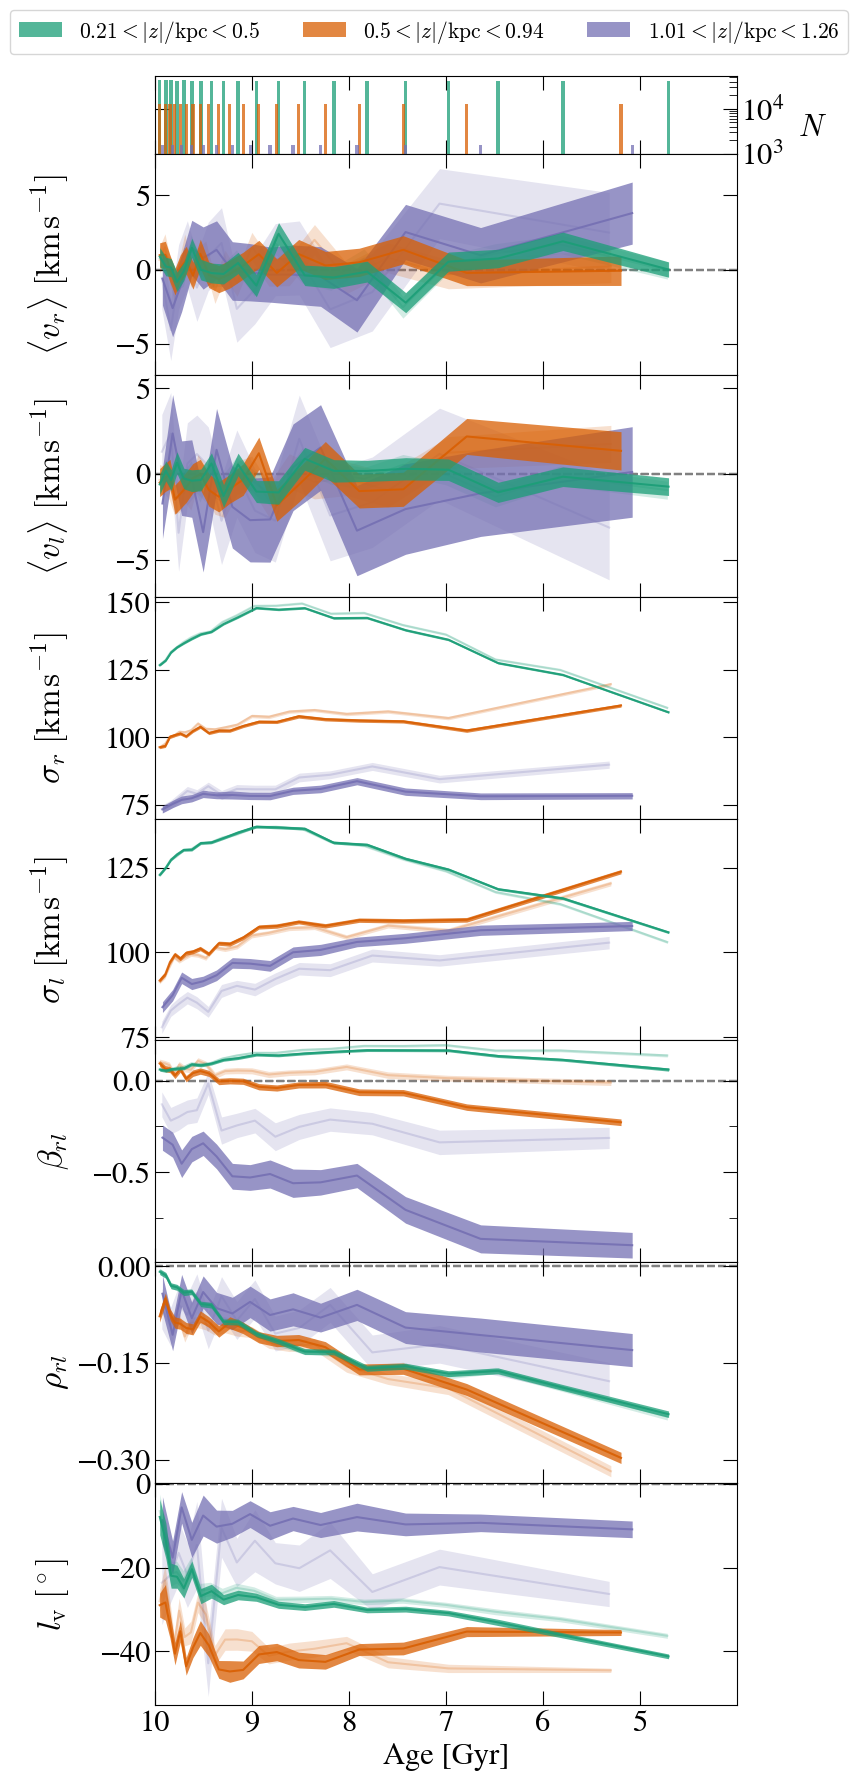

In [885]:
# plot

fig,axs = plt.subplots(figsize=(figsize_x,figsize_y),nrows=len(map_list)+1,ncols=sim_bool+data_bool, facecolor='w',\
                       gridspec_kw={'hspace':0,'wspace':0,'height_ratios':[0.35]+len(map_list)*[1]})

if True: # select axes
    if sim_bool and data_bool: 
        sim_axes,data_axes = axs[:,0], axs[:,1]
    elif sim_bool:
        sim_axes = axs
    elif data_bool:
        data_axes = axs
    else:
        raise ValueError("Both sim_bool and data_bool were set to False...")

if number_bool: # title and number bars
    if sim_bool and data_bool:
        sim_axes[0].set_title("Model")
        data_axes[0].set_title("Data")
    
    bar_n_min,bar_n_max = [10**30],[0]
    
    for i,d in enumerate(all_dicts):
        if not number_variations_bool and i >= idx_variations_begin:
            break
        
        if sim_bool:
            map_dict,min_range,max_range,plot_range = load_values_and_plot_ranges(d["load_path_sim"],full_map_string_list)
            plot_range = PH.get_range_means(min_range,max_range)
            POPPLOT_number_bar(sim_axes[0], plot_range, map_dict["number"],color=d["color"],alpha=d["number_alpha"],zorder=d["zorderN"])
            
            bar_n_min = min(bar_n_min, np.min(map_dict["number"]))
            bar_n_max = max(bar_n_max, np.max(map_dict["number"]))
        
        if data_bool:
            o_map_dict,o_min_range,o_max_range,o_plot_range = load_values_and_plot_ranges(d["load_path_data"],full_map_string_list)
            o_plot_range = o_plot_range if data_plot_range_str=="median" else PH.get_range_means(o_min_range,o_max_range)
            POPPLOT_number_bar(data_axes[0], o_plot_range, o_map_dict["number"],color=d["color"],alpha=d["number_alpha"],zorder=d["zorderN"])
    
            bar_n_min = min(bar_n_min, np.min(o_map_dict["number"]))
            bar_n_max = max(bar_n_max, np.max(o_map_dict["number"]))
    
    if sim_bool: POPPLOT_number_bar_axis_settings(sim_axes[0],min_n=bar_n_min,max_n=bar_n_max,bar_log=bar_log,min_shift_bool=False,labels_on=not data_bool)
    if data_bool: POPPLOT_number_bar_axis_settings(data_axes[0],min_n=bar_n_min,max_n=bar_n_max,bar_log=bar_log,min_shift_bool=False,labels_on=data_bool)
else:
    if sim_bool: fig.delaxes(sim_axes[0])
    if data_bool: fig.delaxes(data_axes[0])
    
    if sim_bool and data_bool:
        sim_axes[1].set_title("Model")
        data_axes[1].set_title("Data")

for row,map_string in enumerate(map_list): # plot
    error_string = map_string+"_error"
    
    ymin,ymax = [float("inf")],[float("-inf")]
    
    for i,d in enumerate(all_dicts):
        
        if sim_bool:
            map_dict,min_range,max_range,plot_range = load_values_and_plot_ranges(d["load_path_sim"],full_map_string_list)
            plot_range = PH.get_range_means(min_range,max_range)
            label = d["label_sim"] if row == legend_row-1 else None
            POPPLOT_values_sim(sim_axes[row+1],map_dict[map_string],map_dict[error_string],plot_range,\
                           color=d["color"],label=label,line_alpha=d["line_alpha"],surface_alpha=d["surface_alpha"],zorder=d["zorder"])
            
            ymin = min(ymin, np.nanmin(map_dict[map_string]-map_dict[error_string]))
            ymax = max(ymax, np.nanmax(map_dict[map_string]+map_dict[error_string]))
            
            POPPLOT_yaxis_settings(sim_axes[row+1],map_string,error_string,set_ylims=False)
            
            sim_axes[row+1].axhline(y=0,linestyle='--',color=zero_line_color,alpha=zero_line_alpha,zorder=0)
            
        if data_bool:
            o_map_dict,o_min_range,o_max_range,o_plot_range = load_values_and_plot_ranges(d["load_path_data"],full_map_string_list)
            o_plot_range = o_plot_range if data_plot_range_str=="median" else PH.get_range_means(o_min_range,o_max_range)
            o_label = d["label_data"] if row == legend_row-1 else None
            POPPLOT_values_data(data_axes[row+1],o_map_dict[map_string],o_map_dict[error_string],o_plot_range,o_min_range,o_max_range,\
                           color=d["color"],label=o_label,line_alpha=d["line_alpha"],zorder=d["zorder"])
        
            ymin = min(ymin, np.nanmin(o_map_dict[map_string]-o_map_dict[error_string]))
            ymax = max(ymax, np.nanmax(o_map_dict[map_string]+o_map_dict[error_string]))
    
            POPPLOT_yaxis_settings(data_axes[row+1],map_string,error_string,labels_on=False,set_ylims=False)

            data_axes[row+1].axhline(y=0,linestyle='--',color=zero_line_color,alpha=zero_line_alpha,zorder=0)
    
    if map_string in yshift_dict:
        ymin -= yshift_dict[map_string]
        ymax += yshift_dict[map_string]
    
    if hard_coded_ylims_bool and map_string in hard_coded_ylims:
        ymin,ymax = hard_coded_ylims[map_string]
    
    if sim_bool: sim_axes[row+1].set_ylim(ymin,ymax)
    if data_bool: data_axes[row+1].set_ylim(ymin,ymax)

if legend_bool: # legend
    if sim_bool: 
        sim_axes[legend_row].legend(loc=legend_loc,fontsize=legend_fontsize,ncols=ncols_leg)#,loc="lower left")
    if data_bool and legend_data_bool: 
        data_axes[legend_row].legend(loc=legend_loc,fontsize=legend_fontsize,ncols=ncols_leg)
    
if True: # x-axis
    
    if sim_bool: 
        _,min_range,max_range,_ = load_values_and_plot_ranges(all_dicts[0]["load_path_sim"],full_map_string_list)
    if data_bool:
        _,o_min_range,o_max_range,_ = load_values_and_plot_ranges(all_dicts[0]["load_path_data"],full_map_string_list)
    
    for row in range(len(map_list)+1): # include number bars
        
        x_labels_on = row == len(map_list)
        
        if sim_bool:
            age_ticks = np.arange(min(min_range)+1,max(max_range)+1,1)
            POPPLOT_xaxis_settings(sim_axes[row],xmin=min(min_range),xmax=max(max_range),xlabel=r"Age [Gyr]",\
                                   xticks=age_ticks,labels_on=x_labels_on)
            sim_axes[row].invert_xaxis()
        
        if data_bool:
            metal_ticks = np.arange(-0.9,0.6+0.3,0.3)
            POPPLOT_xaxis_settings(data_axes[row],xmin=min(o_min_range),xmax=max(o_max_range),xlabel="[Fe/H]",xticks=metal_ticks,labels_on=x_labels_on)  
    
    fig.align_labels()
    
if True: # save
    
    filename = "kinpop_" + map_list_string
    
    filename += "_noN" if not number_bool else ""
    
    filename += "_noNvar" if number_bool and not number_variations_bool else ""
    
    filename += "_noLeg" if not legend_bool else ""
    
    if not data_lines_bool:
        filename += "_noDataLines"
    
    filename += filename_suffix
    
    print(filename)
    
    if save_bool:
        print("Saving in",save_path)
        for formatting in ['.png','.pdf']:
            plt.savefig(save_path+filename+formatting, bbox_inches='tight', dpi=300)
            print("Saved",formatting)
    plt.show()

##### Same ax

Victor didn't like this as the two x-axis are confusing (and they represent different things so a 1-to-1 comparison within the plot isn't appropriate

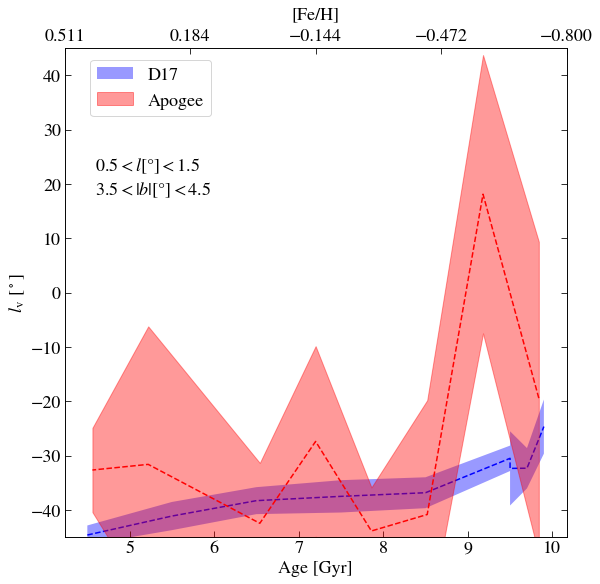

In [538]:
fig, ax = plt.subplots()

ax1 = ax.twiny()
ax1.set_xlabel('[Fe/H]',labelpad=10)
ax1.plot(metal_midranges, o_vertex_values, linestyle='--',color='red')
ax1.fill_between(metal_midranges, o_vertex_values-o_vertex_errors, o_vertex_values+o_vertex_errors,alpha=0.4, color='red',label='Apogee') #edgecolor='#CC4F1B', facecolor='#FF9848'
ax1.set_xticks(np.linspace(metal_poor_lim,metal_rich_lim,5))
ax1.set_xlim(metal_rich_lim,metal_poor_lim)

ax.set_xlabel('Age [Gyr]')
ax.set_ylabel(r'$l_{\mathrm{v}} \:\: [^\circ]$')
#ax.tick_params(labelsize=15,length=4,width=1)
ax.set_ylim(-45,45)

invert_axis_bool = False #invert x-axis (from old to young)
if invert_axis_bool:
    ax.set_xlim(max(age_mid_ranges)+half_range/2, min(age_mid_ranges)-half_range/2)
else:
    ax.set_xticks(np.arange(min(age_mid_ranges)-0.5, max(age_mid_ranges)+0.5, 1.0))

vertex_values = np.array(vertex_values)
#ax.errorbar(xb, yb,
#            yerr=vertex_err,
#            fmt='-o')
ax.plot(age_mid_ranges, vertex_values, linestyle='--',color='blue')
ax.fill_between(age_mid_ranges, vertex_values-vertex_errors, vertex_values+vertex_errors,alpha=0.4, facecolor='blue',label='D17') #edgecolor='#CC4F1B', facecolor='#FF9848'

fig.legend(loc=(0.15,0.8))

l_text = fr"${lmin}<l$[{degree_symbol}]$<{lmax}$"
b_text = fr"${bmin}<|b|$[{degree_symbol}]$<{bmax}$"
x,y= 0.06,0.75
ax.text(x=x,y=y,s=l_text,transform=ax.transAxes)
ax.text(x=x,y=y-0.05,s=b_text,transform=ax.transAxes)

#file_name = 'rotangle' + str(rot_angle)+'_708_vertex_age_'+str(age_step_old)+'oldResolution_'+str(age_limit_oldyoung)+'ageLimit_window2x2_invertaxis'+str(invert_axis_bool)+'.png'

plt.savefig(save_path_pop+'age_metal.pdf',bbox_inches='tight')
plt.show()

#### Sim old subdivision

In [ ]:
if not data_bool:
    
    fig,axs = plt.subplots(figsize=(13,10),nrows=2,ncols=2, gridspec_kw={'wspace':0.15,'hspace':0,'width_ratios':[1,0.17],'height_ratios':[0.15,1]})

    barax = axs[0,0]
    barax1 = axs[0,1]
    ax = axs[1,0]
    ax1 = axs[1,1]

    if True: # left right array division 
        age_plot_left = pop_plot_range[:limit_index]
        var_left = map_dict[var][:limit_index]
        err_left = map_dict[err][:limit_index]

        age_plot_right = pop_plot_range[limit_index:]
        var_right = map_dict[var][limit_index:]
        err_right = map_dict[err][limit_index:]

    if True: # bar plots

        number_left = map_dict['number'][:limit_index]
        number_right = map_dict['number'][limit_index:]

        barax.hist(df_extra[df_extra["age"]>4]["age"],bins=50,log=True,histtype="step",color="k")
        
        barax.bar(age_plot_left,number_left,log=True,width=0.2,color="grey",alpha=0.8)
        barax1.bar(age_plot_right,number_right,log=True,width=0.01)

    #     barax.plot(age_plot_left,number_left)
    #     barax1.plot(age_plot_right,number_right)

        for bar in [barax,barax1]:
            bar.minorticks_off()
            bar.set_xticklabels([])
            
            min_barticks = 3
            max_bartick = 5
            bar.set_yticks([10**i for i in np.arange(min_barticks,max_bartick+1,1)])

        if old_subplots:
            barax.tick_params(labelleft=False)
            barax1.tick_params(labelleft=False,labelright=True)
        else:
            barax.tick_params(labelleft=False,labelright=True)

    if True: # plot
        ax.plot(age_plot_left,var_left,color=color)
        ax.fill_between(age_plot_left,var_left-err_left,var_left+err_left,label=symbol_dict[var],color=color,alpha=0.5,linewidth=0)
        ax1.plot(age_plot_right,var_right,color=color)
        ax1.fill_between(age_plot_right,var_right-err_right,var_right+err_right,label=symbol_dict[var],color=color,alpha=0.5,linewidth=0)

    if var1_bool: # var1, legend 
        var1_left = map_dict[var1][:limit_index]
        err1_left = map_dict[err1][:limit_index]

        var1_right = map_dict[var1][limit_index:]
        err1_right = map_dict[err1][limit_index:]

        ax.plot(age_plot_left,var1_left,color=color1)
        ax.fill_between(age_plot_left,var1_left-err1_left,var1_left+err1_left,label=r"$%s$"%only_symbol_dict[var1],color=color1,alpha=0.5,linewidth=0)
        ax1.plot(age_plot_right,var1_right,color=color1)
        ax1.fill_between(age_plot_right,var1_right-err1_right,var1_right+err1_right,label=r"$%s$"%only_symbol_dict[var1],color=color1,alpha=0.5,linewidth=0)

        ax.legend(loc='lower right')

    if True: # axhlines, ylim, ticks

        ax.axhline(y=0,linestyle='--',color='grey')
        ax1.axhline(y=0,linestyle='--',color='grey')

        ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
        barax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
        barax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.025))

        for axis in [ax,ax1]:

            if var == 'anisotropy' or var == 'correlation':
                ybottom, ytop = -0.5,0.2
                axis.set_ylim(ybottom,ytop); print(f"Lims {ybottom},{ytop}")
                axis.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
                axis.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

            elif var == 'tilt_abs':
                ybottom, ytop = -45, -10
                axis.set_ylim(ybottom,ytop); print(f"Lims {ybottom},{ytop}")
                axis.yaxis.set_major_locator(ticker.MultipleLocator(10))
                axis.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
            else:
                maxabs = max(np.abs([min(map_dict[var]-map_dict[err]),max(map_dict[var]+map_dict[err])]))

                if var1_bool:
                    maxabs1 = max(np.abs([min(map_dict[var1]-map_dict[err1]),max(map_dict[var1]+map_dict[err1])]))

                    maxabs = max(maxabs,maxabs1)

                axis.set_ylim(-maxabs-0.05,maxabs+0.05)

        ax1.set_yticklabels([])
        
    if True: # labels and text
        ax.set_xlabel('Age [Gyr]')
        if not var1_bool:
            ax.set_ylabel(symbol_dict[var]+units_dict[var])

#         if var == 'vertex_abs':
#             ax.text(x=0.05,y=0.6,s=fr"$|l|<{lmax}^\circ$"+'\n'+fr"${bmin}^\circ<|b|<{bmax}^\circ$"+'\n'+fr"${dmin}<d/\mathrm{{kpc}}<{dmax}$",
#                     transform=ax.transAxes,fontsize=15)#,bbox={'facecolor':'w'})

        if not old_subplots:
            barax.set_ylabel(r"$N$",rotation=0,labelpad=20)
            barax.yaxis.set_label_position("right")

    if True: # xlim, broken axes params
        
        if old_subplots:
            left_age_transition = max_age#age_limit_oldyoung
            ax.set_xlim(min_age,left_age_transition)
            barax.set_xlim(min_age,left_age_transition)
            
            ax1.set_xlim(age_limit_old,max_age)
            barax1.set_xlim(age_limit_old,max_age)

        # hide the spines between ax and ax1
    #     ax.spines['right'].set_visible(False)
    #     ax1.spines['left'].set_visible(False)
    #     ax.tick_params(which='both',right=False)
    #     ax1.tick_params(which='both',left=False)

    #     d = .01
    #     kwargs = dict(transform=ax.transAxes, color='r', clip_on=False)
    #     ax.plot((1-d,1+d), (-d,+d), **kwargs)
    #     ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

    #     # uncomment the lines below if wanting to leave a space between the axes
    #     kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
    #     d_x = .057
    #     d_y = 0.011
    #     ax1.plot((-d_x,+d_x), (1-d_y,1+d_y), **kwargs)
    #     ax1.plot((-d_x,+d_x), (-d_y,+d_y), **kwargs)
    
        else:
            ax.set_xlim(min(df["age"]),max(df["age"]))
            barax.set_xlim(min(df["age"]),max(df["age"]))

    if not old_subplots: # delete right column axes 
        fig.delaxes(ax1)
        fig.delaxes(barax1)

    if True: # save

        filename = var
        if var1_bool: filename += var1

        if filename == 'anisotropycorrelation': filename = 'anicorr'
        elif filename == 'mean_vxmean_vy': filename = 'vel'

        filename += f'_sim'
        print(filename)

        if save_bool:
            for f in ['.png','.pdf']:
                plt.savefig(save_path+filename+f,bbox_inches='tight',dpi=200)
            print(save_path+filename)
    plt.show()

## metal poor apogee

In [289]:
lmin,lmax = -2,2
bmin, bmax = 0,10
dmin,dmax = 6,10

o_df_extra = data[(data.l>lmin)&(data.l<lmax)&(data.b>bmin)&(data.b<bmax)&(data.d>dmin)&(data.d<dmax)]

In [62]:
# metal_lowlim = -1
metal_lowlim = o_df_extra["FeH"].min()

metal_highlim = -1
# metal_highlim = o_df_extra["FeH"].max()

print(f"Chose limits:({metal_lowlim},{metal_highlim})")
    
metal_df = o_df_extra[(o_df_extra['FeH'] > metal_lowlim)&(o_df_extra['FeH'] < metal_highlim)]#&(o_df_extra['b']<7)]

Chose limits:(-1.9031615257263184,-1)


### E-L

**See ubuntu anaconda for an updated version, and using a potential that includes the effect of the bar**

In [288]:
import astropy.units as u
from gala.potential import MilkyWayPotential
# https://gala-astro.readthedocs.io/en/v1.3/potential/define-milky-way-model.html

potential = MilkyWayPotential()
potential

<CompositePotential disk,bulge,nucleus,halo>

MilkyWayPotential([units, disk, halo, ...])

https://gala-astro.readthedocs.io/en/v1.5/api/gala.potential.potential.MilkyWayPotential.html#gala.potential.potential.MilkyWayPotential

A simple mass-model for the Milky Way consisting of a spherical nucleus and bulge, a Miyamoto-Nagai disk, and a spherical NFW dark matter halo. (from Bovy 2015)

To evaluate the potential energy at the 3D position (x, y, z) = (1, -1, 0) AU:

potential.energy([1., -1., 0.] * u.au)

<Quantity [-27.91440236] AU2 / yr2>

In [17]:
save_path = general_path+f"708main_simulation/graphs/Observations/Apogee/more_vel_plots/{lmin}l{lmax}/all_poor_rich/E-J/"
print(save_path)

C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/more_vel_plots/-2l2/all_poor_rich/E-J/


In [42]:
def produce_EJ_plot(metal_df, potential, save_bool=False,scatSize=None, cmap='viridis', ang_mom_comp = 2,xlim=None,ylim=None, kpcMyr=False):
    # Kinetic energy -----------------------------------------
    E_k = 1/2*(metal_df["vx"]**2 + metal_df["vy"]**2 + metal_df["vz"]**2) # km^2 / s^2
    if kpcMyr:
        E_k *= ( (365*3600*24*10**6) / (3.086*10**16) ) **2 # kpc^2 / Myr^2
    else:
        E_k /= 10**5 # 10^5 km^2/s^2
    
    # Potential energy -----------------------------------------
    positions = np.vstack((metal_df['x'],metal_df['y'],metal_df['z'])) # kpc, shape (3,N)
    pot_energy = potential.energy(positions) # kpc^2 / Myr^2
    
    if not kpcMyr:
        pot_energy *= ( (3.086*10**16) / (365*3600*24*10**6) )**2 / 10**5 # 10^5 km^2/s^2
    
    # Total energy -----------------------------------------
    E_total = E_k + np.array(pot_energy)
    
    # Angular momentum ----------------------------------------
    position_vectors = positions.T
    velocity_vectors = np.vstack([[metal_df['vx'],metal_df['vy'],metal_df['vz']]]).T
    J_vectors = np.cross(position_vectors,velocity_vectors)

    Jcomp = J_vectors[:,ang_mom_comp] # kpc * km/s
    if kpcMyr:
        Jcomp *= (365*3600*24*10**6) / (3.086*10**16) # kpc^2 / Myr
    else:
        Jcomp /= 10**3 # 10^3 kpc km/s
    
    Jlabel = {0:r"$J_x$", 1:r"$J_y$", 2:r"$J_\phi$"}
    xunits = r" $[\mathrm{kpc}^2/\mathrm{Myr}]$" if kpcMyr else r" $[10^3~\mathrm{kpc}~\mathrm{km}/\mathrm{s}]$"
    yunits = r" $[\mathrm{kpc}^2/\mathrm{Myr}^2]$" if kpcMyr else r" $[10^5~\mathrm{km}^2/\mathrm{s}^2]$"
    
    # PLOT ---------------------------------------------
    fig,ax=plt.subplots()
    c = ax.scatter(Jcomp,E_total,c=metal_df['FeH'],cmap=cmap,s=scatSize)
    ax.set(xlabel=Jlabel[ang_mom_comp]+xunits,\
           ylabel=r"$\mathrm{Energy}$"+yunits)
    ax.set(xlim=xlim,ylim=ylim)
    cbar = plt.colorbar(c,cmap='coolwarm')
    cbar.set_label(label="[Fe/H]",labelpad=16 if metal_df['FeH'].min()>0 else 0)
    if True: #filename
        if metal_lowlim != o_df_extra['FeH'].min() and metal_highlim != o_df_extra['FeH'].max():
            filename = f"{metal_lowlim}metal{metal_highlim}"
        elif metal_lowlim == o_df_extra['FeH'].min() and metal_highlim == o_df_extra['FeH'].max():
            filename = 'all'
        elif metal_lowlim == o_df_extra['FeH'].min():
            filename = f"metal{metal_highlim}"
        elif metal_highlim == o_df_extra['FeH'].max():
            filename = f"{metal_lowlim}metal"
        print(filename)
    if save_bool:
        plt.savefig(save_path + f"EJ{ang_mom_comp}_%s.png"%filename,dpi=300,bbox_inches='tight')
    plt.show()

metal-1


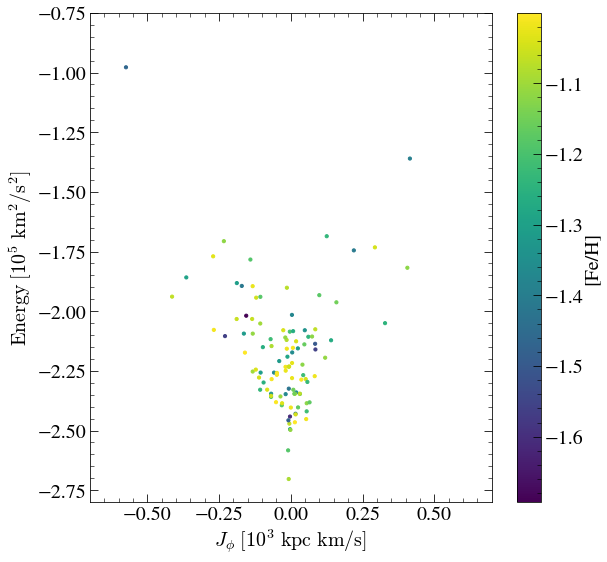

In [64]:
produce_EJ_plot(metal_df,potential,save_bool=True,scatSize=10,ang_mom_comp=2,xlim=[-0.7,0.7],ylim=[-2.8,-0.75])

metal_vals_left = []
metal_vals_right = 
metal_vals_plot = metal_vals-0.05

metal_comps = [o_df_extra[(o_df_extra['FeH'] > val-0.1)&(o_df_extra['FeH'] < val)] for val in metal_vals]

vertex_vals = [CV.calculate_tilt(comp.vr.values,comp.vl.values,absolute=True) for comp in metal_comps]
error_vals = [CV.get_std_bootstrap(comp.vr.values,comp.vl.values,function=CV.calculate_tilt,tilt=True,absolute=True) for comp in metal_comps]

for i in metal_comps:
    print(len(i),i['FeH'].min(),i['FeH'].max())
    
#fig,ax=plt.subplots()

#ax.fill_between(metal_vals)

### Positions

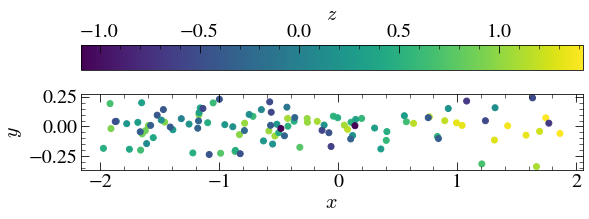

In [126]:
fig,ax=plt.subplots()

h=ax.scatter(metal_df['x'],metal_df['y'],c=metal_df['z'])
ax.set_aspect('equal')
ax.set_xlabel(r"$x$");ax.set_ylabel(r"$y$")
cbar=plt.colorbar(h,location="top",orientation="horizontal")#,shrink=0.5)
cbar.ax.set_xlabel(r"$z$")
plt.savefig(save_path+f"xy_FeHless{metal_highlim}.png",dpi=250,bbox_inches='tight')
plt.show()

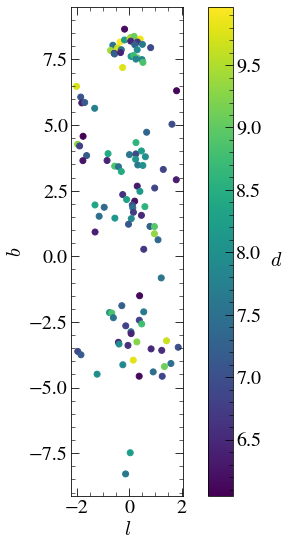

In [131]:
fig,ax=plt.subplots()

h=ax.scatter(metal_df['l'],metal_df['b'],c=metal_df['d'])
ax.set_aspect('equal')
ax.set_xlabel(r"$l$");ax.set_ylabel(r"$b$" if zabs else r"$b$")
cbar=plt.colorbar(h)#,location="top",orientation="horizontal")#,shrink=0.5)
cbar.ax.set_ylabel(r"$d$",rotation=0,labelpad=15)
plt.savefig(save_path+f"lb_FeHless{metal_highlim}.png",dpi=250,bbox_inches='tight')
plt.show()

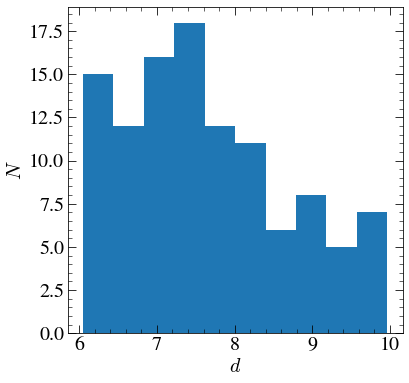

In [132]:
fig,ax=plt.subplots(figsize=(6,6))

ax.hist(metal_df['d'])
ax.set_xlabel(r"$d$");ax.set_ylabel(r"$N$")
plt.show()

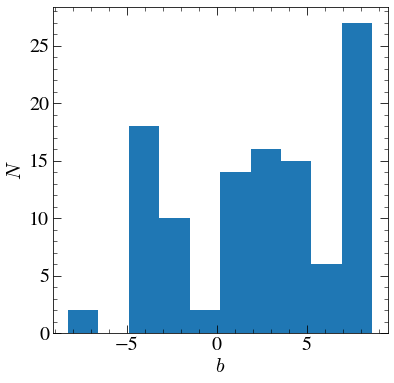

In [134]:
fig,ax=plt.subplots(figsize=(6,6))

ax.hist(metal_df['b'])
ax.set_xlabel(r"$b$");ax.set_ylabel(r"$N$")
plt.show()

# Distance

## Split

Check how wide in longitude we can go before the metal-poor develop a tilt

In [201]:
lmax = 2
bmin = 0.5
bmax = 10

data_bulge = data[(np.abs(data['l'])<lmax)&(data['d']>6)&(data['d']<10)&(data['b']>bmin)&(data['b']<bmax)]

data_bulge_poor = data_bulge[data_bulge['FeH']<-0.5]

In [204]:
vx = data_bulge_poor.vr.values
vy = data_bulge_poor.vl.values

# val = CV.calculate_tilt(vx,vy,absolute=True)
# err = CV.get_std_bootstrap(vx,vy,CV.calculate_tilt,tilt=True,absolute=True)
val = CV.calculate_correlation(vx,vy)
err = CV.get_std_bootstrap(vx,vy,CV.calculate_correlation)

print(r"%.2f +- %.2f"%(val,err))

-0.02 +- 0.04


Split in distance distribution for the simulation, check at what latitude it appears

In the literature they say the MW's one appears with $l=0$ and $b=-5$, but most of my data lives below $b=5$

4 to 7 Gyr: inner split visible at $b>2.5$, hard to see at $b>4$, where outer X-shape dominates

9.8 to 10 Gyr: visible at $b>3.5$, far end dissappears after $b>6$

4 to 10 Gyr: visible at $b>3$, far end dissapears after $b>6$

In [253]:
lmax = 2
bmin = 6
bmax = 10

# agemin = 4
# agemax = 10
agemin = 4
agemax = 7
# agemin = 9.8
# agemax = 10

df_bulge = df0[(np.abs(df0['l'])<lmax)&(df0['d']>6)&(df0['d']<10)&(df0['b']>bmin)&(df0['b']<bmax)&(df0['age']>agemin)&(df0['age']<agemax)]

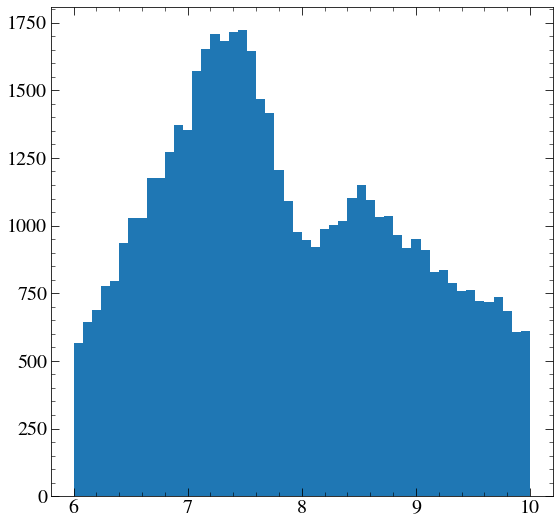

In [254]:
fig,ax=plt.subplots()

ax.hist(df_bulge['d'],bins=50)
plt.show()

In [279]:
lmax = 2
bmin = 2.5
bmax = 10

metalmin = data['FeH'].min()
metalmax = data['FeH'].max()

data_bulge = data[(np.abs(data['l'])<lmax)&(data['d']>6)&(data['d']<10)&(data['b']>bmin)&(data['b']<bmax)&(data['FeH']>metalmin)&(data['FeH']<metalmax)]

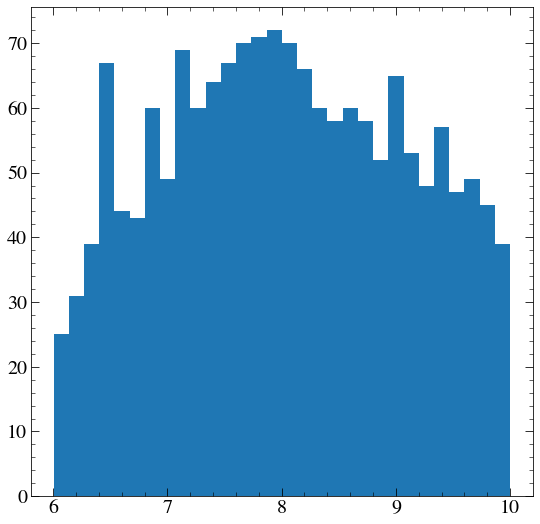

In [280]:
fig,ax=plt.subplots()

ax.hist(data_bulge['d'],bins=30)
plt.show()

## Plot

In [182]:
lmin = -1.5
lmax = 1.5
bmin = 2.5
bmax = 4.5

dmin = 6
dmax = 10

df_extra = df0[(df0["l"]>lmin)&(df0["l"]<lmax)&(df0["d"]>dmin)&(df0["d"]<dmax)&(df0["b"]>bmin)&(df0["b"]<bmax+b_step)]
df_ages = [df_extra[(df_extra["age"]>agelim[0])&(df_extra["age"]<agelim[1])] for agelim in age_limits]

poor_condition = (o_df_extra["FeH"] < metal_poor_highlim)&(o_df_extra["FeH"] > metal_poor_lowlim)
rich_condition = o_df_extra["FeH"] > metal_rich_lowlim if metal_rich_highlim is None else (o_df_extra["FeH"] < metal_rich_highlim)&(o_df_extra["FeH"] > metal_rich_lowlim)

df_metals = [o_df_extra[rich_condition], o_df_extra[poor_condition]]

In [183]:
d_step = 1
d_range = np.arange(dmin,dmax,d_step)
d_range_plot = d_range+d_step/2
o_d_range_plot = d_range_plot
print("d_range is",d_range)
print("Plotting at:",d_range_plot)

d_range is [6 7 8 9]
Plotting at: [6.5 7.5 8.5 9.5]


In [184]:
save_path = general_path + "708main_simulation/graphs/Oscar/Apogee/"
create_dir(save_path)

# save_path += "scaling_"+str(sim_scaling)+'/'
# MF.create_dir(save_path)

save_path += "individual_variable/"
MF.create_dir(save_path)

save_path += "distance/"
MF.create_dir(save_path)
    
save_path += f"{lmin}l{lmax}/"
create_dir(save_path)

save_path += f"{bmin}b{bmax}/"
create_dir(save_path)
    
save_path += f"{young_min}-{young_max}_{old_min}-{old_max}/"
create_dir(save_path)

#save_path += 'halo_metal/'
#create_dir(save_path)

if not galactocentric:
    save_path += 'LSR/'
    create_dir(save_path)

poor_condition = (o_df_extra["FeH"] < metal_poor_highlim)&(o_df_extra["FeH"] > metal_poor_lowlim)
label_poor = fr'${metal_poor_lowlim}<$[Fe/H]$<{metal_poor_highlim}$'

if metal_rich_highlim is None:
    rich_condition = o_df_extra["FeH"] > metal_rich_lowlim
    label_rich = fr'${metal_rich_lowlim}<$[Fe/H]'
    save_path += f"{metal_rich_lowlim}to{metal_rich_highlim}_{metal_poor_lowlim}to{metal_poor_highlim}/"
else:
    rich_condition = (o_df_extra["FeH"] < metal_rich_highlim)&(o_df_extra["FeH"] > metal_rich_lowlim)
    label_rich = fr'${metal_rich_lowlim}<$[Fe/H]$<{metal_rich_highlim}$'
    save_path += f"{metal_rich_lowlim}to{metal_rich_highlim}_{metal_poor_lowlim}to{metal_poor_highlim}/"

df_metals = [o_df_extra[rich_condition], o_df_extra[poor_condition]]
label_rich += f" ({len(df_metals[0])})"
label_poor += f" ({len(df_metals[1])})"

create_dir(save_path)

if halo_bool:
    df_metals.append(o_df_extra[o_df_extra["FeH"] < metal_halo_lim])    
    label_halo = fr'(%i) [Fe/H]$<{metal_halo_lim}$'%len(df_metals[2])
    print("Working with the halo population")

print("SAVING IN\n"+save_path)

Created successfully
Created successfully
Created successfully
Created successfully
SAVING IN
C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Oscar/Apogee/scaling_1.7/-1.5l1.5/2.5b4.5/4-8.5_9.5-10/-0.3toNone_-1to-0.4/


fig, ax = plt.subplots()

alpha=0.7
bins = np.linspace(dmin,dmax,50)
if not halo_bool:
    ax.hist(o_df_extra['d'],bins=bins,label='(%i) All'%len(o_df_extra['d']),alpha=alpha,color='orange')
ax.hist(df_metals[1]['d'],bins=bins,label=label_poor,alpha=alpha,color='blue')
ax.hist(df_metals[0]['d'],bins=bins,label=label_rich,alpha=alpha,color='red')
if halo_bool:
    ax.hist(df_metals[2]['d'],bins=bins,label=label_halo,alpha=alpha*0.75,color='cyan')
ax.set_xlim(dmin,dmax)
ax.set_xticks(np.arange(dmin,dmax,1))
ax.set_xlabel(r'$d$ [kpc]')
ax.set_ylabel(r"$N$",rotation=0,labelpad=20)
ax.legend(loc='upper right')
ax.text(0.05,0.9,fr"${lmin} < l < {lmax}$",transform=ax.transAxes)
ax.text(0.07,0.85,fr"${bmin} < b < {bmax}$",transform=ax.transAxes)
plt.savefig(save_path+f"number_observations_{lmin}l{lmax}_{bmin}b{bmax}.png",bbox_inches='tight',dpi=150)
plt.show()

In [185]:
all_arrays = np.zeros(shape=(len(full_map_string_list),len(d_range),len(df_ages)))
o_all_arrays = np.zeros(shape=(len(full_map_string_list),len(d_range),len(df_metals)))

for d_index,distance in enumerate(d_range):
    for age_index,df in enumerate(df_ages):
        vr = df[(df['d']>distance)&(df['d']<distance+d_step)].vr.values
        vl = df[(df['d']>distance)&(df['d']<distance+d_step)].vl.values
        
        values = get_all_variable_values_and_errors(vr,vl,bootstrap_repeat=100,min_number=min_number_sim)
        
        for index, val in enumerate(values):
            all_arrays[index, d_index, age_index] = val
    
    for metal_index, o_df in enumerate(df_metals):
        vr = o_df[(o_df['d']>distance)&(o_df['d']<distance+d_step)].vr.values
        vl = o_df[(o_df['d']>distance)&(o_df['d']<distance+d_step)].vl.values
        
        values = get_all_variable_values_and_errors(vr,vl,bootstrap_repeat=100,min_number=10)
        
        for index, val in enumerate(values):
            o_all_arrays[index, d_index, metal_index] = val
    
print("Done")

Done


In [186]:
map_dict = create_map_array_dict(full_map_string_list, all_arrays)
o_map_dict = create_map_array_dict(full_map_string_list, o_all_arrays)

In [187]:
xsymbol = d

NameError: name 'd' is not defined

In [ ]:
map_string = "vertex_abs"

In [ ]:
map_array = map_dict[map_string]
error_array = map_dict[error_string]
map_symbol = symbol_dict[map_string]
map_title = title_dict[map_string]
yticks = get_variable_ticks(map_string, map_array)
displacement = max(yticks) - min(yticks)

color_y, color_o = color_dict['vertex_abs'][0], color_dict['vertex_abs'][1]

transparency = 0.5
alpha_area = 0.4

fig, ax = plt.subplots()

divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", size=1.2, pad=0, sharex=ax)
ax_histx.xaxis.set_tick_params(labelbottom=False)

alpha=0.7
ax_histx.hist(df_metals[1]['d'],bins=bins,alpha=1,color=color_o)
ax_histx.hist(df_metals[0]['d'],bins=bins,alpha=alpha,color=color_y)
if halo_bool:
    ax_histx.hist(df_metals[2]['d'],bins=bins,alpha=alpha,color='cyan')

bar_width=0.2
ax_histx.bar(d_range_plot-bar_width/2, map_dict["number"][:,0], width=bar_width,alpha=transparency,log=True,color=color_y)
ax_histx.bar(d_range_plot+bar_width/2, map_dict["number"][:,1], width=bar_width,alpha=transparency,log=True,color=color_o)
ax_histx.yaxis.set_tick_params(labelleft=False,labelright=True)
ax_histx.set_yticks([1,10,100,1000,10000,100000])
ax_histx.set_ylabel(r"$N$",labelpad=15,rotation=0)
ax_histx.yaxis.set_label_position("right")

ax.plot(d_range_plot, map_array[:,1] , color=color_o, linestyle='--', lw=1)
ax.plot(d_range_plot, map_array[:,0], color=color_y, linestyle='--', lw=1)


ax.fill_between(d_range_plot, map_array[:,1]-error_array[:,1], map_array[:,1]+error_array[:,1],alpha=alpha_area, facecolor=color_o, label=label_o)
ax.fill_between(d_range_plot, map_array[:,0]-error_array[:,0], map_array[:,0]+error_array[:,0],alpha=alpha_area, facecolor=color_y, label=label_y)

if not absolute:
    ax.fill_between(d_range_plot, map_array[:,1]-error_array[:,1]+displacement, map_array[:,1]+error_array[:,1]+displacement,alpha=alpha_area, facecolor=color_o)
    ax.fill_between(d_range_plot, map_array[:,1]-error_array[:,1]-displacement, map_array[:,1]+error_array[:,1]-displacement,alpha=alpha_area, facecolor=color_o)
    ax.fill_between(d_range_plot, map_array[:,0]-error_array[:,0]+displacement, map_array[:,0]+error_array[:,0]+displacement,alpha=alpha_area, facecolor=color_y)
    ax.fill_between(d_range_plot, map_array[:,0]-error_array[:,0]-displacement, map_array[:,0]+error_array[:,0]-displacement,alpha=alpha_area, facecolor=color_y)

#OBSERVATIONS-----------------------------------------------------------------------------------------------
o_map_array = o_map_dict[map_string]
o_error_array = o_map_dict[error_string]

ax.errorbar(o_d_range_plot, o_map_array[:,1] , yerr= o_error_array[:,1], color=color_o, label=label_poor,fmt='o',marker="$\u25A1$")
ax.errorbar(o_d_range_plot, o_map_array[:,0], yerr= o_error_array[:,0], color=color_y, alpha=0.8,label=label_rich,fmt='s',marker="$\u25EF$")
if halo_bool:
    ax.errorbar(o_d_range_plot, o_map_array[:,2] , yerr=o_error_array[:,2], color='cyan', label=label_halo,fmt='o',markersize=8,marker="$\u25B3$")

#------------------------------------------------------------------------------------------------------------
    
ax.legend(fontsize=15,loc="best")

ax.set_xlim(dmin,dmax)
ax.set_xticks(np.arange(dmin,dmax,1))
ax.set_yticks(yticks)
ax.set_ylim(min(yticks),max(yticks))

ax.set_xlabel(r"$%s$ [°]"%xsymbol)
ax.set_ylabel(map_symbol)

title_string = 'Vertex deviation (absolute value equation)' if absolute else 'Vertex deviation'
ax_histx.set_title(title_string,fontsize=18,pad=10)

#ax.set_aspect(0.082 if absolute else 0.04)

ax.text(x=-0.14,y=1.24,s='Sim scaling '+str(sim_scaling),size=13, transform=ax.transAxes)
l_string = r"$%i < l [%s] < {%i},$"%(lmin,degree_symbol,lmax)
d_string = r"${%i}<d [\mathrm{%s}]<{%i}$"%(dmin,'kpc',dmax)
text_y = -0.09
ax.text(x=0.79,y=text_y,s=l_string,size=13,transform=ax.transAxes)
ax.text(x=0.94,y=text_y,s=d_string,size=13,transform=ax.transAxes)
plt.savefig(save_path+map_string+'_distance.pdf',bbox_inches='tight')
print(save_path+map_string)
plt.show()

In [ ]:
age_min = 9.
age_max = 10.

dmin = 6
dmax = 10

In [ ]:
d_step = 0.5
distance_range = np.arange(dmin,dmax,d_step)

In [ ]:
lb_step = 1.5

lmin = -lb_step/2
lmax = lb_step/2
bmin = -lb_step/2
bmax = lb_step/2

min_star_number = 10

limit_vertex = -40

In [ ]:
longitude_range = np.arange(lmin, lmax, lb_step)
latitude_range = np.arange(bmin, bmax, lb_step)

print("Longitude range:",longitude_range)
print("Latitude range:",latitude_range)

In [ ]:
for i in latitude_range:
    print(i,i+lb_step)

In [ ]:
save_path = "708main_simulation/graphs/vertex_distance/"

In [ ]:
#No division in distance intervals
theta_across_d = []

df_dist_age = df0[(df0.age <= age_max)&(df0.age >= age_min)&(df0.d <= dmax)&(df0.d>=dmin)]

for longitude in longitude_range:
        df_long = df_dist_age[(df_dist_age.l >= longitude)&(df_dist_age.l < longitude + lb_step)]

        for latitude in latitude_range:
            df_lat = df_long[(df_long.b >= latitude)&(df_long.b < latitude + lb_step)]

            cov = np.cov(df_lat.vr.values, df_lat.pml.values)
            varr = cov[0,0]
            varl = cov[1,1]
            covrl = cov[0,1]

            if len(df_lat) > min_star_number:
                theta = np.degrees(np.arctan2(2.*covrl, np.abs(varr - varl))/2.)
            else:
                continue
            
            print(theta)
            theta_across_d.append(theta)
del df_dist_age, df_long, df_lat

In [ ]:
with open(save_path + "total_vertex_"+str(lmin)+"l"+str(lmax)+"_"+str(bmin)+"b"+str(bmax)+".txt", 'w') as f:
    f.write("The total vertex deviation across the line of sight (6 < d < 10)kpc is: "+str(theta_across_d[0])+'°'\
           "\n\nWorking with a "+str(lb_step)+"×"+str(lb_step)+"° window in: \n"+str(lmin)+" <= l < "+str(lmax)+
           "\n"+str(bmin)+" <= b < "+str(bmax))

In [ ]:
df_age = df0[(df0.age <= age_max)&(df0.age >= age_min)]

x_positions, y_positions, x_velocities, y_velocities, r_vel, t_vel = [], [], [], [], [], []
theta_values, number_points = [], []

i = 0

for distance in distance_range:
    df_dist = df_age[(df_age.d >= distance)&(df_age.d < distance + d_step)]

    for longitude in longitude_range:
        df_long = df_dist[(df_dist.l >= longitude)&(df_dist.l < longitude + lb_step)]

        for latitude in latitude_range:
            df_lat = df_long[(df_long.b >= latitude)&(df_long.b < latitude + lb_step)]

            cov = np.cov(df_lat.vr.values, df_lat.pml.values)
            varr = cov[0,0]
            varl = cov[1,1]
            covrl = cov[0,1]

            if len(df_lat) > min_star_number:
                theta = np.degrees(np.arctan2(2.*covrl, np.abs(varr - varl))/2.)
            else:
                continue
            
            print(theta)
            #if theta < limit_vertex:
            number_points.append(len(df_lat.x.values))
            theta_values.append(theta)
            x_positions.append(df_lat.x.values)
            y_positions.append(df_lat.y.values)
            x_velocities.append(df_lat.vx.values)
            y_velocities.append(df_lat.vy.values)
            r_vel.append(df_lat.vr.values)
            t_vel.append(df_lat.pml.values)
        
        i+=1
                        
print("There were",i,"intervals")
print("There are",len(distance_range),"distance bins")

del df_dist, df_long, df_lat

In [ ]:
print("The max number of points is",np.max(number_points))

In [ ]:
fig, ax = plt.subplots()

n_points_frac = 0.5
l1= ax.scatter(distance_range+0.25, theta_values, s=n_points_frac*np.array(number_points), alpha=0.7)
ax.plot(distance_range+0.25, theta_values)#, s=number_points, alpha=0.7)

ax.set_xlim(6,10)


#handles, labels = l1.legend_elements(prop="sizes", num = [500,1000,1500], alpha=0.7, color='blue')
#leg = ax.legend(handles, labels, loc="lower right", title="#Datapoints", numpoints = 1, fontsize=13, labelspacing=1)
#leg.get_title().set_fontsize('13')
size1, size2, size3 = 500, 1500, 2500
leg_colour = "tab:blue"
leg1 = ax.scatter([],[],s = n_points_frac*size1, color=leg_colour, alpha=0.7)
leg2 = ax.scatter([],[],s = n_points_frac*size2, color=leg_colour, alpha=0.7)
leg3 = ax.scatter([],[],s = n_points_frac*size3, color=leg_colour, alpha=0.7)

leg = ax.legend((leg1, leg2, leg3),
             (str(size1),str(size2),str(size3)),
             scatterpoints=1,
             loc="lower right",
             ncol=1,
             fontsize=13,
             title = "# datapoints",
             labelspacing=1.3)
leg.get_title().set_fontsize('14')


ax.set_xlabel(r"Distance (kpc)")
ax.set_ylabel(r"$\theta_v \hspace{0.4}[°]$")

filename = "vertexdistance_"+str(lmin)+"l"+str(lmax)+"_"+str(bmin)+"b"+str(bmax)+"_"+str(dmin)+"d"+str(dmax)+".png"
plt.savefig(save_path + filename, bbox='tight')

In [ ]:
print(save_path)

In [ ]:
save_path_vel = save_path + "velocities_"+str(lmin)+"l"+str(lmax)+"_"+str(bmin)+"b"+str(bmax)+'/'

if not os.path.isdir(save_path_vel):
    os.mkdir(save_path_vel)

print(save_path_vel)

In [ ]:
for index in range(len(theta_values)):
    fig, ax = plt.subplots()

    ax.scatter(r_vel[index], t_vel[index], marker='.', color='grey')

    cmap2 = 'coolwarm'

    level_n = 10

    sns.kdeplot(r_vel[index], t_vel[index], cmap=cmap2, cut=1, n_levels=level_n, fill=True, shade_lowest=False, \
                alpha=0.4, cbar=False, aspect='equal', extend='both')

    mec = sns.kdeplot(r_vel[index], t_vel[index], cmap=cmap2, cut=1, n_levels=level_n, fill=False, shade_lowest=False, \
                alpha=1, cbar=True, aspect='equal', extend='both', linewidths=2, \
                      cbar_kws={'label': r'Probability density [$\rm s^{2} \hspace{0.3} km^{-2}$]'})

    ax.set_xlabel(r"$v_r$ [km $\rm s^{-1}$]")
    ax.set_ylabel(r"$\mu_l$ [km $\rm s^{-1}$]")

    text_box = dict(boxstyle='round', facecolor='wheat', alpha=1)
    theta = theta_values[index]
    ax.text(0.6, 0.95, r"$\theta_v=$"+(r'$-$' if abs(theta) != theta else '')\
            +str(np.float16(abs(theta)))+'°', transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=text_box)
    ax.set_aspect('equal')
    
    dmin = distance_range[index]
    dmax = dmin + d_step
    
    ax.set_title(str(dmin)+r" $\leq$ Distance [kpc] $<$ "+str(dmax), fontsize=18)
    
    filename = "velocity_"+str(lmin)+"l"+str(lmax)+"_"+str(bmin)+"b"+str(bmax)+"_"+str(dmin)+"d"+str(dmax)+".png"
    plt.savefig(save_path_vel+filename, bbox_inches='tight')